# import library

In [2]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import ta
#import talib
from fracdiff.sklearn import Fracdiff, FracdiffStat
import numpy as np
from advanced_ta import LorentzianClassification
import pandas_ta
import random
import torch


# Set seed

In [3]:


seed = 41
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)


# Download Input

In [4]:
ticker = 'IBM'
aapl = yf.download(ticker, start='2016-01-01', end='2024-01-01')
sp500 = yf.download('^GSPC', start='2016-01-01', end='2024-01-01')
# Align AAPL data with S&P 500 data
aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')
aapl['SP500_diff'] = aapl['SP500'].diff()

c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_15784\3027763660.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl['SP500'] = sp500['Close'].reindex(aapl.index).fillna(method='ffill')


In [5]:
fng_data = pd.read_csv('all_fng_csv.csv',index_col='Date', parse_dates=True)

# Data Preprocessing

### add technical indicators

In [6]:
aapl = add_all_ta_features(
    aapl, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


c:\Conda\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [7]:
aapl['diff'] = aapl['Close'].diff()
aapl['pct_change'] = aapl['Close'].pct_change()

In [8]:
aapl['Supertrend7_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=7, multiplier=3)['SUPERT_7_3.0']
aapl['Supertrend10_3'] = pandas_ta.supertrend(aapl['High'], aapl['Low'], aapl['Close'], length=10, multiplier=3)['SUPERT_10_3.0']

aapl['trend_sma_fast-close'] = aapl['trend_sma_fast'] - aapl['Close']
aapl['trend_sma_slow-close'] = aapl['trend_sma_slow'] - aapl['Close']
aapl['trend_ema_fast-close'] = aapl['trend_ema_fast'] - aapl['Close']
aapl['trend_ema_slow-close'] = aapl['trend_ema_slow'] - aapl['Close']
aapl['volatility_bbm-close'] = aapl['volatility_bbm'] - aapl['Close']
aapl['volatility_bbh-close'] = aapl['volatility_bbh'] - aapl['Close']
aapl['volatility_bbl-close'] = aapl['volatility_bbl'] - aapl['Close']
aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
aapl['Supertrend10_3-close'] = aapl['Supertrend10_3'] - aapl['Close']

stock = yf.download(ticker, period="12y", interval="1d")
#stock = aapl
stock['open'] = stock['Open']
stock['high'] = stock['High']
stock['low'] = stock['Low']
stock['close'] = stock['Close']
stock['volume'] = stock['Volume']
# df here is the dataframe containing stock data as [['open', 'high', 'low', 'close', 'volume']]. Notice that the column names are in lower case.
lc = LorentzianClassification(
    stock,
    features=[
        LorentzianClassification.Feature("RSI", 21, 2),  # f1
        LorentzianClassification.Feature("WT", 10, 11),  # f2
        LorentzianClassification.Feature("CCI", 20, 2),  # f3
        LorentzianClassification.Feature("ADX", 20, 2),  # f4
        LorentzianClassification.Feature("RSI", 9, 2),   # f5
        
        #MFI(stock['high'], stock['low'], stock['close'], stock['volume'], 14) #f6
    ],
    settings=LorentzianClassification.Settings(
        source=stock['close'],
        neighborsCount=2,
        maxBarsBack=20000,
        useDynamicExits=False
    )
)
#lc.data['prediction']=lc.data['prediction'].shift(-1)
aapl = aapl.merge(lc.data[['prediction']],left_index=True, right_index=True, how='left')
aapl = aapl.merge(fng_data,left_index=True, right_index=True, how='left')

C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_15784\1473325851.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['volatility_bbl-close'] = aapl['volatility_bbl'] - aapl['Close']
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_15784\1473325851.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aapl['Supertrend7_3-close'] = aapl['Supertrend7_3'] - aapl['Close']
C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_15784\1473325851.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [9]:
aapl.dropna(inplace=True)

### Fractional Differenciation

In [10]:
fd = FracdiffStat()
for indicator in aapl.columns:
    prob = adfuller(aapl[indicator])[1]
    print(indicator, prob)
    if prob > 0.01 and indicator != "Tomorrow" and indicator != "Target":
        fdindicator = indicator + '_fdiff'
        #pctindicator = indicator + '_pctdiff'
        aapl[fdindicator] = fd.fit_transform(aapl[[indicator]].values)
        #aapl[pctindicator] = aapl[indicator].pct_change()
        aapl.drop(columns=indicator, inplace=True)
aapl = aapl.iloc[6:]
labels = (aapl['diff']>0).tolist()
close_pct_change = aapl['pct_change'].tolist()

Open 0.03269034960121114
High 0.028324334416600115
Low 0.025097826768857266
Close 0.013727402187834881
Adj Close 0.2763755326930767
Volume 4.102950987893394e-21
SP500 0.8092009423643507
SP500_diff 6.51010360809308e-26
volume_adi 0.3577536458749374
volume_obv 0.04665486452656679
volume_cmf 5.025921149866624e-07
volume_fi 4.908637072383744e-23
volume_em 1.0523207007820572e-26
volume_sma_em 2.0248649008307997e-15
volume_vpt 0.6595099514521122
volume_vwap 0.07422283529205168
volume_mfi 8.028712383053522e-12
volume_nvi 0.9854726222934831
volatility_bbm 0.020619626999277618
volatility_bbh 0.002205895498351265
volatility_bbl 0.009095160255738005
volatility_bbw 3.8263793526765066e-08
volatility_bbp 1.2878261061861716e-22
volatility_bbhi 2.1086986908361757e-30
volatility_bbli 1.2763298658809072e-29
volatility_kcc 0.04773256593977911
volatility_kch 0.027378397909415264
volatility_kcl 0.05205475426686409
volatility_kcw 5.803435878253399e-06
volatility_kcp 4.5860587264479785e-26
volatility_kchi 5.

### Min Max Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(aapl)

# Create Sequence and Dataloader for K Fold LSTM

In [13]:
sequence_length = 20
all_date = aapl.index
# Function to create sequences
def create_sequences(data, labels, pct_change, all_date, seq_length):
    xs = []
    ys = []
    pct_list = []
    date_list = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        pct = pct_change[i+seq_length]
        date = all_date[i+seq_length]
        xs.append(x)
        ys.append(y)
        pct_list.append(pct)
        date_list.append(date)
    return np.array(xs), np.array(ys), np.array(pct_list), np.array(date_list)


X_all, y_all, pct_list, date_list = create_sequences(data_scaled, labels, close_pct_change, all_date, sequence_length)

In [14]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold
n_splits = 10
validationLength = 100
# Create the KFold object with the specified number of splits
kf = KFold(n_splits=n_splits)

# Initialize lists to hold the fold data
X_train_folds = []
y_train_folds = []
X_val_folds = []
y_val_folds = []
pct_train_folds = []
pct_val_folds = []
date_val_fold = []
# Generate the indices for the K-Fold
kf_indices = kf.split(X_all[0:len(X_all) - validationLength])

# Loop through each fold
for train_index, val_index in kf_indices:
    # Generate the training and validation sets for X and y
    X_train, X_val = X_all[train_index], X_all[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    pct_train, pct_val = pct_list[train_index], pct_list[val_index]
    date_val = date_list[val_index]
    # Append the data for this fold to the lists
    X_train_folds.append(X_train)
    y_train_folds.append(y_train)
    X_val_folds.append(X_val)
    y_val_folds.append(y_val)
    pct_train_folds.append(pct_train)
    pct_val_folds.append(pct_val)
    date_val_fold.append(date_val)
# Now you have your folds in the _folds lists, and can train and validate your models on them.

In [15]:
for train_index, val_index in kf_indices:
    print(type(train_index))

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

In [17]:
def createDataLoader(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Create the dataset
    traindataset = StockDataset(X_train_tensor, y_train_tensor)

    # Create the DataLoader
    trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create the dataset
    valdataset = StockDataset(X_val_tensor, y_val_tensor)

    # Create the DataLoader
    valLoader = DataLoader(valdataset, batch_size=32, shuffle=False)

  
    return trainLoader, valLoader

# Defining Model

In [18]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, dropout_prob = 0.5):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers,dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers



# Model Training and Evaluation

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.metrics import accuracy_score

# Assuming 'StockPredictor' is a class derived from nn.Module
# and 'trainLoader' is an instance of DataLoader

def train_model(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int) -> Tuple[nn.Module, list]:
    """
    Train the model and return the model with the minimum loss.

    Parameters:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - num_epochs: Number of epochs to train.
    
    Returns:
    - min_loss_model: The model with the minimum loss achieved during training.
    - epoch_loss_history: List of loss values recorded at the end of each epoch.
    """
    min_loss = float('inf')
    minValLoss = float('inf')
    min_loss_model = StockPredictor(num_features, hidden_units, num_layers)  # Assumes these are attributes of your model
    minValLossModel = StockPredictor(num_features, hidden_units, num_layers)
    maxAccuracyModel = StockPredictor(num_features, hidden_units, num_layers)
    train_epoch_loss_history = []
    test_epoch_loss_history = []
    maxaccuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            predictions = model(features).squeeze()
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_loss_history.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            min_loss_model.load_state_dict(model.state_dict())  # Copy model weights
        
        model.eval()
        valPredictions = []
        actuals = []
        validation_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                # Forward pass to get output/prediction
                outputs = model(features).squeeze()
                val_loss = criterion(outputs, labels)
                validation_loss += val_loss.item()
                
                # Since we're using sigmoid, we will round the outputs to get the binary class
                predicted_classes = torch.round(outputs)
                
                if predicted_classes.ndim == 0:
                    predicted_classes = predicted_classes.unsqueeze(0)

                # Store valPredictions and actual labels
                valPredictions.extend(predicted_classes.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
        accuracy = accuracy_score(np.array(actuals), np.array(valPredictions))
        validation_loss /= len(val_loader)
        test_epoch_loss_history.append(validation_loss)
        if minValLoss >= validation_loss:
            minValLoss = validation_loss
            minValLossModel.load_state_dict(model.state_dict())
            maxaccuracy = accuracy
        """if maxaccuracy <= accuracy:
            maxAccuracyModel.load_state_dict(model.state_dict())"""
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}, accuracy: {accuracy:.4f} maxaccuracy: {maxaccuracy:.4f}  Validation Loss: {validation_loss:.4f}, Minimum Validation Loss: {minValLoss:.4f}')

    return model, train_epoch_loss_history,test_epoch_loss_history, maxaccuracy, minValLoss



# minLossModel, loss_history = train_model(model, trainLoader, criterion, optimizer, num_epochs)

In [20]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader) -> Tuple[list, list, list]:
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained neural network model for evaluation.
    - test_loader: DataLoader for the test data.

    Returns:
    - probabilities: List of raw output probabilities from the model.
    - predictions: List of predicted classes based on the output probabilities.
    - actuals: List of actual labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    probabilities = []
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track the gradients
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass to get output/prediction
            outputs = model(features).squeeze()

            # Since we're using sigmoid, we will round the outputs to get the binary class
            predicted_classes = torch.round(outputs)
            
            # In case of single-element batches, add an extra dimension
            if predicted_classes.ndim == 0:
                predicted_classes = predicted_classes.unsqueeze(0)

            # Store predictions and actual labels
            probabilities.extend(outputs.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return probabilities, predictions, actuals

# Usage example
# Assuming 'minLossModel' is the trained model and 'testLoader' is defined elsewhere

# probabilities, predictions, actuals = evaluate_model(minLossModel, testLoader)

In [21]:

def cum_return(probabilities,  pct_change, dates, ticker):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()

    # Create the plot
    plt.figure(figsize=(10, 5))  # Adjust the size as needed
    plt.plot(dates, buy_and_hold, label='Buy & Hold')
    plt.plot(dates, prediction, label='Prediction')
    #plt.plot(dates, lc, label='lc')
    
    # Setting the x-axis as date
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.xlabel('Date')
    
    # Labels and legend
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='lower right')
    
    # Title
    plt.title(f"{ticker} Cumulative Return Comparison")
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Example usage of the function, assuming that 'aapl.index[20:-100]' is the desired date range
# Adjust 'probabilities', 'actuals', and 'aapl['pct_change']' to be aligned and have the same length

# Slice the dates
#dates = aapl.index[20:-100]

# Call the function with the aligned data


In [22]:
def downside_deviation(returns, threshold=0):
    # Calculate the difference between the returns and the threshold
    downside_diff = np.minimum(returns - threshold, 0)
    # Square the differences, sum them, divide by the number of observations,
    # and then take the square root
    return np.sqrt(np.mean(downside_diff ** 2))

def cum_return(probabilities, pct_change, dates, ticker, threshold=0):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()
    
    # Calculate downside deviations for buy and hold and prediction
    buy_and_hold_downside_dev = downside_deviation(pct_change, threshold)
    prediction_downside_dev = downside_deviation(predictions_array * pct_change, threshold)
    
    print(f"Buy & Hold Downside Deviation: {buy_and_hold_downside_dev}")
    print(f"Prediction Downside Deviation: {prediction_downside_dev}")

    # Create the plot for cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(dates, buy_and_hold, label='Buy & Hold')
    plt.plot(dates, prediction, label='Prediction')
    
    # Setting the x-axis as date
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    
    # Labels and legend
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='lower right')
    
    # Title
    plt.title(f"{ticker} Cumulative Return Comparison")
    
    # Show the plot for cumulative returns
    plt.tight_layout()
    plt.show()

    return prediction_downside_dev, prediction[-1]


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def evaluation(predictions, probabilities, actuals, verbose=1, threshold = 0.5):
    probabilities_array = np.array(probabilities)
    predictions_array = (probabilities_array >= threshold).astype(int)
    actuals_array = np.array(actuals)

    # Calculate various classification metrics
    accuracy = accuracy_score(actuals_array, predictions_array)
    precision = precision_score(actuals_array, predictions_array)
    recall = recall_score(actuals_array, predictions_array)
    f1 = f1_score(actuals_array, predictions_array)
    conf_matrix = confusion_matrix(actuals_array, predictions_array)
    auc_score = roc_auc_score(actuals_array, probabilities_array)

    # Print out the metrics
    if verbose:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'AUC Score: {auc_score:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

round 1
Epoch [10/10], Loss: 0.6734, minimum Loss: 0.6734, accuracy: 0.4787 maxaccuracy: 0.5585  Validation Loss: 0.6937, Minimum Validation Loss: 0.6896
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction Downside Deviation: 0.00568803133054537


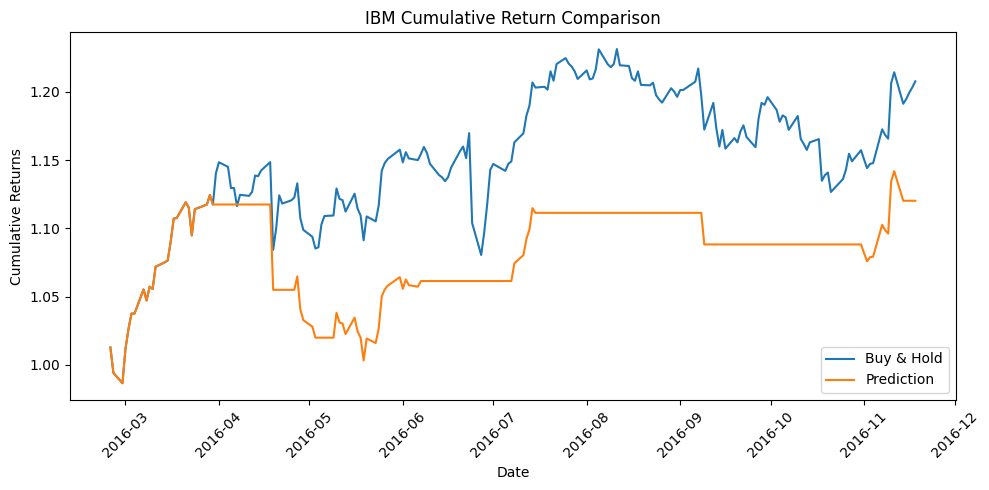

threshold = 0.5
Accuracy: 0.4787
Precision: 0.5522
Recall: 0.3524
F1 Score: 0.4302
AUC Score: 0.5219
Confusion Matrix:
[[53 30]
 [68 37]]
round 2
Epoch [10/10], Loss: 0.6744, minimum Loss: 0.6744, accuracy: 0.5160 maxaccuracy: 0.4681  Validation Loss: 0.6962, Minimum Validation Loss: 0.6943
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.002463884472801134


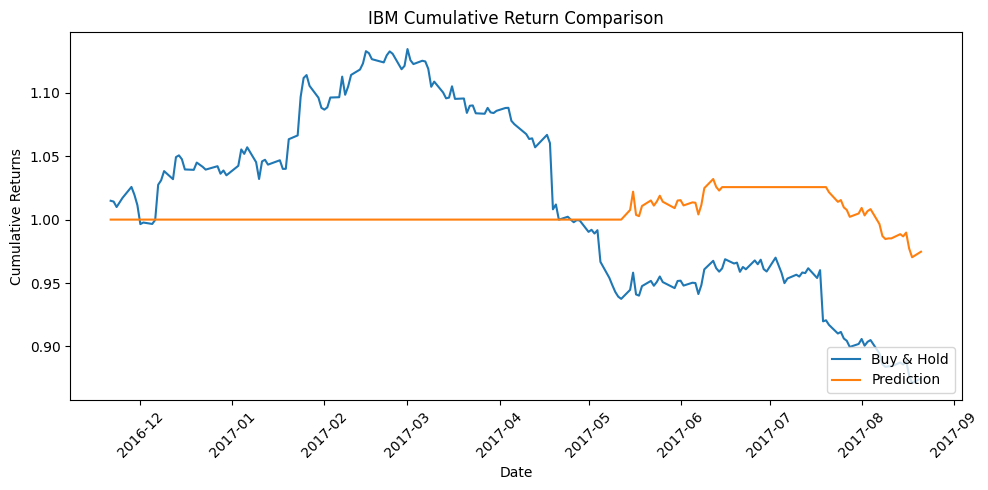

threshold = 0.5
Accuracy: 0.5160
Precision: 0.4889
Recall: 0.2444
F1 Score: 0.3259
AUC Score: 0.4579
Confusion Matrix:
[[75 23]
 [68 22]]
round 3
Epoch [10/10], Loss: 0.6801, minimum Loss: 0.6797, accuracy: 0.4840 maxaccuracy: 0.5213  Validation Loss: 0.6932, Minimum Validation Loss: 0.6927
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.0061015479486319696


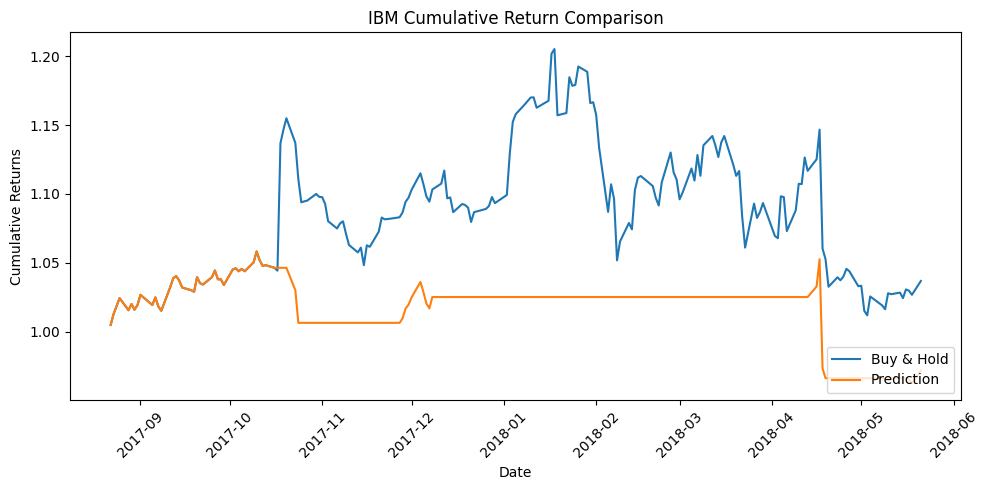

threshold = 0.5
Accuracy: 0.4840
Precision: 0.5088
Recall: 0.2959
F1 Score: 0.3742
AUC Score: 0.5201
Confusion Matrix:
[[62 28]
 [69 29]]
round 4
Epoch [10/10], Loss: 0.6698, minimum Loss: 0.6698, accuracy: 0.5532 maxaccuracy: 0.5798  Validation Loss: 0.6892, Minimum Validation Loss: 0.6889
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.007628130049777696


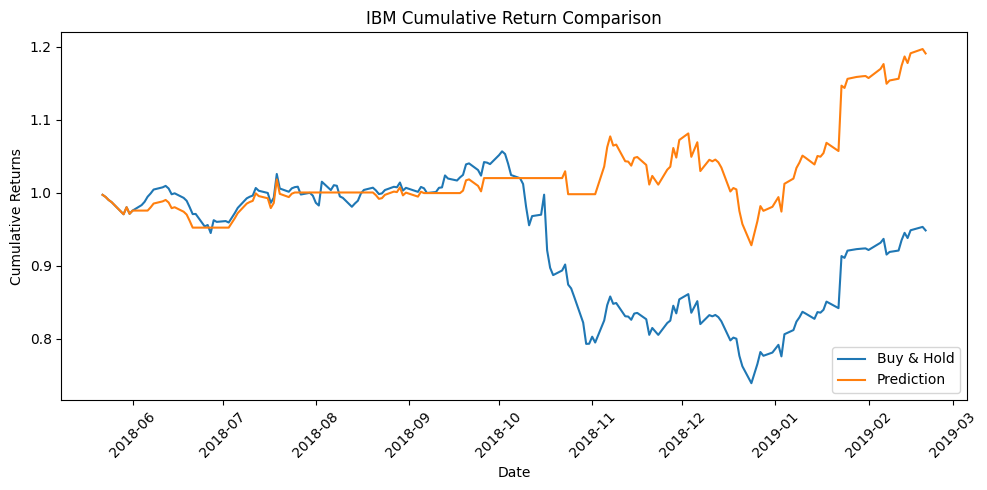

threshold = 0.5
Accuracy: 0.5532
Precision: 0.5635
Recall: 0.7100
F1 Score: 0.6283
AUC Score: 0.5408
Confusion Matrix:
[[33 55]
 [29 71]]
round 5
Epoch [10/10], Loss: 0.6774, minimum Loss: 0.6774, accuracy: 0.5160 maxaccuracy: 0.5585  Validation Loss: 0.6930, Minimum Validation Loss: 0.6909
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.007015024759654725


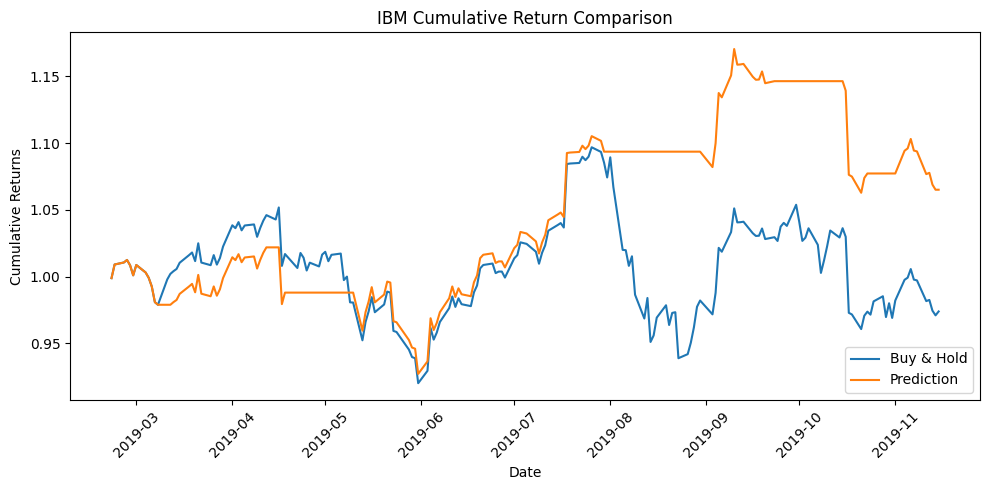

threshold = 0.5
Accuracy: 0.5160
Precision: 0.5574
Recall: 0.6476
F1 Score: 0.5991
AUC Score: 0.4854
Confusion Matrix:
[[29 54]
 [37 68]]
round 6
Epoch [10/10], Loss: 0.6727, minimum Loss: 0.6727, accuracy: 0.5266 maxaccuracy: 0.5266  Validation Loss: 0.6908, Minimum Validation Loss: 0.6908
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018759162866584588


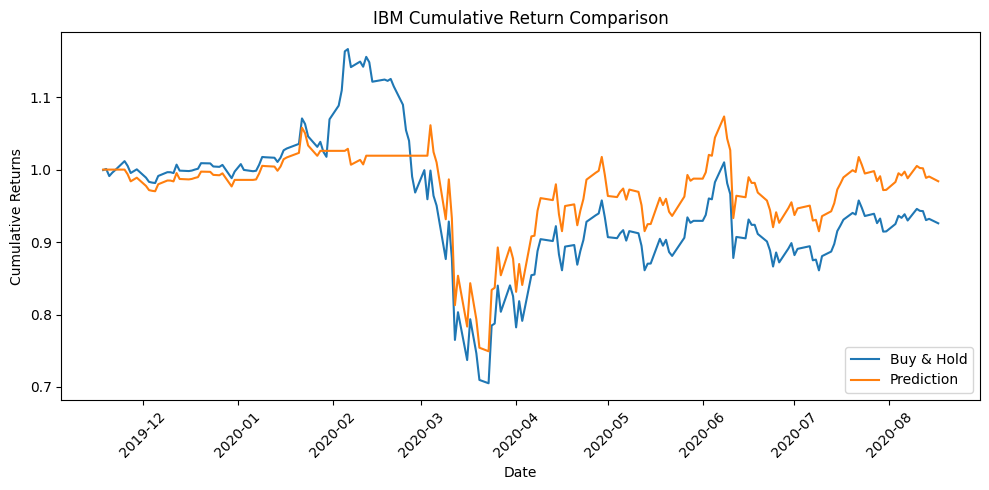

threshold = 0.5
Accuracy: 0.5266
Precision: 0.5188
Recall: 0.8737
F1 Score: 0.6510
AUC Score: 0.5491
Confusion Matrix:
[[16 77]
 [12 83]]
round 7
Epoch [10/10], Loss: 0.6713, minimum Loss: 0.6713, accuracy: 0.5134 maxaccuracy: 0.5187  Validation Loss: 0.6962, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012350813557270877


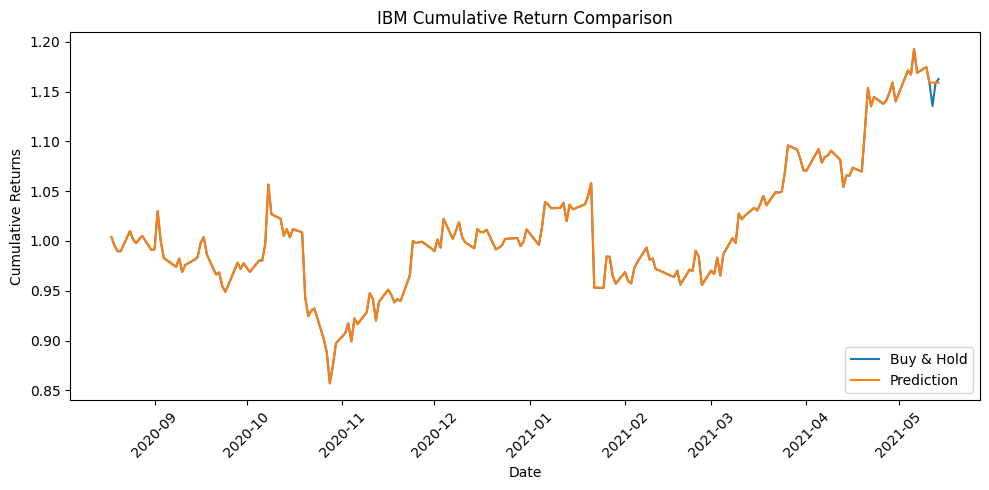

threshold = 0.5
Accuracy: 0.5134
Precision: 0.5163
Recall: 0.9794
F1 Score: 0.6762
AUC Score: 0.4568
Confusion Matrix:
[[ 1 89]
 [ 2 95]]
round 8
Epoch [10/10], Loss: 0.6760, minimum Loss: 0.6760, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6911, Minimum Validation Loss: 0.6911
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.005959472097628458


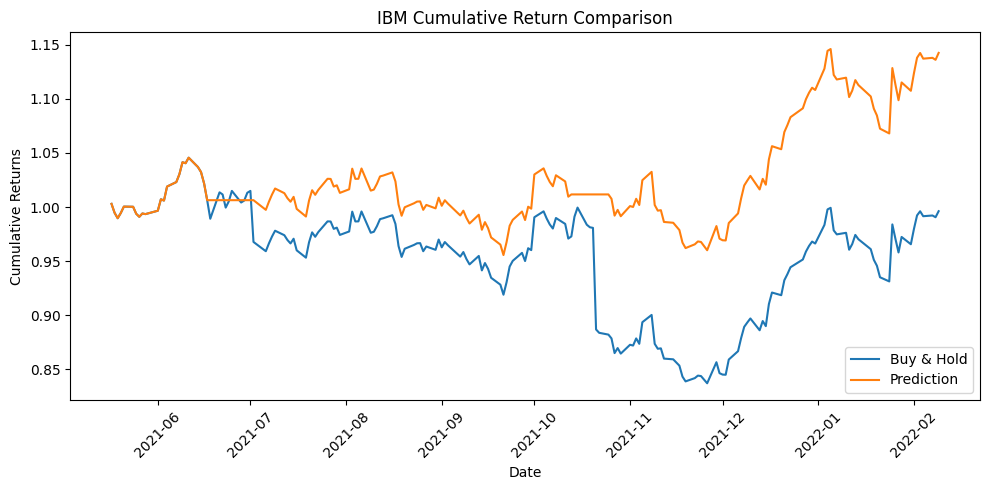

threshold = 0.5
Accuracy: 0.5187
Precision: 0.5119
Recall: 0.9149
F1 Score: 0.6565
AUC Score: 0.5504
Confusion Matrix:
[[11 82]
 [ 8 86]]
round 9
Epoch [10/10], Loss: 0.6750, minimum Loss: 0.6750, accuracy: 0.4920 maxaccuracy: 0.5134  Validation Loss: 0.6931, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.009410963932896737


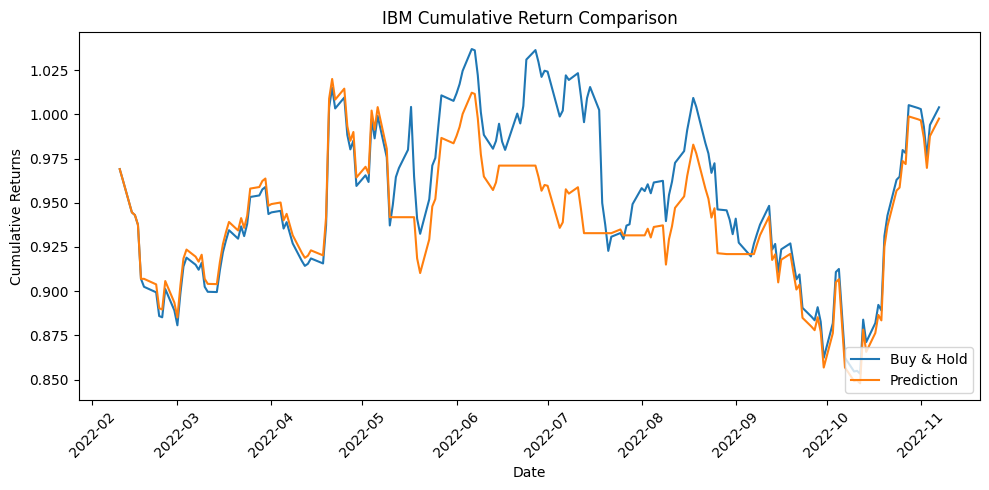

threshold = 0.5
Accuracy: 0.4920
Precision: 0.5032
Recall: 0.8125
F1 Score: 0.6215
AUC Score: 0.4929
Confusion Matrix:
[[14 77]
 [18 78]]
round 10
Epoch [10/10], Loss: 0.6862, minimum Loss: 0.6862, accuracy: 0.4973 maxaccuracy: 0.5508  Validation Loss: 0.6924, Minimum Validation Loss: 0.6894
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.004058770073878368


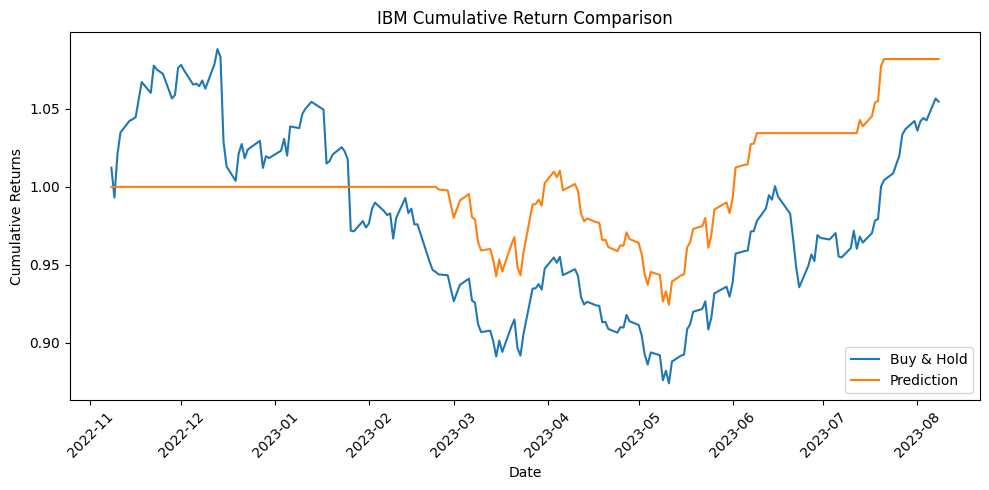

threshold = 0.5
Accuracy: 0.4973
Precision: 0.5556
Recall: 0.4369
F1 Score: 0.4891
AUC Score: 0.5261
Confusion Matrix:
[[48 36]
 [58 45]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009100875945247834


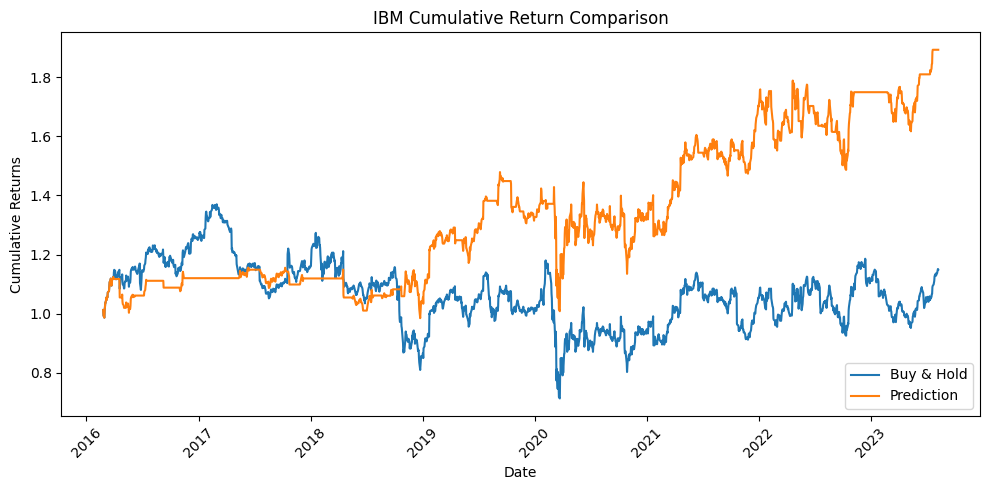

overall results:
Accuracy: 0.5096
Precision: 0.5270
Recall: 0.6246
F1 Score: 0.5717
AUC Score: 0.5076
Confusion Matrix:
[[342 551]
 [369 614]]
0.004439048960802067


In [43]:
from tqdm import tqdm
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers

num_epochs = 10
dates = aapl.index[sequence_length:-validationLength]

def hyperParameterTuning(hidden_units, num_layers, num_epochs, X_train_folds,y_train_folds,X_val_folds,y_val_folds,aapl=aapl):
    # Define the model
    num_features = X_train_folds[0].shape[-1]  # Number of features
    
    probabilities, predictions, actuals, train_loss_history, test_loss_history , all_pct_change, downside_deviation_list, cumulative_return_list= [], [] ,[], [], [],[],[],[]
    for i in range(len(X_train_folds)):
        print(f'round {i+1}')
        trainLoader, valLoader= createDataLoader(X_train_folds[i],y_train_folds[i],X_val_folds[i],y_val_folds[i])
        accuracy, validationLoss,train_loss_history_tmp, test_loss_history_tmp = 0,float('inf'), [],[]
        
        model = StockPredictor(num_features, hidden_units, num_layers,dropout_prob=0.05)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        model, train_loss_history_tmp, test_loss_history_tmp,accuracy, validationLoss = train_model(model, trainLoader,valLoader, criterion, optimizer, num_epochs)

        probabilities_tmp, predictions_tmp, actuals_tmp = evaluate_model(model, valLoader)
        dd, cr = cum_return(probabilities_tmp, pct_val_folds[i], date_val_fold[i],ticker)
        probabilities.extend(probabilities_tmp)
        predictions.extend(predictions_tmp)
        actuals.extend(actuals_tmp)
        all_pct_change.extend(pct_val_folds[i])
        train_loss_history.append(train_loss_history_tmp)
        test_loss_history.append(test_loss_history_tmp)
        downside_deviation_list.append(dd)
        cumulative_return_list.append(cr)
        print('threshold = 0.5')
        evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp)
        



    
    overall_dd, overall_cr = cum_return(probabilities,  aapl['pct_change'][sequence_length:-validationLength], dates, ticker)
    print('overall results:')
    evaluation(predictions,probabilities,actuals)
    Edownside_deviation_list = np.array(downside_deviation_list)
    print(np.std(downside_deviation_list))
    return downside_deviation_list, cumulative_return_list, overall_dd, overall_cr

downside_deviation_list, cumulative_return_list, overall_dd, overall_cr = hyperParameterTuning(hidden_units, num_layers, num_epochs, X_train_folds,y_train_folds,X_val_folds,y_val_folds)

    

Training with 250 hidden units, 2 layers, 10 epochs
round 1
Epoch [10/10], Loss: 0.6760, minimum Loss: 0.6760, accuracy: 0.4947 maxaccuracy: 0.5585  Validation Loss: 0.6933, Minimum Validation Loss: 0.6894
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction Downside Deviation: 0.003382559038164228


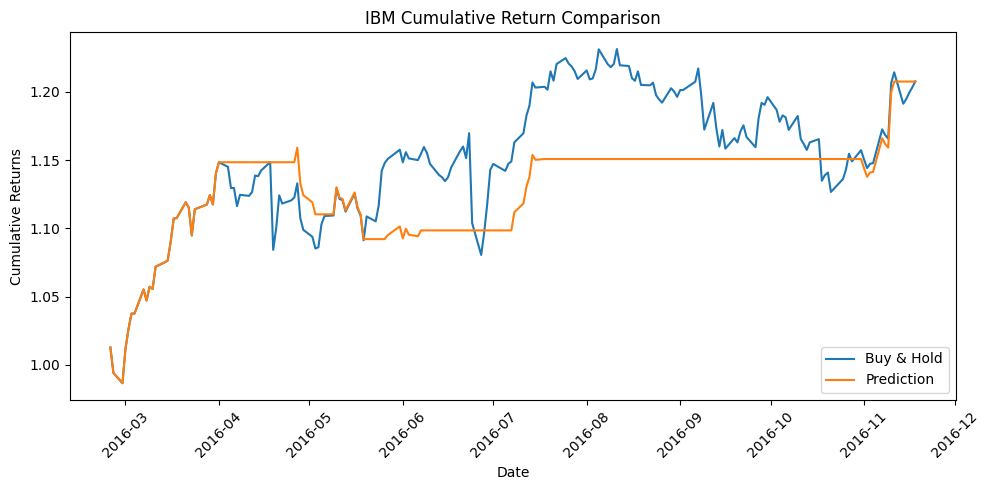

threshold = 0.5
Accuracy: 0.4947
Precision: 0.5806
Recall: 0.3429
F1 Score: 0.4311
AUC Score: 0.5337
Confusion Matrix:
[[57 26]
 [69 36]]
round 2
Epoch [10/10], Loss: 0.6770, minimum Loss: 0.6770, accuracy: 0.5160 maxaccuracy: 0.5160  Validation Loss: 0.6959, Minimum Validation Loss: 0.6940
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.001998323695547951


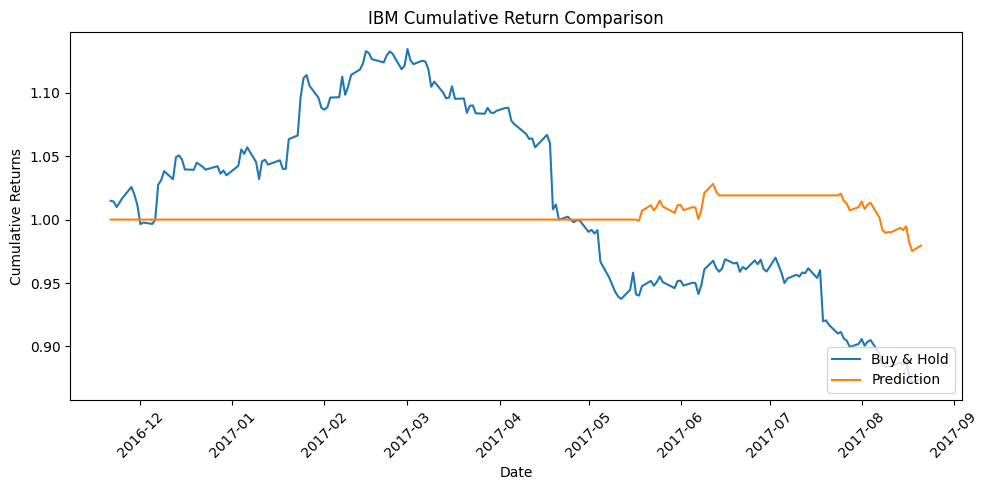

threshold = 0.5
Accuracy: 0.5160
Precision: 0.4872
Recall: 0.2111
F1 Score: 0.2946
AUC Score: 0.4560
Confusion Matrix:
[[78 20]
 [71 19]]
round 3
Epoch [10/10], Loss: 0.6801, minimum Loss: 0.6801, accuracy: 0.5000 maxaccuracy: 0.5213  Validation Loss: 0.6929, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.0057720812884859566


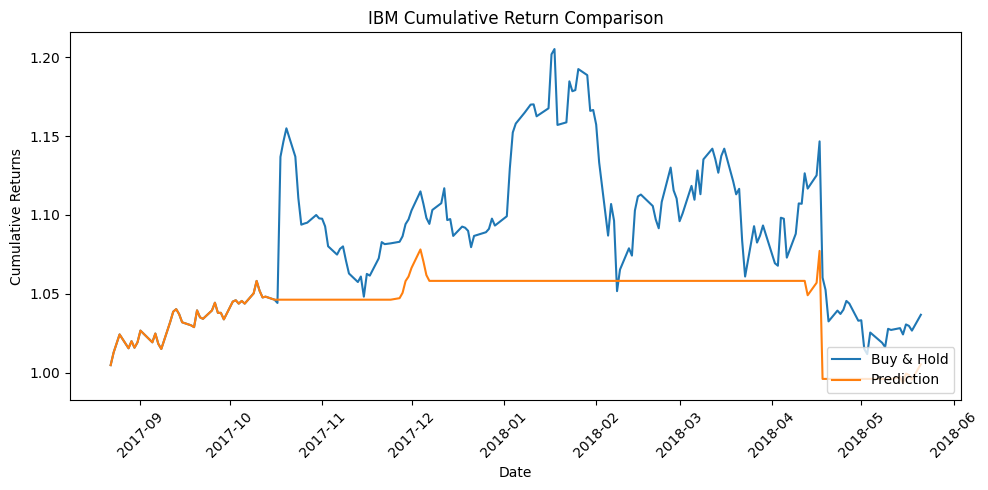

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5345
Recall: 0.3163
F1 Score: 0.3974
AUC Score: 0.5255
Confusion Matrix:
[[63 27]
 [67 31]]
round 4
Epoch [10/10], Loss: 0.6742, minimum Loss: 0.6742, accuracy: 0.5479 maxaccuracy: 0.5479  Validation Loss: 0.6891, Minimum Validation Loss: 0.6891
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.00766741653542668


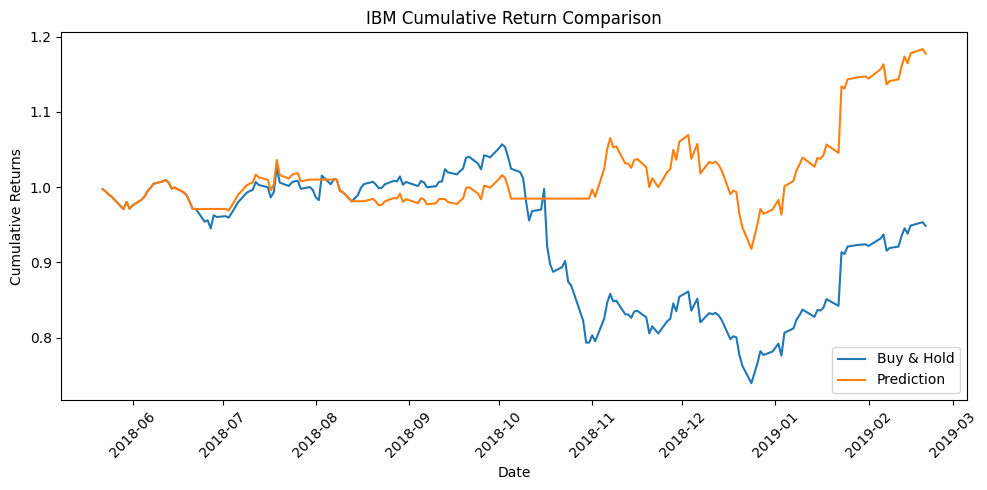

threshold = 0.5
Accuracy: 0.5479
Precision: 0.5497
Recall: 0.8300
F1 Score: 0.6614
AUC Score: 0.5425
Confusion Matrix:
[[20 68]
 [17 83]]
round 5
Epoch [10/10], Loss: 0.6756, minimum Loss: 0.6756, accuracy: 0.5160 maxaccuracy: 0.5585  Validation Loss: 0.6932, Minimum Validation Loss: 0.6904
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.0066752284586285736


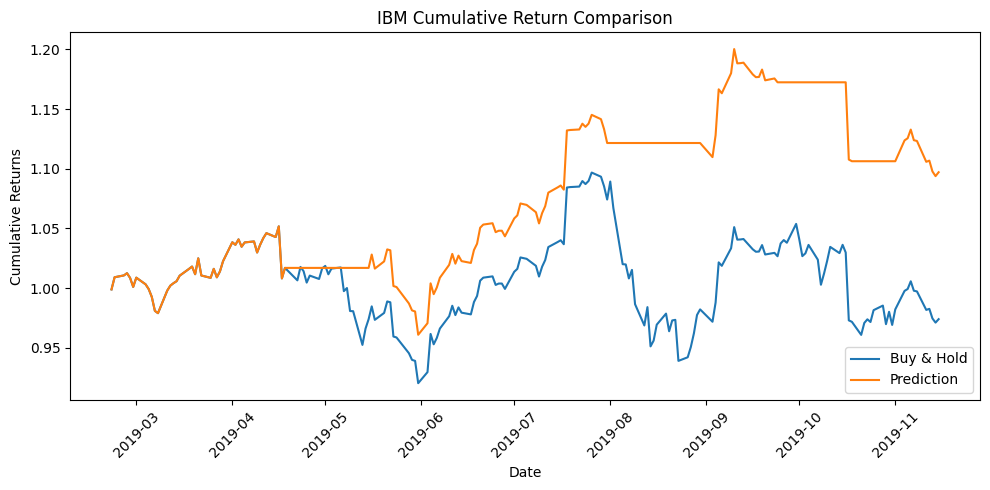

threshold = 0.5
Accuracy: 0.5160
Precision: 0.5574
Recall: 0.6476
F1 Score: 0.5991
AUC Score: 0.4833
Confusion Matrix:
[[29 54]
 [37 68]]
round 6
Epoch [10/10], Loss: 0.6727, minimum Loss: 0.6727, accuracy: 0.5266 maxaccuracy: 0.5266  Validation Loss: 0.6911, Minimum Validation Loss: 0.6910
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.01880747147480435


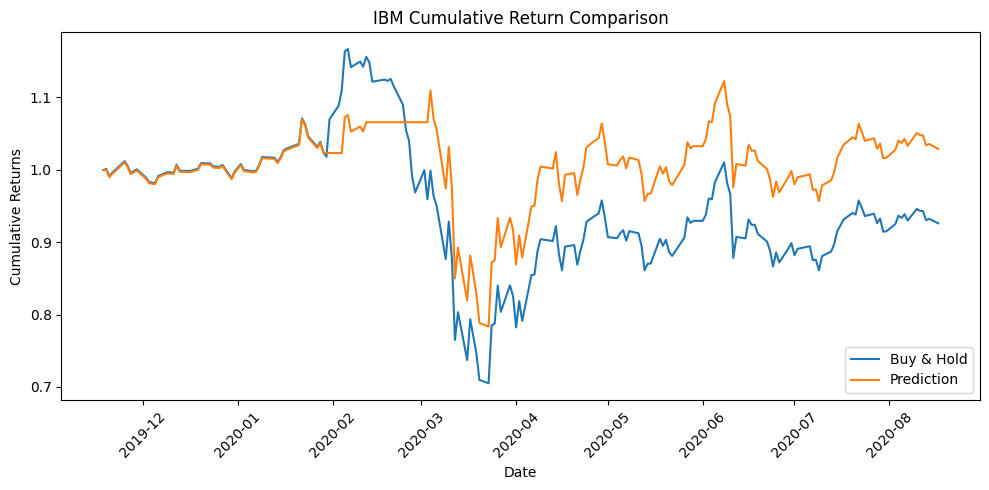

threshold = 0.5
Accuracy: 0.5266
Precision: 0.5176
Recall: 0.9263
F1 Score: 0.6642
AUC Score: 0.5490
Confusion Matrix:
[[11 82]
 [ 7 88]]
round 7
Epoch [10/10], Loss: 0.6729, minimum Loss: 0.6729, accuracy: 0.5134 maxaccuracy: 0.5187  Validation Loss: 0.6962, Minimum Validation Loss: 0.6926
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012350813557270877


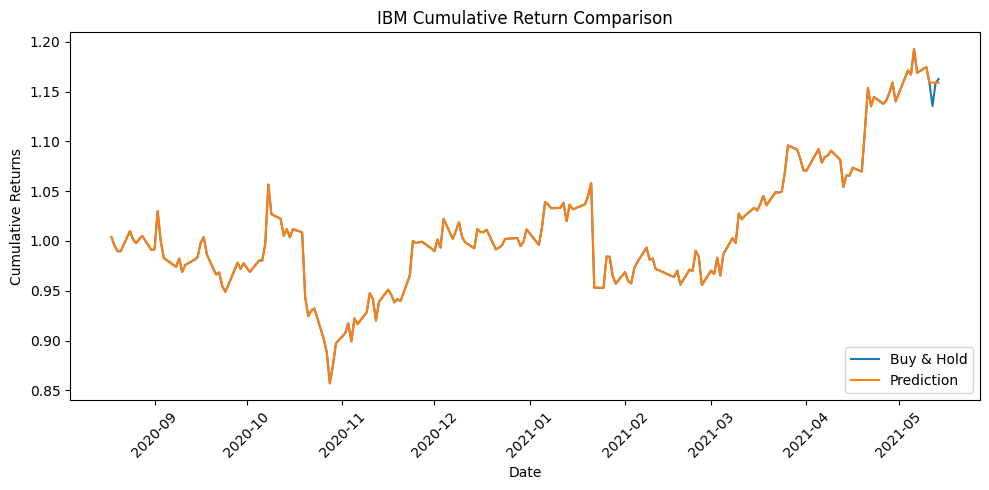

threshold = 0.5
Accuracy: 0.5134
Precision: 0.5163
Recall: 0.9794
F1 Score: 0.6762
AUC Score: 0.4566
Confusion Matrix:
[[ 1 89]
 [ 2 95]]
round 8
Epoch [10/10], Loss: 0.6756, minimum Loss: 0.6756, accuracy: 0.5080 maxaccuracy: 0.5080  Validation Loss: 0.6910, Minimum Validation Loss: 0.6910
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.009240830697256407


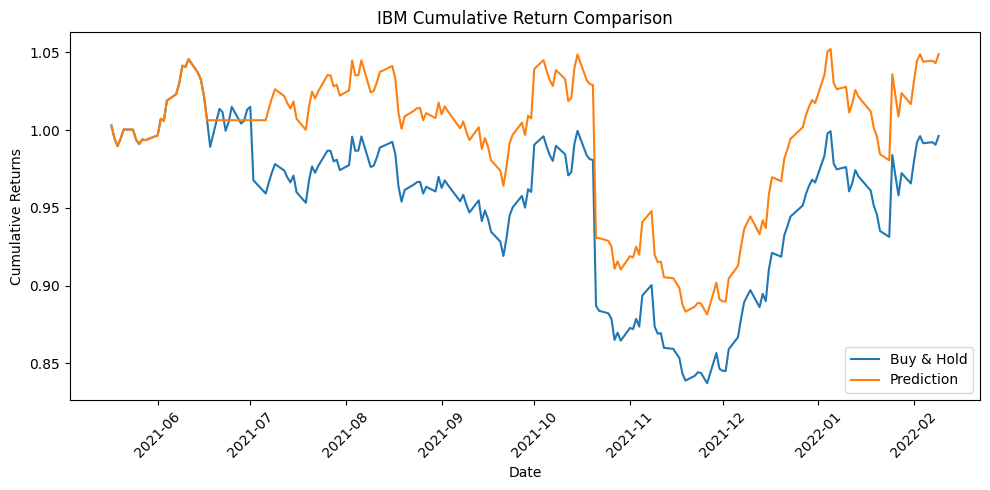

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5057
Recall: 0.9362
F1 Score: 0.6567
AUC Score: 0.5586
Confusion Matrix:
[[ 7 86]
 [ 6 88]]
round 9
Epoch [10/10], Loss: 0.6711, minimum Loss: 0.6711, accuracy: 0.4759 maxaccuracy: 0.5134  Validation Loss: 0.6930, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.009832039129227284


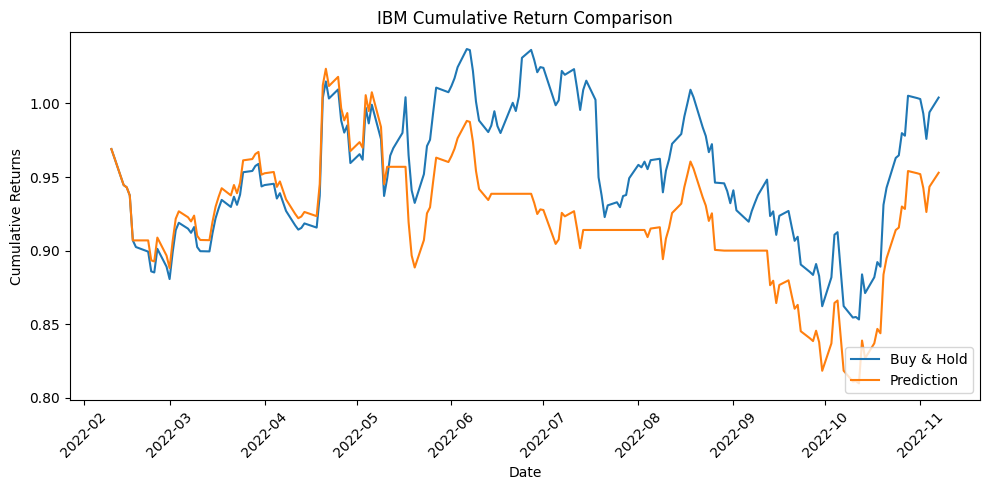

threshold = 0.5
Accuracy: 0.4759
Precision: 0.4933
Recall: 0.7708
F1 Score: 0.6016
AUC Score: 0.4928
Confusion Matrix:
[[15 76]
 [22 74]]
round 10
Epoch [10/10], Loss: 0.6862, minimum Loss: 0.6862, accuracy: 0.5080 maxaccuracy: 0.5508  Validation Loss: 0.6908, Minimum Validation Loss: 0.6895
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.004157684694235896


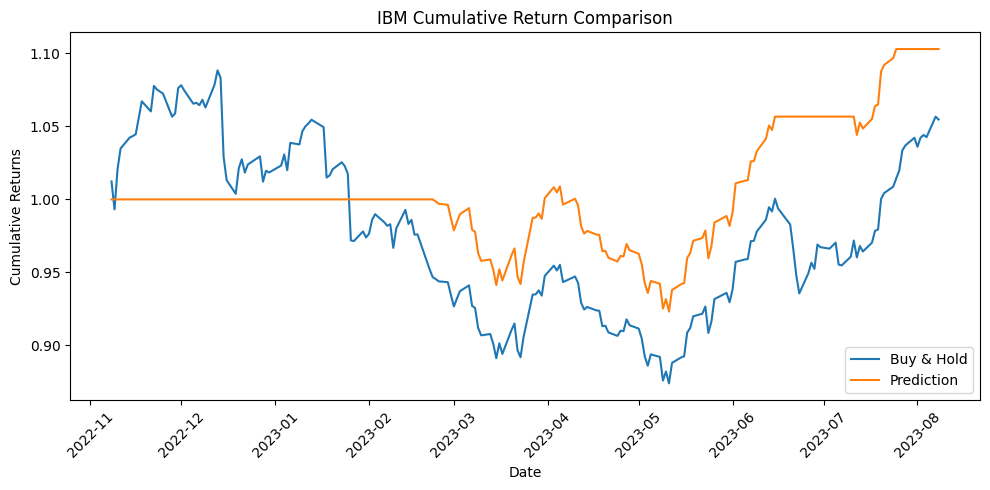

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5618
Recall: 0.4854
F1 Score: 0.5208
AUC Score: 0.5432
Confusion Matrix:
[[45 39]
 [53 50]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.00926101939252259


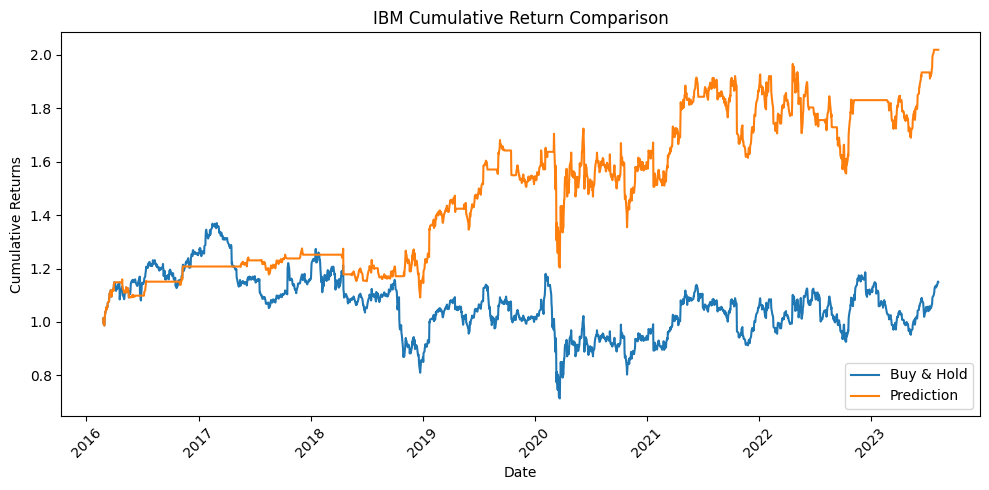

overall results:
Accuracy: 0.5107
Precision: 0.5271
Recall: 0.6429
F1 Score: 0.5793
AUC Score: 0.5121
Confusion Matrix:
[[326 567]
 [351 632]]
0.0046857147891972125
Downside deviation list: [0.003382559038164228, 0.001998323695547951, 0.0057720812884859566, 0.00766741653542668, 0.0066752284586285736, 0.01880747147480435, 0.012350813557270877, 0.009240830697256407, 0.009832039129227284, 0.004157684694235896]
Cumulative return list: [1.2075992518195993, 0.9795721143613639, 1.0054428044701178, 1.1774442350024399, 1.0970999921053028, 1.0285474662493426, 1.158952032500096, 1.048819980455131, 0.9529191099823285, 1.1030272929083276]
Overall downside deviation: 0.00926101939252259
Overall cumulative return: 2.0189995687087126


Training with 250 hidden units, 2 layers, 15 epochs
round 1
Epoch [10/15], Loss: 0.6723, minimum Loss: 0.6723, accuracy: 0.4840 maxaccuracy: 0.5585  Validation Loss: 0.6933, Minimum Validation Loss: 0.6894
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction D

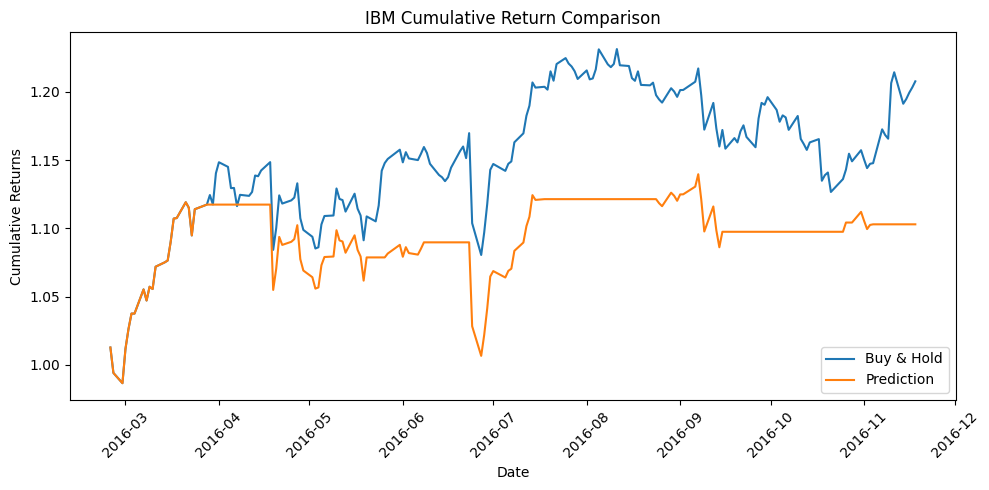

threshold = 0.5
Accuracy: 0.5426
Precision: 0.6044
Recall: 0.5238
F1 Score: 0.5612
AUC Score: 0.5213
Confusion Matrix:
[[47 36]
 [50 55]]
round 2
Epoch [10/15], Loss: 0.6727, minimum Loss: 0.6727, accuracy: 0.5106 maxaccuracy: 0.4628  Validation Loss: 0.6972, Minimum Validation Loss: 0.6945
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.005596317314365079


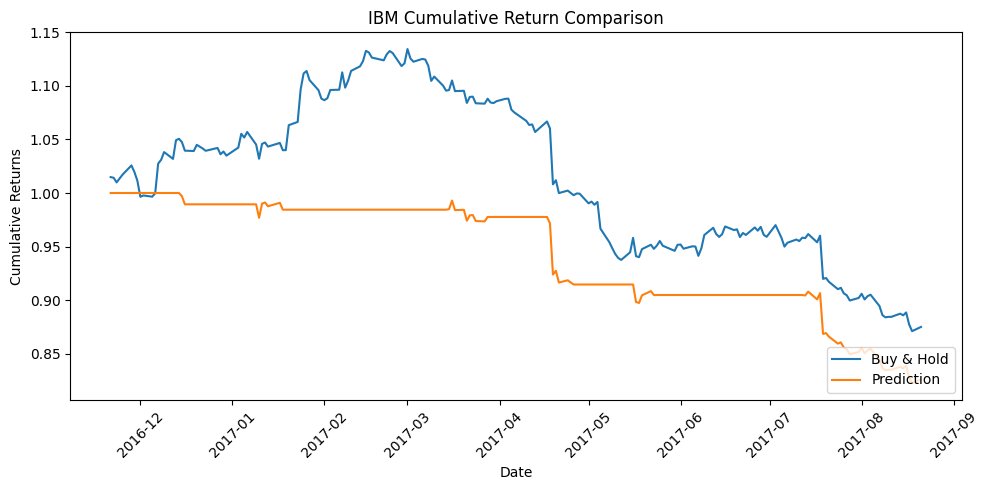

threshold = 0.5
Accuracy: 0.4787
Precision: 0.4310
Recall: 0.2778
F1 Score: 0.3378
AUC Score: 0.4760
Confusion Matrix:
[[65 33]
 [65 25]]
round 3
Epoch [10/15], Loss: 0.6786, minimum Loss: 0.6786, accuracy: 0.5053 maxaccuracy: 0.5213  Validation Loss: 0.6927, Minimum Validation Loss: 0.6923
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.005718399407754194


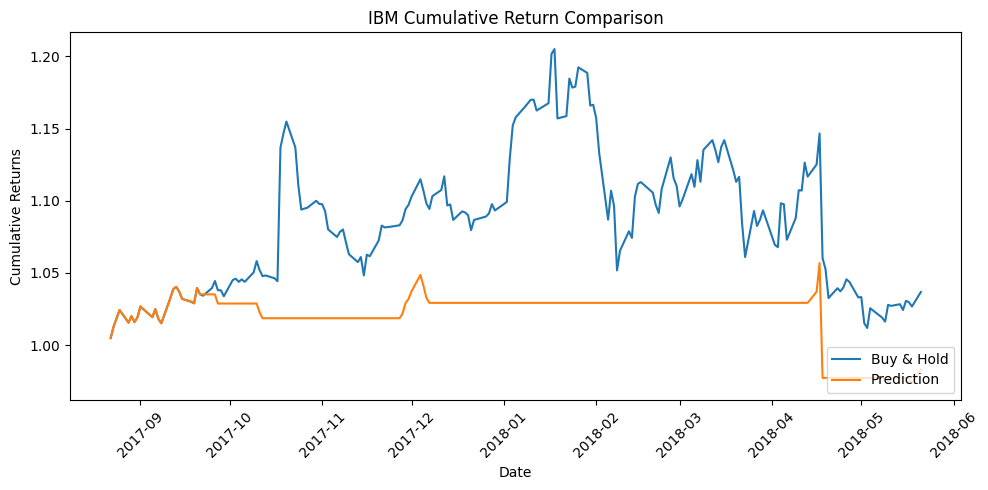

threshold = 0.5
Accuracy: 0.4787
Precision: 0.5000
Recall: 0.2041
F1 Score: 0.2899
AUC Score: 0.5399
Confusion Matrix:
[[70 20]
 [78 20]]
round 4
Epoch [10/15], Loss: 0.6736, minimum Loss: 0.6736, accuracy: 0.5691 maxaccuracy: 0.5691  Validation Loss: 0.6892, Minimum Validation Loss: 0.6892
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.010177775666322598


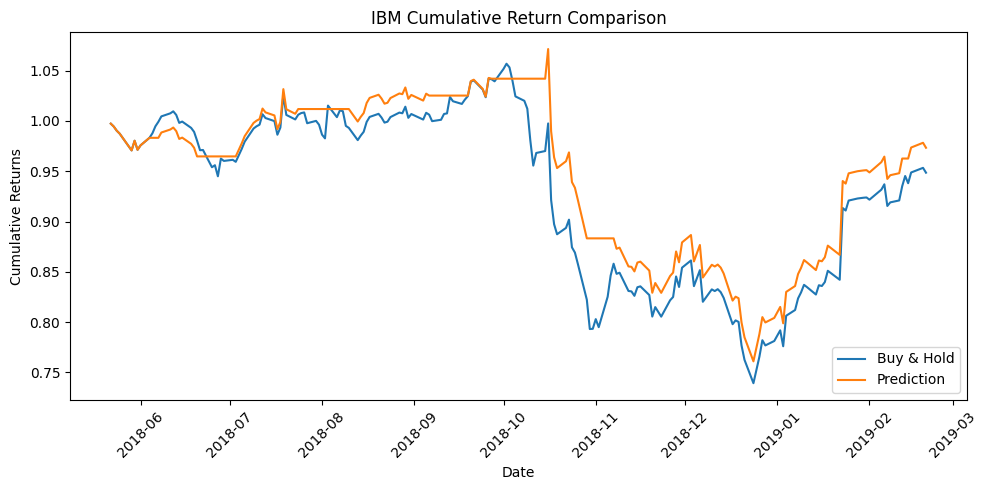

threshold = 0.5
Accuracy: 0.5266
Precision: 0.5414
Recall: 0.7200
F1 Score: 0.6180
AUC Score: 0.5164
Confusion Matrix:
[[27 61]
 [28 72]]
round 5
Epoch [10/15], Loss: 0.6760, minimum Loss: 0.6760, accuracy: 0.5319 maxaccuracy: 0.5585  Validation Loss: 0.6931, Minimum Validation Loss: 0.6908
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.006204927463590122


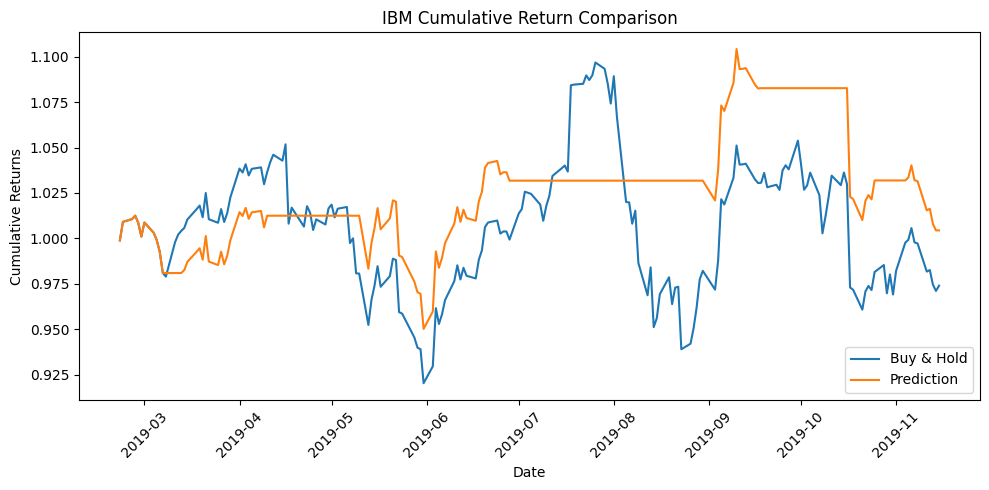

threshold = 0.5
Accuracy: 0.4628
Precision: 0.5217
Recall: 0.4571
F1 Score: 0.4873
AUC Score: 0.4725
Confusion Matrix:
[[39 44]
 [57 48]]
round 6
Epoch [10/15], Loss: 0.6719, minimum Loss: 0.6719, accuracy: 0.5000 maxaccuracy: 0.5160  Validation Loss: 0.6918, Minimum Validation Loss: 0.6915
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018852617190262


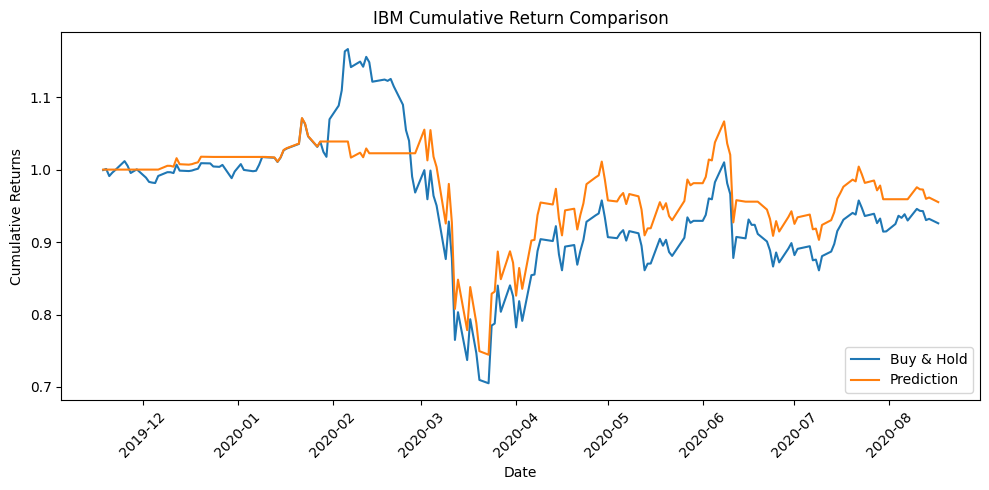

threshold = 0.5
Accuracy: 0.5213
Precision: 0.5185
Recall: 0.7368
F1 Score: 0.6087
AUC Score: 0.5079
Confusion Matrix:
[[28 65]
 [25 70]]
round 7
Epoch [10/15], Loss: 0.6749, minimum Loss: 0.6749, accuracy: 0.5080 maxaccuracy: 0.5187  Validation Loss: 0.6958, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.011898590151338503


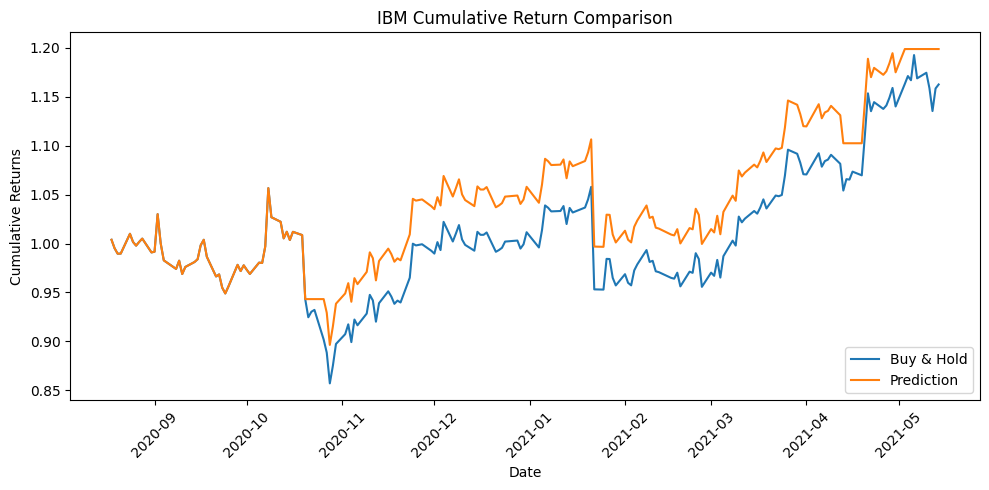

threshold = 0.5
Accuracy: 0.5134
Precision: 0.5176
Recall: 0.9072
F1 Score: 0.6592
AUC Score: 0.4714
Confusion Matrix:
[[ 8 82]
 [ 9 88]]
round 8
Epoch [10/15], Loss: 0.6754, minimum Loss: 0.6754, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6908, Minimum Validation Loss: 0.6908
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.004732083728559269


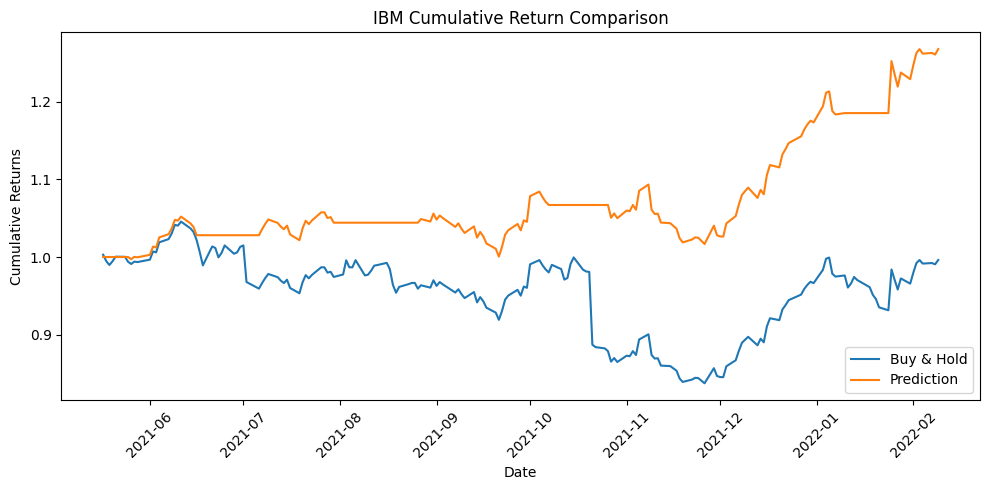

threshold = 0.5
Accuracy: 0.5294
Precision: 0.5238
Recall: 0.7021
F1 Score: 0.6000
AUC Score: 0.5628
Confusion Matrix:
[[33 60]
 [28 66]]
round 9
Epoch [10/15], Loss: 0.6756, minimum Loss: 0.6756, accuracy: 0.4866 maxaccuracy: 0.5027  Validation Loss: 0.6925, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.007897280732082694


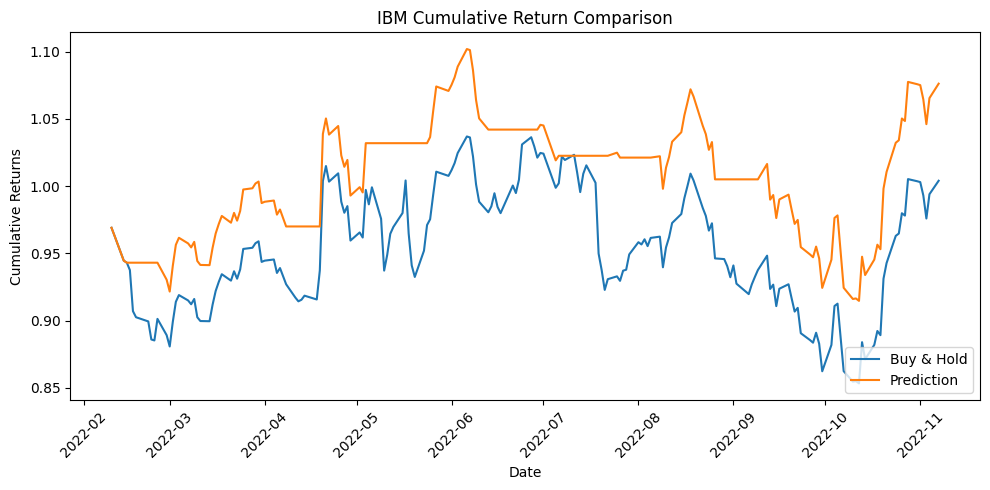

threshold = 0.5
Accuracy: 0.5187
Precision: 0.5250
Recall: 0.6562
F1 Score: 0.5833
AUC Score: 0.5111
Confusion Matrix:
[[34 57]
 [33 63]]
round 10
Epoch [10/15], Loss: 0.6860, minimum Loss: 0.6860, accuracy: 0.4973 maxaccuracy: 0.5508  Validation Loss: 0.6917, Minimum Validation Loss: 0.6895
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.0037802441887755047


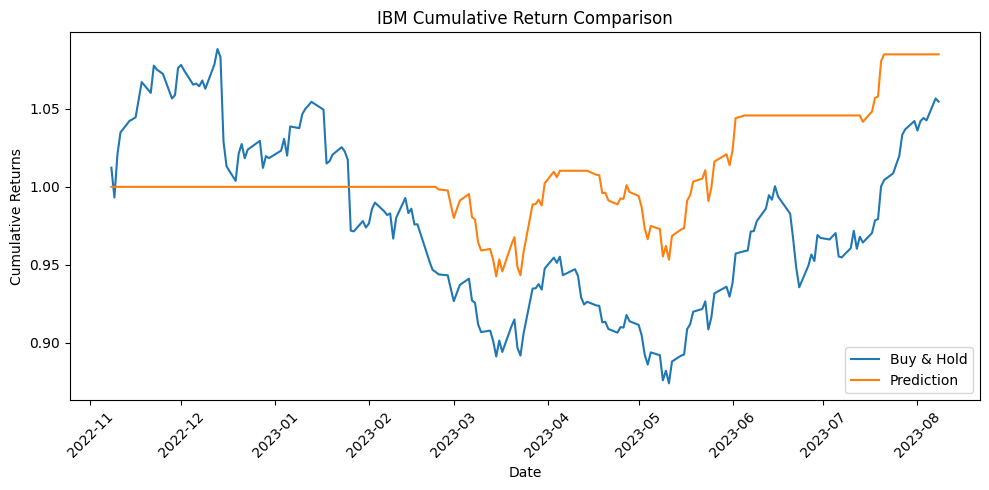

threshold = 0.5
Accuracy: 0.4813
Precision: 0.5429
Recall: 0.3689
F1 Score: 0.4393
AUC Score: 0.5175
Confusion Matrix:
[[52 32]
 [65 38]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.00925122639655429


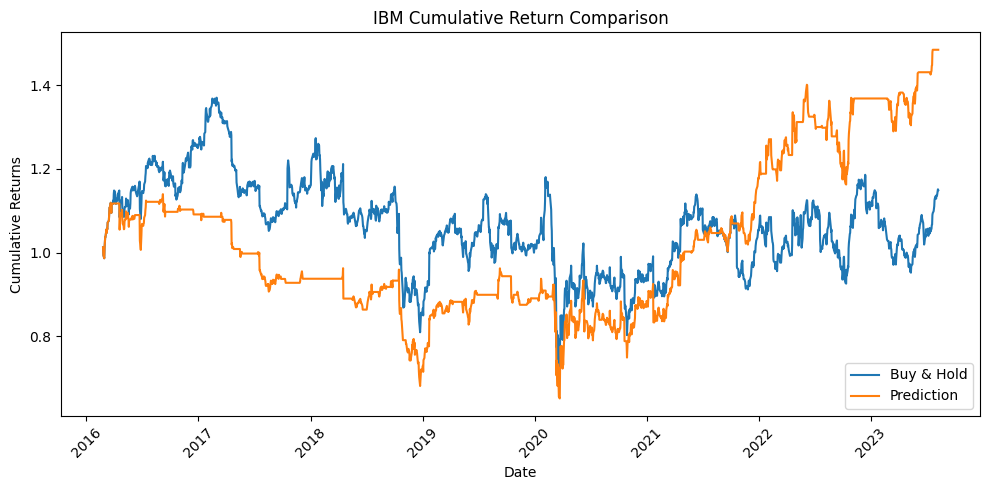

overall results:
Accuracy: 0.5053
Precision: 0.5266
Recall: 0.5544
F1 Score: 0.5401
AUC Score: 0.5093
Confusion Matrix:
[[403 490]
 [438 545]]
0.004248104585497957
Downside deviation list: [0.007290832236499144, 0.005596317314365079, 0.005718399407754194, 0.010177775666322598, 0.006204927463590122, 0.018852617190262, 0.011898590151338503, 0.004732083728559269, 0.007897280732082694, 0.0037802441887755047]
Cumulative return list: [1.1030261325292283, 0.8260400434625201, 0.9830409268609122, 0.9733008952970746, 1.004350944024099, 0.9551269964985074, 1.1988633634957888, 1.2680346968260698, 1.076216007309146, 1.085004261810412]
Overall downside deviation: 0.00925122639655429
Overall cumulative return: 1.484512826735183


Training with 250 hidden units, 3 layers, 10 epochs
round 1
Epoch [10/10], Loss: 0.6763, minimum Loss: 0.6763, accuracy: 0.4628 maxaccuracy: 0.5585  Validation Loss: 0.6936, Minimum Validation Loss: 0.6896
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction Downsi

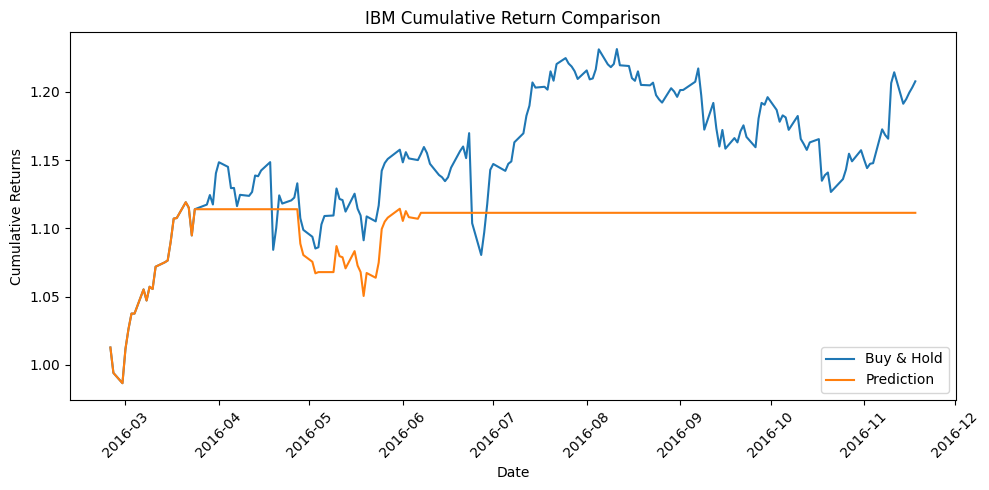

threshold = 0.5
Accuracy: 0.4628
Precision: 0.5435
Recall: 0.2381
F1 Score: 0.3311
AUC Score: 0.5461
Confusion Matrix:
[[62 21]
 [80 25]]
round 2
Epoch [10/10], Loss: 0.6698, minimum Loss: 0.6698, accuracy: 0.4787 maxaccuracy: 0.4574  Validation Loss: 0.6991, Minimum Validation Loss: 0.6950
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.005478766324248048


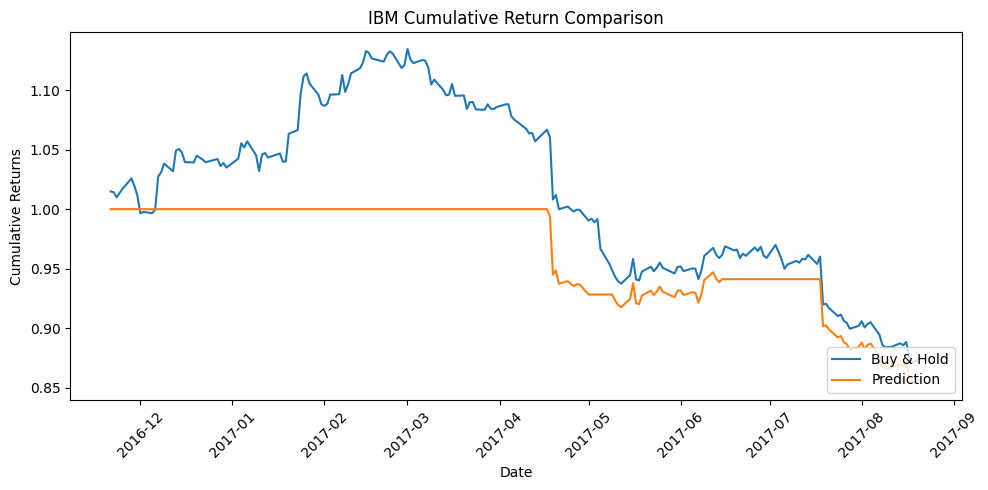

threshold = 0.5
Accuracy: 0.4787
Precision: 0.4333
Recall: 0.2889
F1 Score: 0.3467
AUC Score: 0.4607
Confusion Matrix:
[[64 34]
 [64 26]]
round 3
Epoch [10/10], Loss: 0.6828, minimum Loss: 0.6782, accuracy: 0.4947 maxaccuracy: 0.5213  Validation Loss: 0.6931, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.00596110204876155


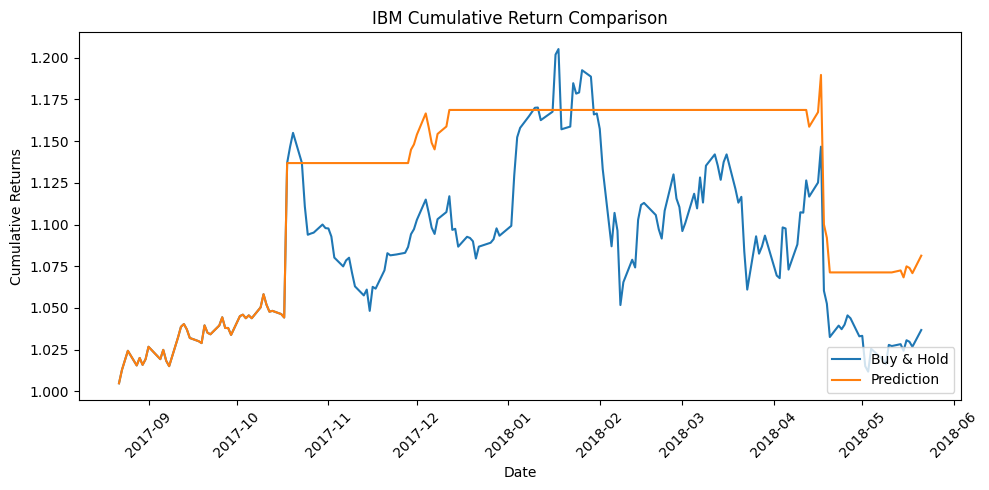

threshold = 0.5
Accuracy: 0.4947
Precision: 0.5238
Recall: 0.3367
F1 Score: 0.4099
AUC Score: 0.5139
Confusion Matrix:
[[60 30]
 [65 33]]
round 4
Epoch [10/10], Loss: 0.6746, minimum Loss: 0.6746, accuracy: 0.5532 maxaccuracy: 0.5691  Validation Loss: 0.6901, Minimum Validation Loss: 0.6898
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.008752098340936742


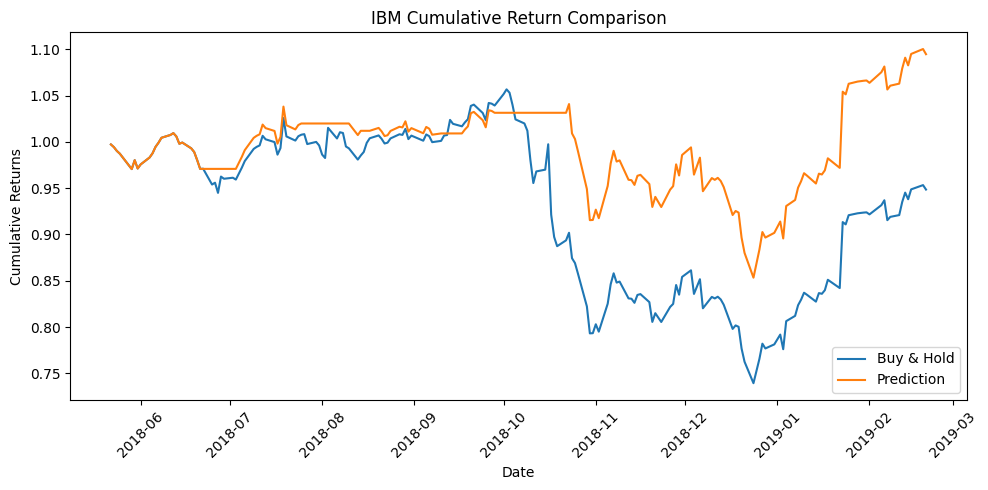

threshold = 0.5
Accuracy: 0.5532
Precision: 0.5556
Recall: 0.8000
F1 Score: 0.6557
AUC Score: 0.5328
Confusion Matrix:
[[24 64]
 [20 80]]
round 5
Epoch [10/10], Loss: 0.6814, minimum Loss: 0.6813, accuracy: 0.5372 maxaccuracy: 0.5585  Validation Loss: 0.6921, Minimum Validation Loss: 0.6904
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.007135249078152185


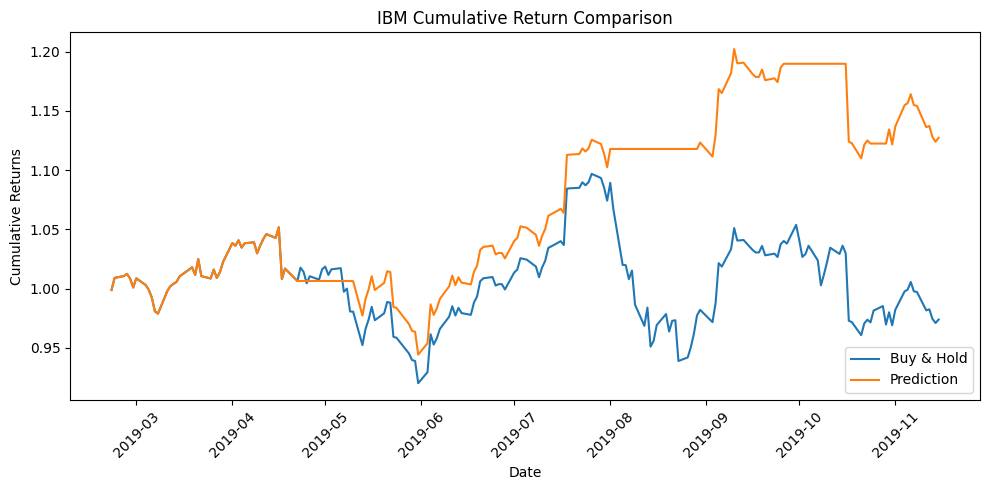

threshold = 0.5
Accuracy: 0.5372
Precision: 0.5652
Recall: 0.7429
F1 Score: 0.6420
AUC Score: 0.4923
Confusion Matrix:
[[23 60]
 [27 78]]
round 6
Epoch [10/10], Loss: 0.6742, minimum Loss: 0.6742, accuracy: 0.5160 maxaccuracy: 0.5160  Validation Loss: 0.6911, Minimum Validation Loss: 0.6911
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.01912301448350296


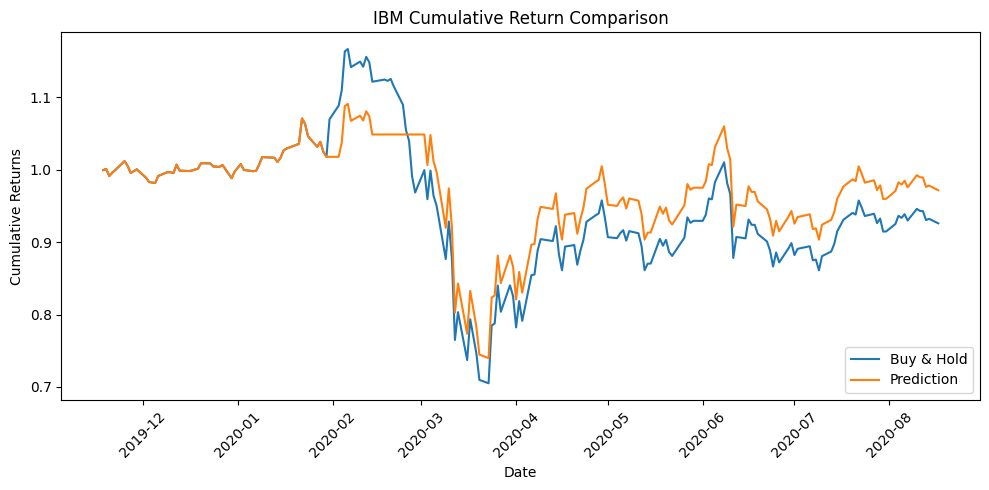

threshold = 0.5
Accuracy: 0.5160
Precision: 0.5114
Recall: 0.9474
F1 Score: 0.6642
AUC Score: 0.5518
Confusion Matrix:
[[ 7 86]
 [ 5 90]]
round 7
Epoch [10/10], Loss: 0.6752, minimum Loss: 0.6752, accuracy: 0.5134 maxaccuracy: 0.5187  Validation Loss: 0.6958, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012350813557270877


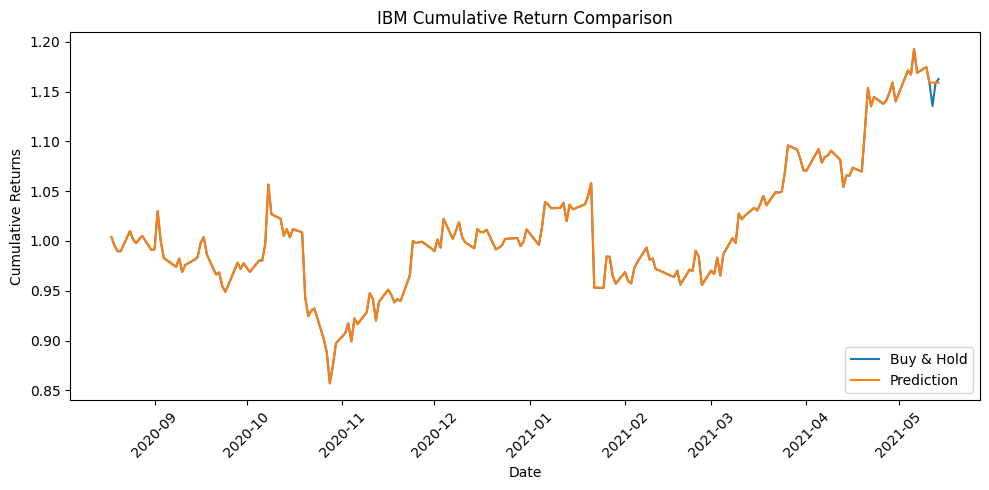

threshold = 0.5
Accuracy: 0.5134
Precision: 0.5163
Recall: 0.9794
F1 Score: 0.6762
AUC Score: 0.4615
Confusion Matrix:
[[ 1 89]
 [ 2 95]]
round 8
Epoch [10/10], Loss: 0.6803, minimum Loss: 0.6759, accuracy: 0.4920 maxaccuracy: 0.4920  Validation Loss: 0.6915, Minimum Validation Loss: 0.6915
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.009350377669725725


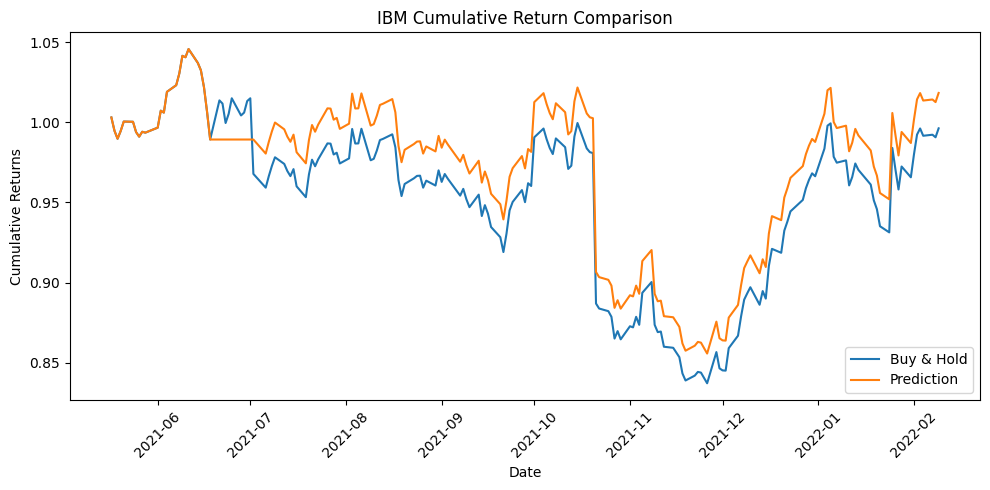

threshold = 0.5
Accuracy: 0.4920
Precision: 0.4972
Recall: 0.9362
F1 Score: 0.6494
AUC Score: 0.5532
Confusion Matrix:
[[ 4 89]
 [ 6 88]]
round 9
Epoch [10/10], Loss: 0.6791, minimum Loss: 0.6762, accuracy: 0.5080 maxaccuracy: 0.5027  Validation Loss: 0.6929, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.009321303057409967


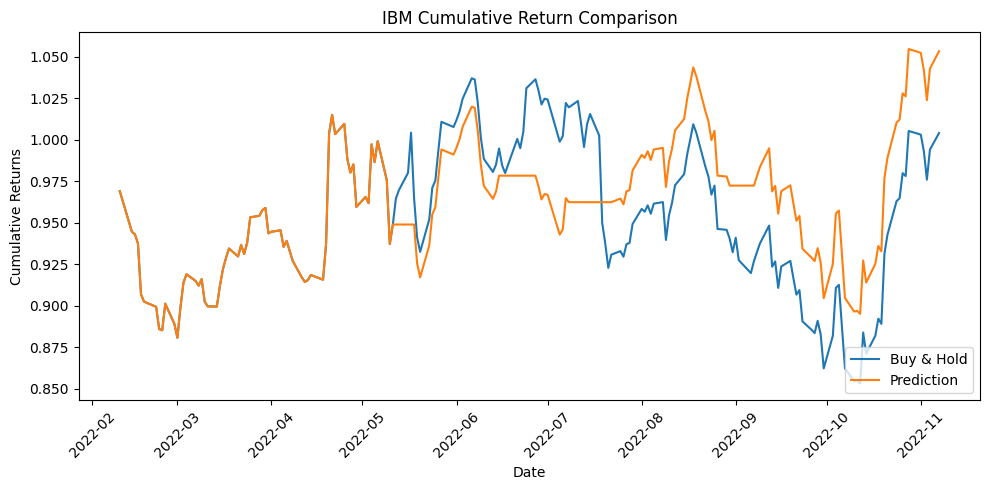

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5125
Recall: 0.8542
F1 Score: 0.6406
AUC Score: 0.4971
Confusion Matrix:
[[13 78]
 [14 82]]
round 10
Epoch [10/10], Loss: 0.6862, minimum Loss: 0.6862, accuracy: 0.5080 maxaccuracy: 0.5508  Validation Loss: 0.6917, Minimum Validation Loss: 0.6898
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.00432908549374329


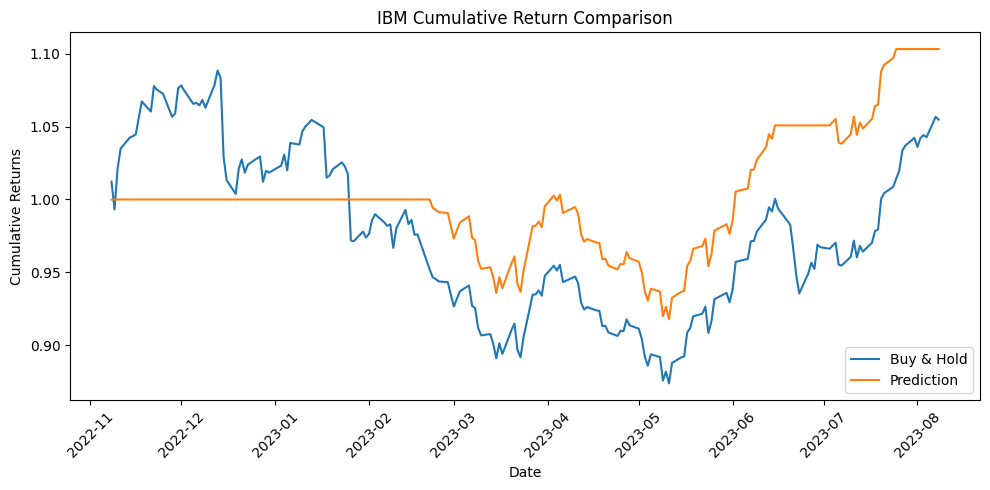

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5579
Recall: 0.5146
F1 Score: 0.5354
AUC Score: 0.5247
Confusion Matrix:
[[42 42]
 [50 53]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009566962006436693


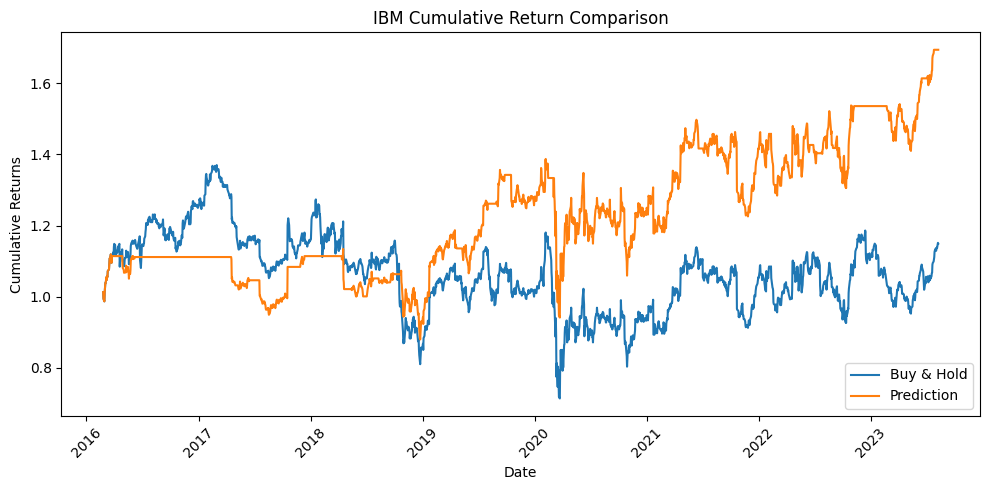

overall results:
Accuracy: 0.5064
Precision: 0.5229
Recall: 0.6612
F1 Score: 0.5840
AUC Score: 0.5058
Confusion Matrix:
[[300 593]
 [333 650]]
0.004371987112493551
Downside deviation list: [0.003287309477502291, 0.005478766324248048, 0.00596110204876155, 0.008752098340936742, 0.007135249078152185, 0.01912301448350296, 0.012350813557270877, 0.009350377669725725, 0.009321303057409967, 0.00432908549374329]
Cumulative return list: [1.1114482988983818, 0.8576747507229668, 1.0813214838011969, 1.0947620141591041, 1.1272579811444512, 0.9714794310592711, 1.158952032500096, 1.01824225407185, 1.0532655786031737, 1.1031482689950733]
Overall downside deviation: 0.009566962006436693
Overall cumulative return: 1.6944615812064523


Training with 250 hidden units, 3 layers, 15 epochs
round 1
Epoch [10/15], Loss: 0.6779, minimum Loss: 0.6779, accuracy: 0.4574 maxaccuracy: 0.5585  Validation Loss: 0.6936, Minimum Validation Loss: 0.6895
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction Downs

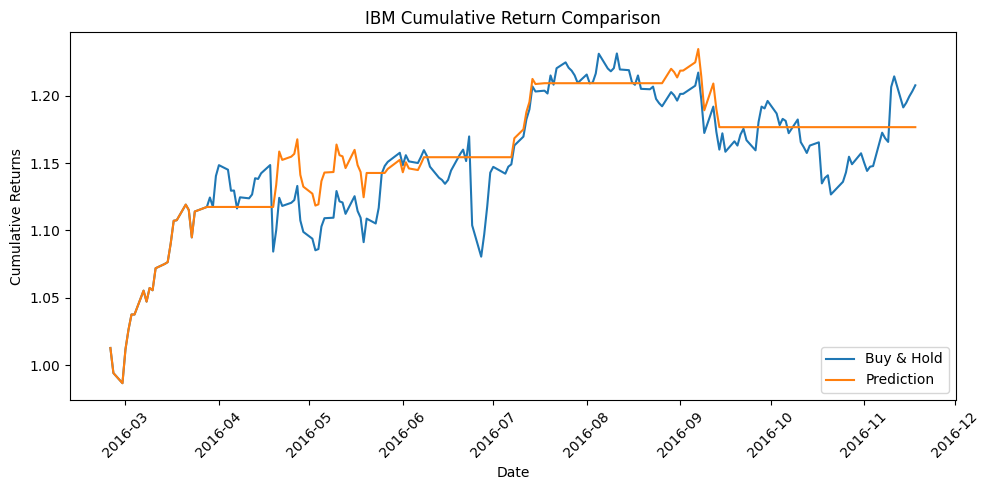

threshold = 0.5
Accuracy: 0.5266
Precision: 0.6111
Recall: 0.4190
F1 Score: 0.4972
AUC Score: 0.5275
Confusion Matrix:
[[55 28]
 [61 44]]
round 2
Epoch [10/15], Loss: 0.6821, minimum Loss: 0.6788, accuracy: 0.5213 maxaccuracy: 0.4628  Validation Loss: 0.6948, Minimum Validation Loss: 0.6943
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.00551793399026462


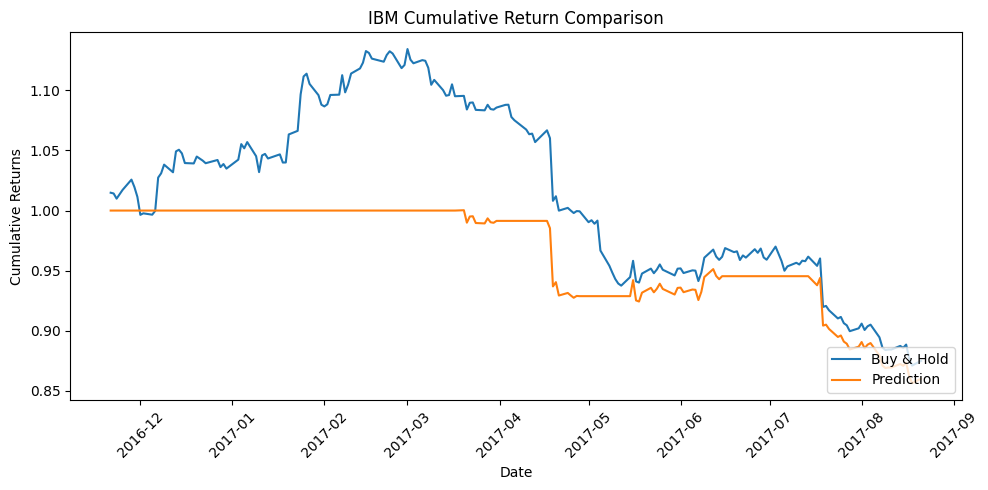

threshold = 0.5
Accuracy: 0.4947
Precision: 0.4627
Recall: 0.3444
F1 Score: 0.3949
AUC Score: 0.4594
Confusion Matrix:
[[62 36]
 [59 31]]
round 3
Epoch [10/15], Loss: 0.6827, minimum Loss: 0.6789, accuracy: 0.4840 maxaccuracy: 0.5213  Validation Loss: 0.6930, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.005701985083986989


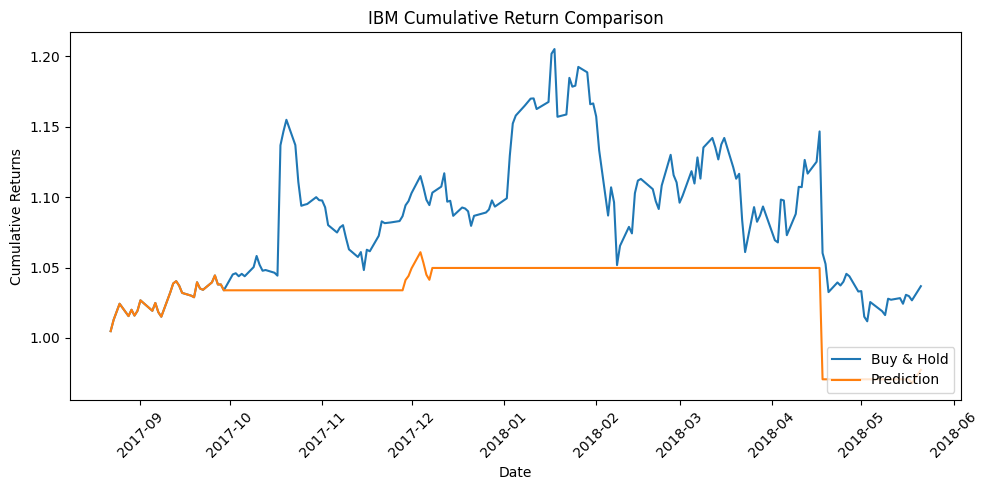

threshold = 0.5
Accuracy: 0.4840
Precision: 0.5128
Recall: 0.2041
F1 Score: 0.2920
AUC Score: 0.5355
Confusion Matrix:
[[71 19]
 [78 20]]
round 4
Epoch [10/15], Loss: 0.6716, minimum Loss: 0.6716, accuracy: 0.5479 maxaccuracy: 0.5426  Validation Loss: 0.6900, Minimum Validation Loss: 0.6896
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.009725547770339538


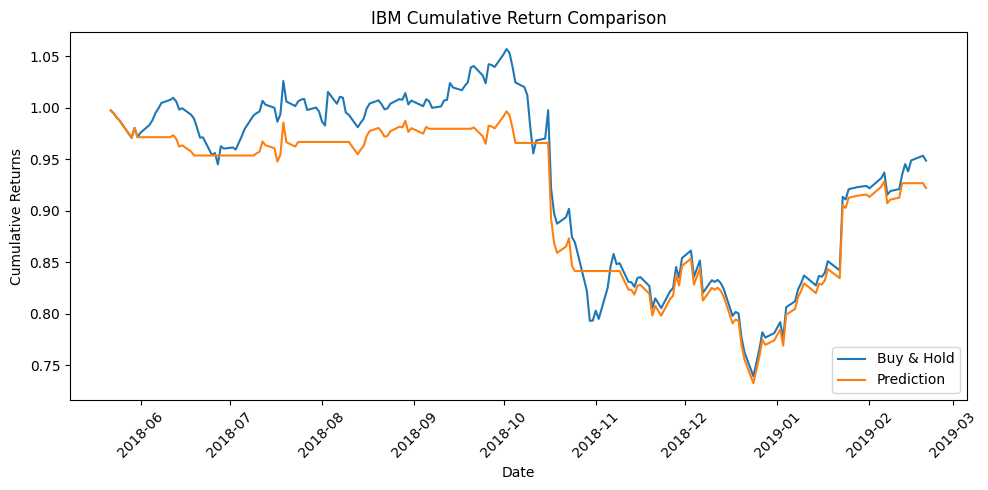

threshold = 0.5
Accuracy: 0.4734
Precision: 0.5041
Recall: 0.6200
F1 Score: 0.5561
AUC Score: 0.5062
Confusion Matrix:
[[27 61]
 [38 62]]
round 5
Epoch [10/15], Loss: 0.6789, minimum Loss: 0.6789, accuracy: 0.5053 maxaccuracy: 0.5585  Validation Loss: 0.6925, Minimum Validation Loss: 0.6904
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.006654557913596701


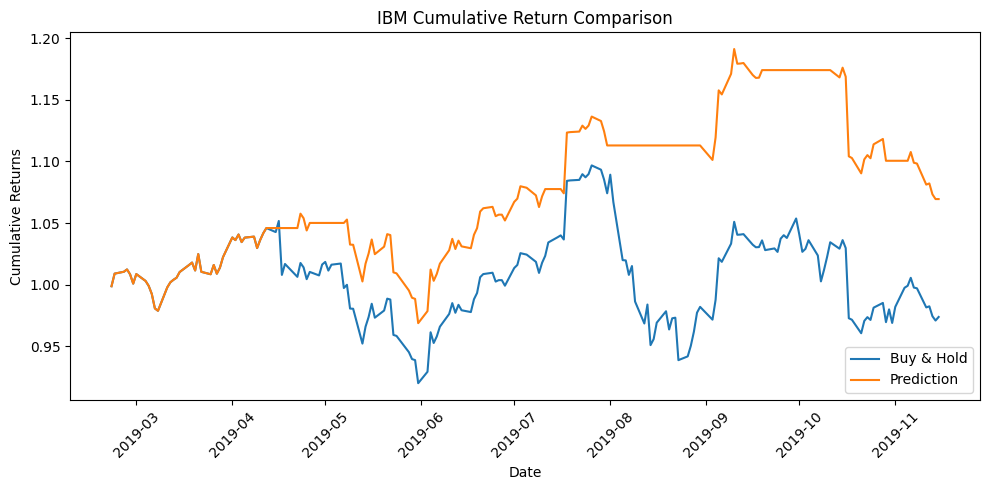

threshold = 0.5
Accuracy: 0.4894
Precision: 0.5349
Recall: 0.6571
F1 Score: 0.5897
AUC Score: 0.4842
Confusion Matrix:
[[23 60]
 [36 69]]
round 6
Epoch [10/15], Loss: 0.6736, minimum Loss: 0.6736, accuracy: 0.5160 maxaccuracy: 0.5213  Validation Loss: 0.6909, Minimum Validation Loss: 0.6908
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018764554872791765


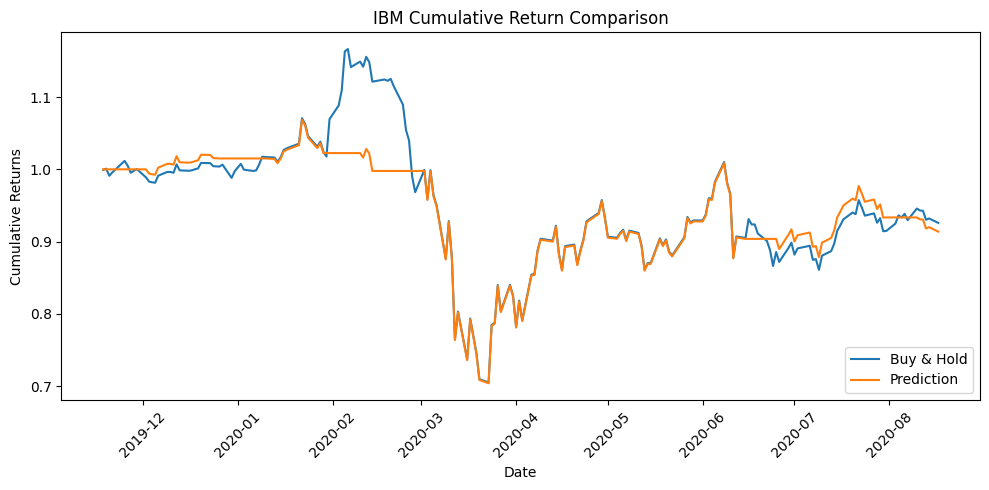

threshold = 0.5
Accuracy: 0.4947
Precision: 0.5000
Recall: 0.7158
F1 Score: 0.5887
AUC Score: 0.5245
Confusion Matrix:
[[25 68]
 [27 68]]
round 7
Epoch [10/15], Loss: 0.6793, minimum Loss: 0.6774, accuracy: 0.5080 maxaccuracy: 0.5187  Validation Loss: 0.6954, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012068685177915024


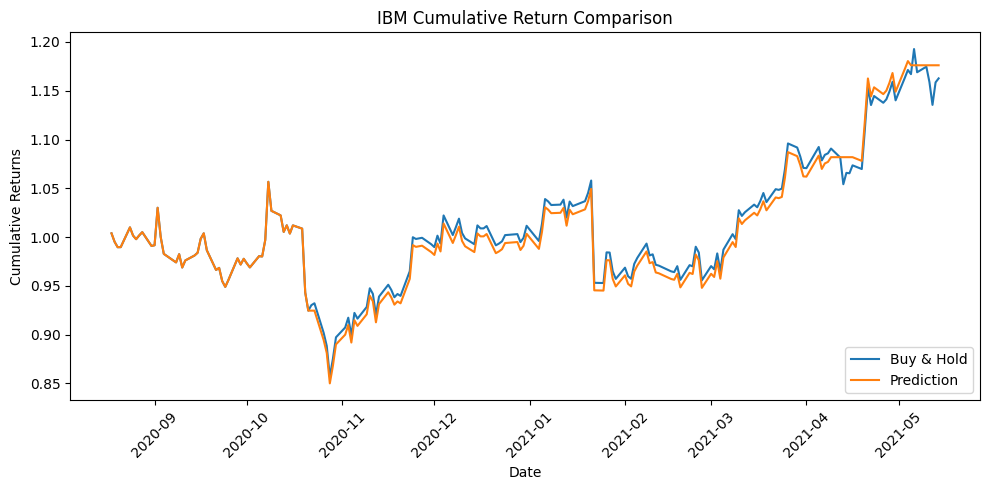

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5145
Recall: 0.9175
F1 Score: 0.6593
AUC Score: 0.4997
Confusion Matrix:
[[ 6 84]
 [ 8 89]]
round 8
Epoch [10/15], Loss: 0.6748, minimum Loss: 0.6741, accuracy: 0.4920 maxaccuracy: 0.4920  Validation Loss: 0.6917, Minimum Validation Loss: 0.6917
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.00517990787733435


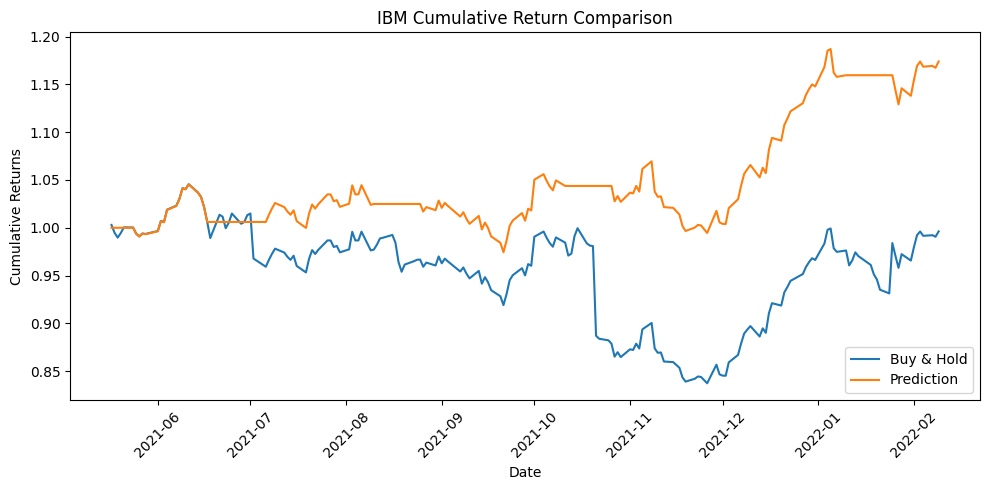

threshold = 0.5
Accuracy: 0.5241
Precision: 0.5182
Recall: 0.7553
F1 Score: 0.6147
AUC Score: 0.5544
Confusion Matrix:
[[27 66]
 [23 71]]
round 9
Epoch [10/15], Loss: 0.6775, minimum Loss: 0.6755, accuracy: 0.4866 maxaccuracy: 0.5134  Validation Loss: 0.6931, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.00804538160967857


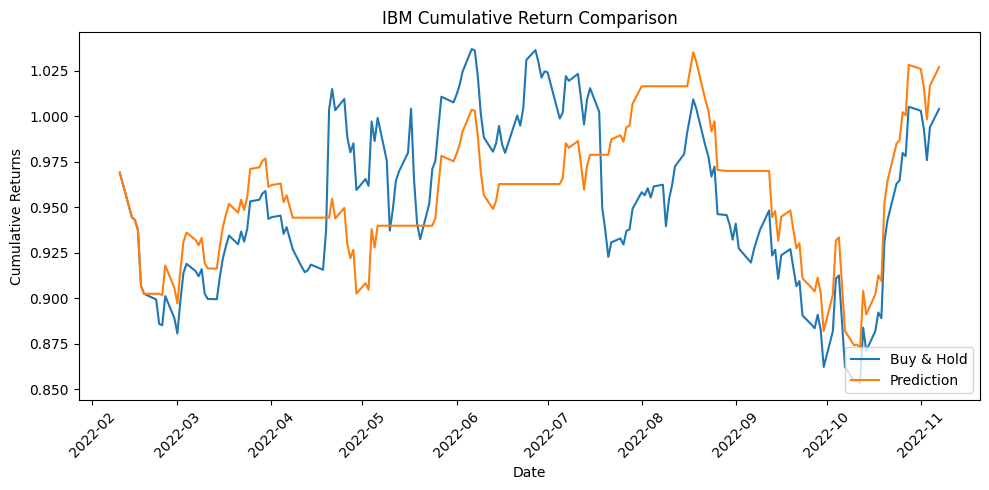

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5154
Recall: 0.6979
F1 Score: 0.5929
AUC Score: 0.4603
Confusion Matrix:
[[28 63]
 [29 67]]
round 10
Epoch [10/15], Loss: 0.6872, minimum Loss: 0.6872, accuracy: 0.5080 maxaccuracy: 0.5508  Validation Loss: 0.6917, Minimum Validation Loss: 0.6898
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.003765220767611022


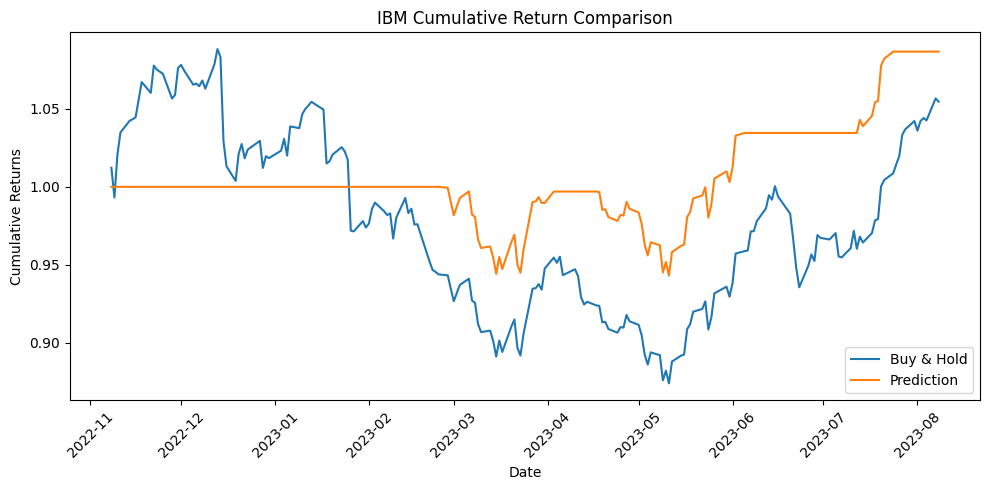

threshold = 0.5
Accuracy: 0.4973
Precision: 0.5672
Recall: 0.3689
F1 Score: 0.4471
AUC Score: 0.5193
Confusion Matrix:
[[55 29]
 [65 38]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009069076042996976


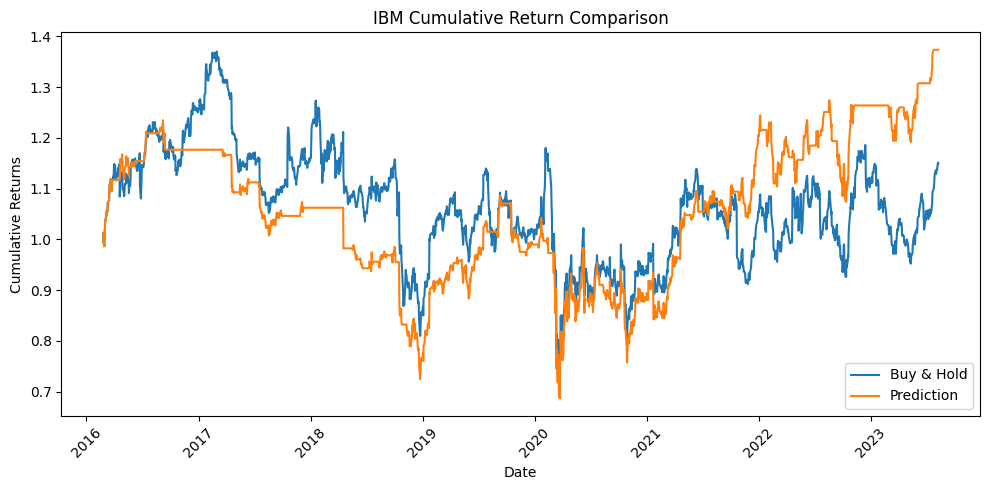

overall results:
Accuracy: 0.5000
Precision: 0.5210
Recall: 0.5687
F1 Score: 0.5438
AUC Score: 0.5033
Confusion Matrix:
[[379 514]
 [424 559]]
0.004356603142083733
Downside deviation list: [0.004091551256180524, 0.00551793399026462, 0.005701985083986989, 0.009725547770339538, 0.006654557913596701, 0.018764554872791765, 0.012068685177915024, 0.00517990787733435, 0.00804538160967857, 0.003765220767611022]
Cumulative return list: [1.176688887625526, 0.8601214322882115, 0.9772994992410436, 0.9219869730022421, 1.0695123561131508, 0.9138753014041701, 1.1760742159292303, 1.174019549547222, 1.0269934928144075, 1.0867598564196497]
Overall downside deviation: 0.009069076042996976
Overall cumulative return: 1.3735926748482123


Training with 500 hidden units, 2 layers, 10 epochs
round 1
Epoch [10/10], Loss: 0.6721, minimum Loss: 0.6721, accuracy: 0.4787 maxaccuracy: 0.5585  Validation Loss: 0.6938, Minimum Validation Loss: 0.6898
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction Down

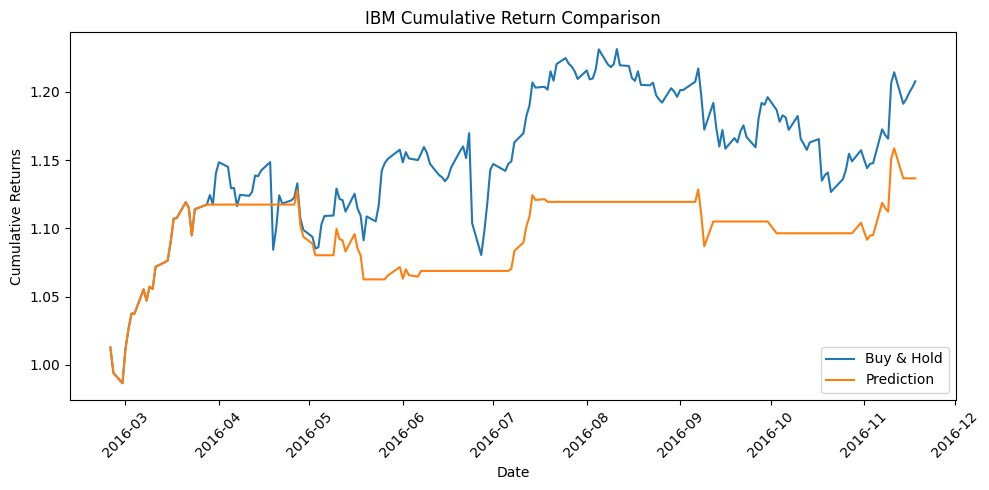

threshold = 0.5
Accuracy: 0.4787
Precision: 0.5522
Recall: 0.3524
F1 Score: 0.4302
AUC Score: 0.5255
Confusion Matrix:
[[53 30]
 [68 37]]
round 2
Epoch [10/10], Loss: 0.6614, minimum Loss: 0.6614, accuracy: 0.4947 maxaccuracy: 0.4840  Validation Loss: 0.7050, Minimum Validation Loss: 0.6940
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.0061233792726948155


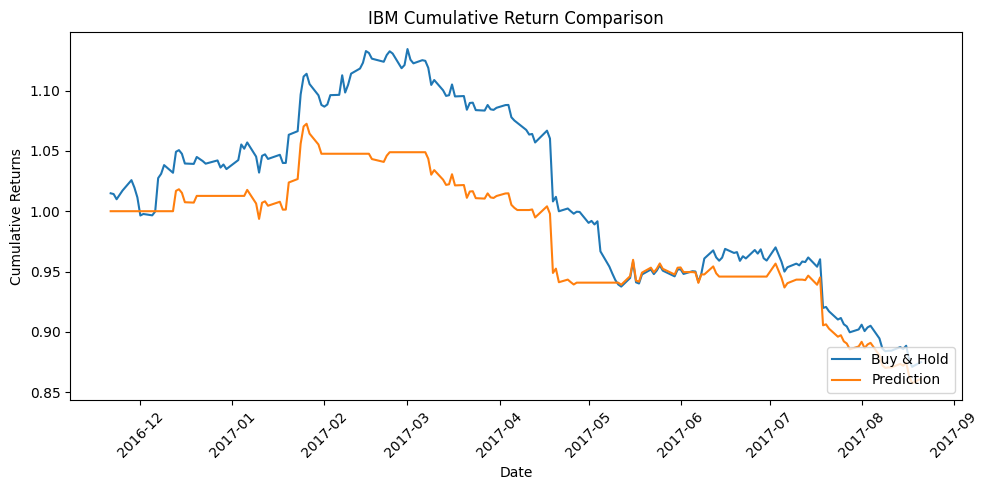

threshold = 0.5
Accuracy: 0.4947
Precision: 0.4783
Recall: 0.6111
F1 Score: 0.5366
AUC Score: 0.4575
Confusion Matrix:
[[38 60]
 [35 55]]
round 3
Epoch [10/10], Loss: 0.6794, minimum Loss: 0.6794, accuracy: 0.4840 maxaccuracy: 0.5213  Validation Loss: 0.6927, Minimum Validation Loss: 0.6926
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.00625380096351608


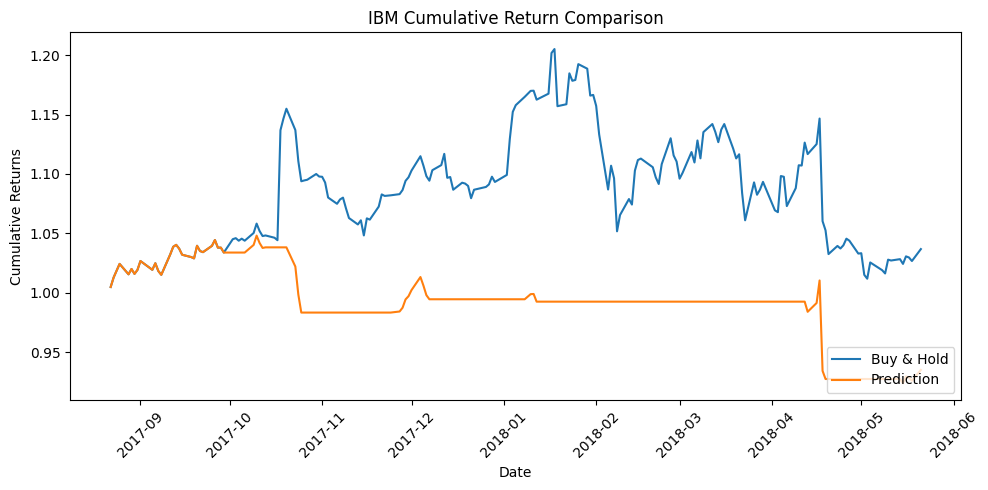

threshold = 0.5
Accuracy: 0.4840
Precision: 0.5085
Recall: 0.3061
F1 Score: 0.3822
AUC Score: 0.5305
Confusion Matrix:
[[61 29]
 [68 30]]
round 4
Epoch [10/10], Loss: 0.6652, minimum Loss: 0.6652, accuracy: 0.5000 maxaccuracy: 0.5585  Validation Loss: 0.6911, Minimum Validation Loss: 0.6897
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.00854460983739729


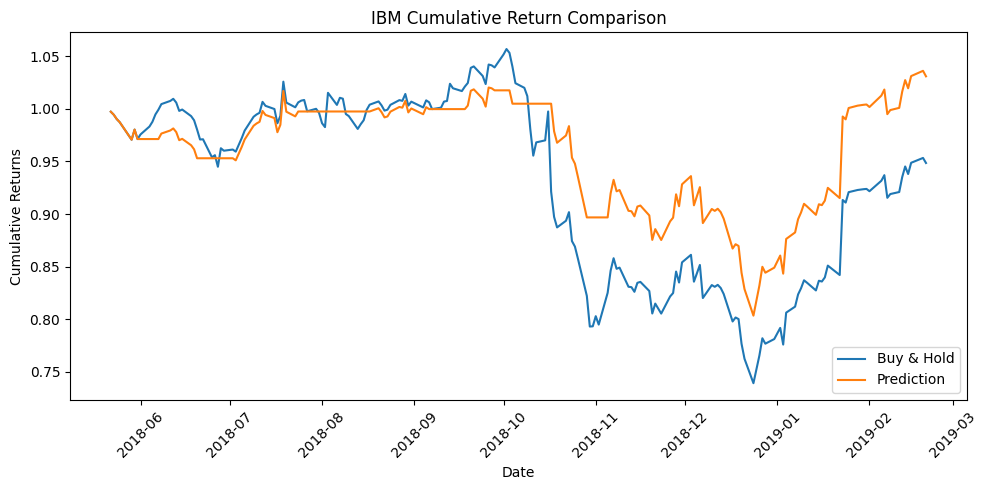

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5227
Recall: 0.6900
F1 Score: 0.5948
AUC Score: 0.5164
Confusion Matrix:
[[25 63]
 [31 69]]
round 5
Epoch [10/10], Loss: 0.6750, minimum Loss: 0.6750, accuracy: 0.5053 maxaccuracy: 0.5585  Validation Loss: 0.6935, Minimum Validation Loss: 0.6905
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.0059397610133057445


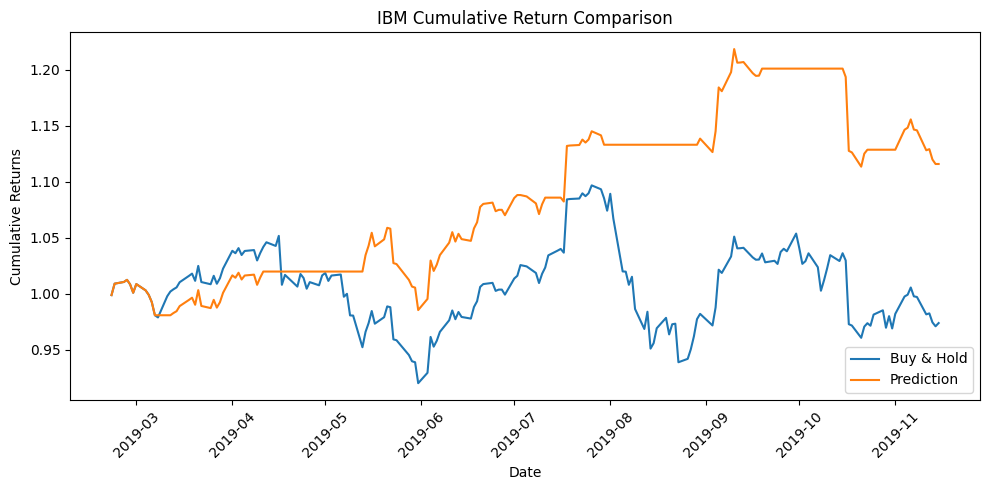

threshold = 0.5
Accuracy: 0.5053
Precision: 0.5536
Recall: 0.5905
F1 Score: 0.5714
AUC Score: 0.4841
Confusion Matrix:
[[33 50]
 [43 62]]
round 6
Epoch [10/10], Loss: 0.6701, minimum Loss: 0.6701, accuracy: 0.5213 maxaccuracy: 0.5160  Validation Loss: 0.6954, Minimum Validation Loss: 0.6910
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018848460047400716


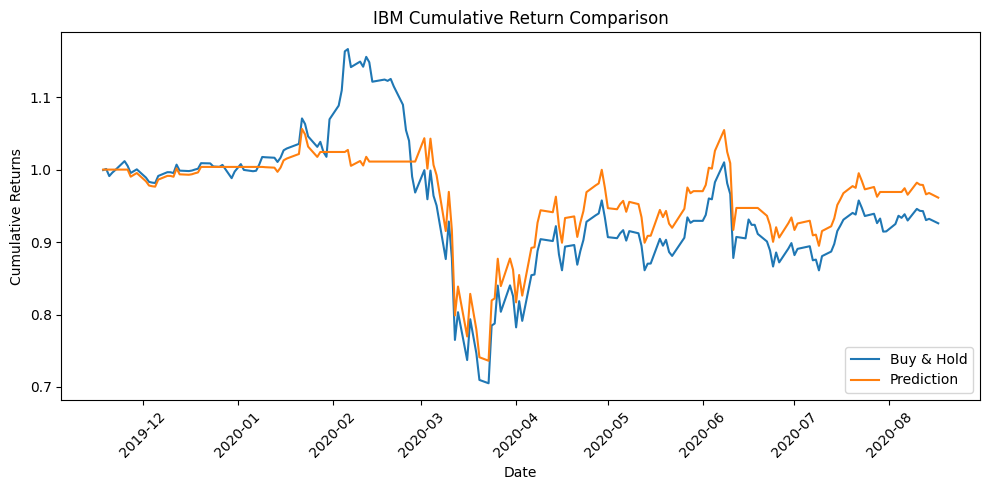

threshold = 0.5
Accuracy: 0.5213
Precision: 0.5175
Recall: 0.7789
F1 Score: 0.6218
AUC Score: 0.5033
Confusion Matrix:
[[24 69]
 [21 74]]
round 7
Epoch [10/10], Loss: 0.6716, minimum Loss: 0.6716, accuracy: 0.5080 maxaccuracy: 0.5187  Validation Loss: 0.6963, Minimum Validation Loss: 0.6928
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012350782783967548


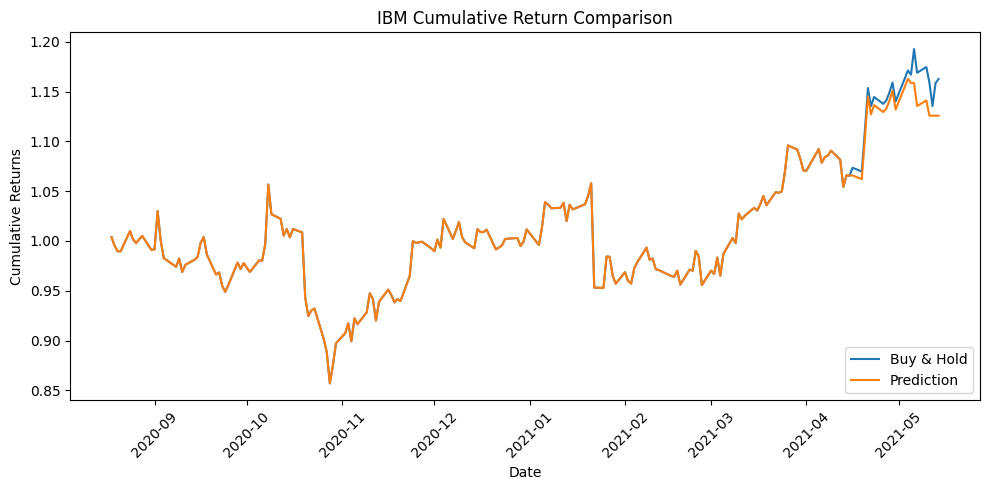

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5138
Recall: 0.9588
F1 Score: 0.6691
AUC Score: 0.4566
Confusion Matrix:
[[ 2 88]
 [ 4 93]]
round 8
Epoch [10/10], Loss: 0.6782, minimum Loss: 0.6764, accuracy: 0.5348 maxaccuracy: 0.5348  Validation Loss: 0.6905, Minimum Validation Loss: 0.6905
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.00515730281156427


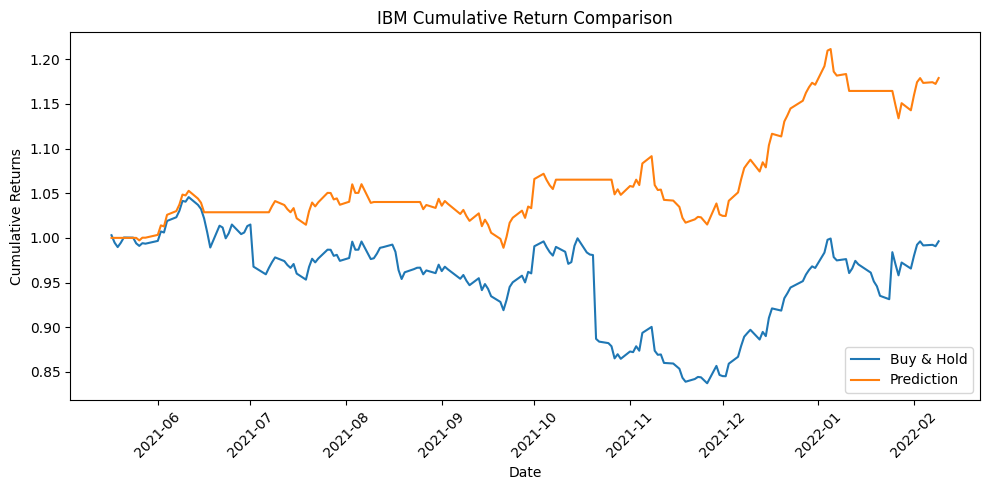

threshold = 0.5
Accuracy: 0.5348
Precision: 0.5263
Recall: 0.7447
F1 Score: 0.6167
AUC Score: 0.5646
Confusion Matrix:
[[30 63]
 [24 70]]
round 9
Epoch [10/10], Loss: 0.6774, minimum Loss: 0.6774, accuracy: 0.4920 maxaccuracy: 0.4706  Validation Loss: 0.6929, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.007905976393521955


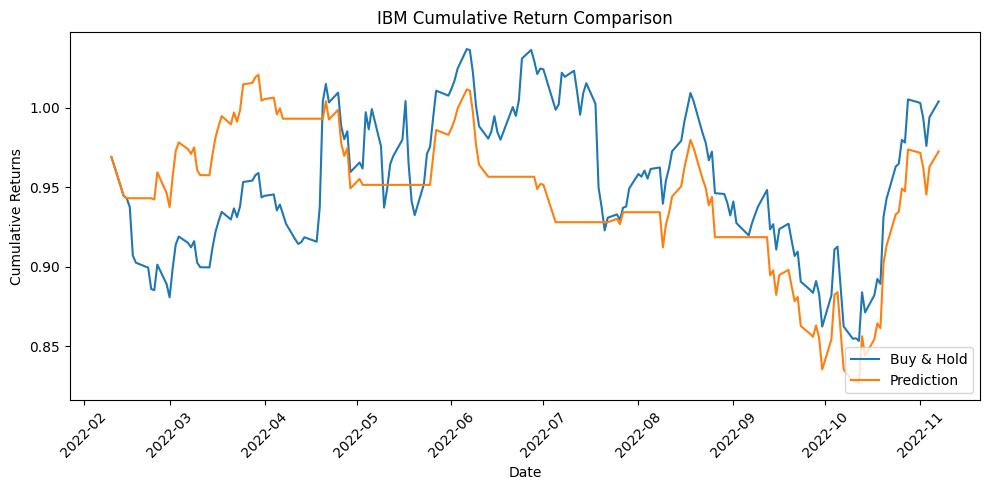

threshold = 0.5
Accuracy: 0.4920
Precision: 0.5043
Recall: 0.6146
F1 Score: 0.5540
AUC Score: 0.5092
Confusion Matrix:
[[33 58]
 [37 59]]
round 10
Epoch [10/10], Loss: 0.6864, minimum Loss: 0.6864, accuracy: 0.4706 maxaccuracy: 0.5508  Validation Loss: 0.6936, Minimum Validation Loss: 0.6902
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.004048825429101496


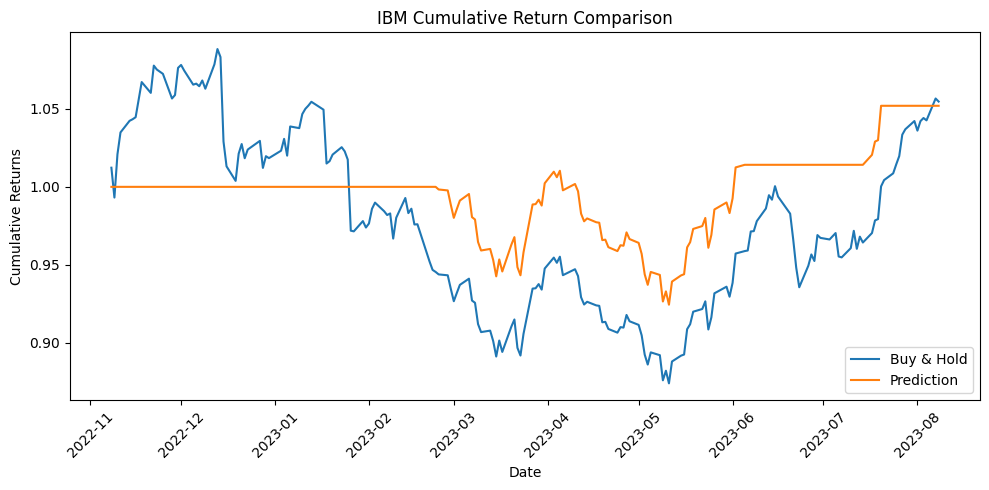

threshold = 0.5
Accuracy: 0.4706
Precision: 0.5270
Recall: 0.3786
F1 Score: 0.4407
AUC Score: 0.5229
Confusion Matrix:
[[49 35]
 [64 39]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009032059344982586


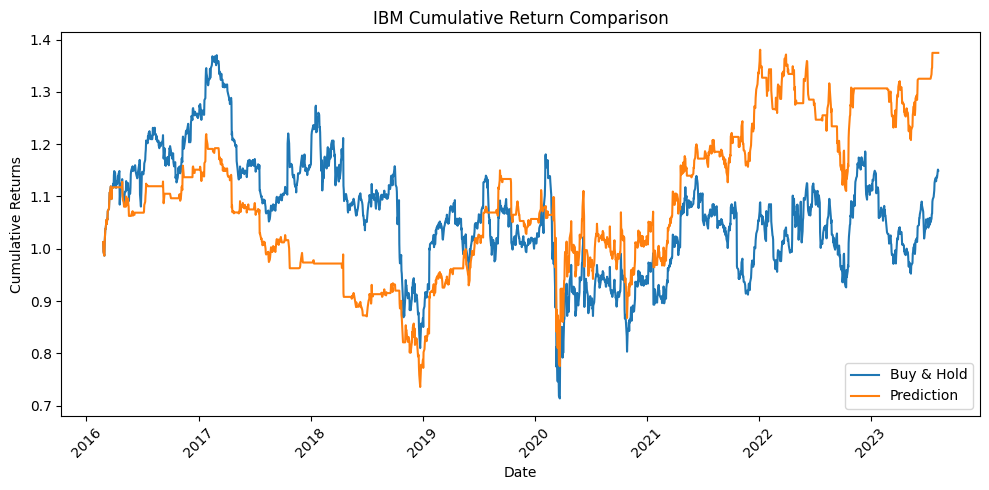

overall results:
Accuracy: 0.4989
Precision: 0.5190
Recall: 0.5982
F1 Score: 0.5558
AUC Score: 0.4996
Confusion Matrix:
[[348 545]
 [395 588]]
0.004315223640264495
Downside deviation list: [0.004149623017933129, 0.0061233792726948155, 0.00625380096351608, 0.00854460983739729, 0.0059397610133057445, 0.018848460047400716, 0.012350782783967548, 0.00515730281156427, 0.007905976393521955, 0.004048825429101496]
Cumulative return list: [1.1367046106966279, 0.8612278047725025, 0.9350558521002847, 1.0308493675949937, 1.1158990338599022, 0.9613148181500609, 1.1258156422685999, 1.1788932200560347, 0.9725296236035589, 1.052004325759458]
Overall downside deviation: 0.009032059344982586
Overall cumulative return: 1.3745200432443545


Training with 500 hidden units, 2 layers, 15 epochs
round 1
Epoch [10/15], Loss: 0.6733, minimum Loss: 0.6733, accuracy: 0.4787 maxaccuracy: 0.5585  Validation Loss: 0.6946, Minimum Validation Loss: 0.6901
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction D

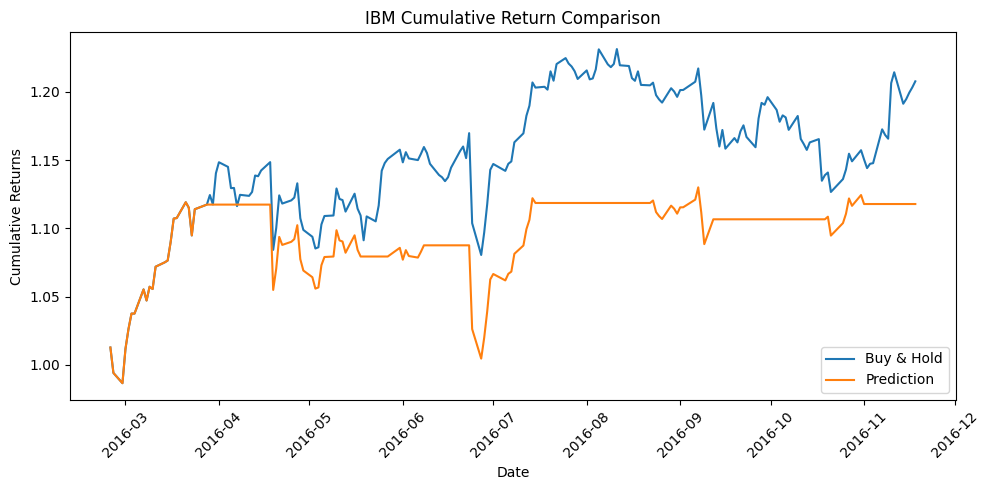

threshold = 0.5
Accuracy: 0.5426
Precision: 0.6067
Recall: 0.5143
F1 Score: 0.5567
AUC Score: 0.5245
Confusion Matrix:
[[48 35]
 [51 54]]
round 2
Epoch [10/15], Loss: 0.6678, minimum Loss: 0.6678, accuracy: 0.4947 maxaccuracy: 0.4681  Validation Loss: 0.7006, Minimum Validation Loss: 0.6940
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.005823470338626345


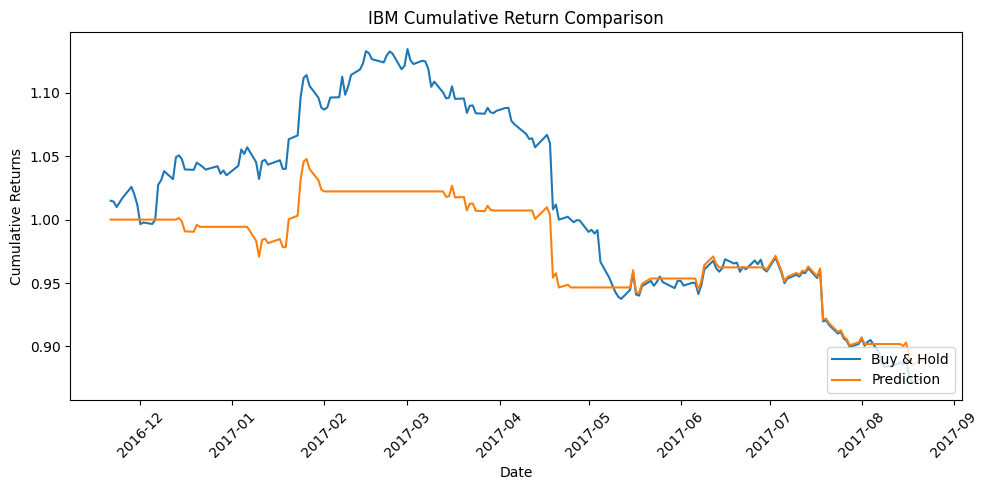

threshold = 0.5
Accuracy: 0.4787
Precision: 0.4524
Recall: 0.4222
F1 Score: 0.4368
AUC Score: 0.4771
Confusion Matrix:
[[52 46]
 [52 38]]
round 3
Epoch [10/15], Loss: 0.6795, minimum Loss: 0.6795, accuracy: 0.4947 maxaccuracy: 0.4947  Validation Loss: 0.6925, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.006658886243005134


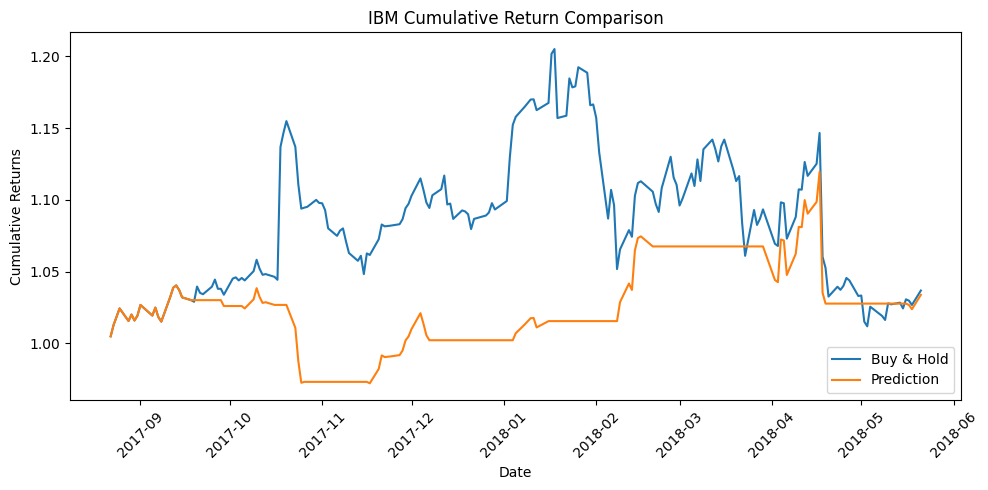

threshold = 0.5
Accuracy: 0.5213
Precision: 0.5526
Recall: 0.4286
F1 Score: 0.4828
AUC Score: 0.5669
Confusion Matrix:
[[56 34]
 [56 42]]
round 4
Epoch [10/15], Loss: 0.6649, minimum Loss: 0.6649, accuracy: 0.5266 maxaccuracy: 0.5691  Validation Loss: 0.6905, Minimum Validation Loss: 0.6895
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.010017126649800893


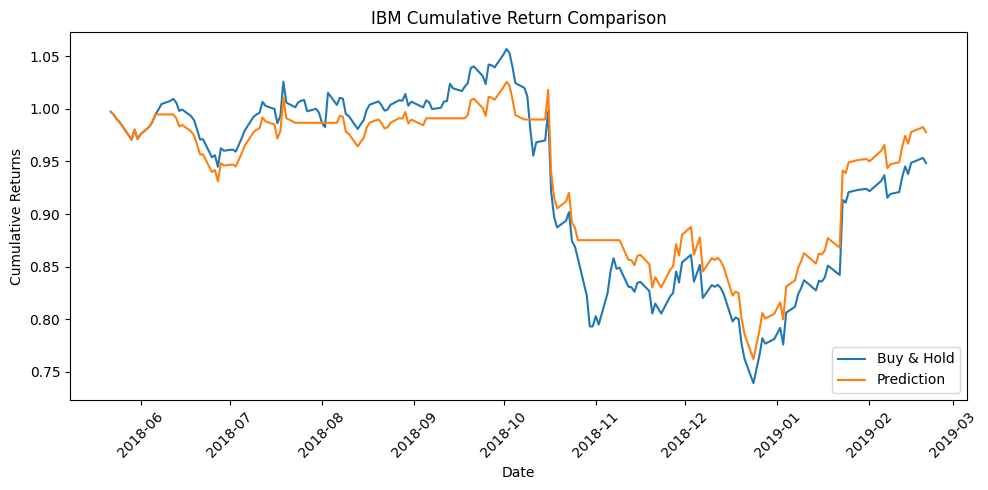

threshold = 0.5
Accuracy: 0.5000
Precision: 0.5200
Recall: 0.7800
F1 Score: 0.6240
AUC Score: 0.4565
Confusion Matrix:
[[16 72]
 [22 78]]
round 5
Epoch [10/15], Loss: 0.6732, minimum Loss: 0.6732, accuracy: 0.5000 maxaccuracy: 0.5585  Validation Loss: 0.6934, Minimum Validation Loss: 0.6906
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.0062226154693691554


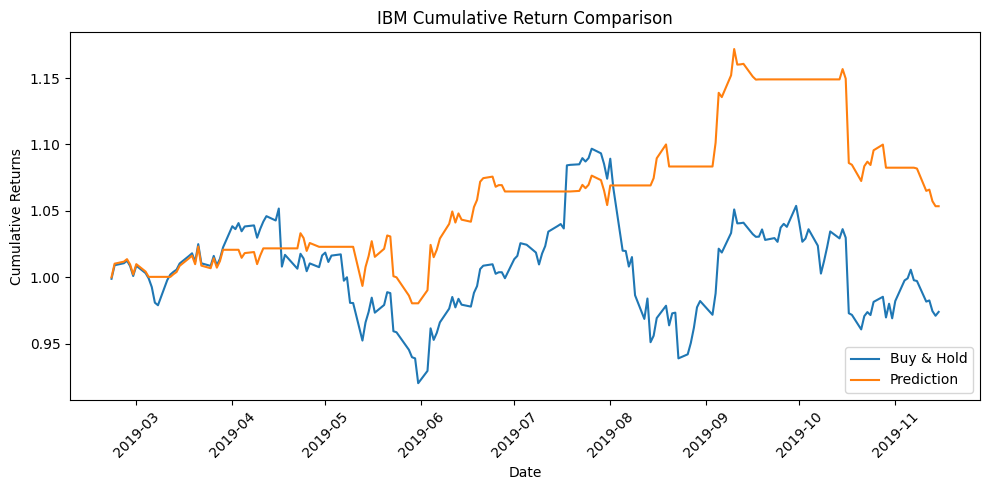

threshold = 0.5
Accuracy: 0.5053
Precision: 0.5577
Recall: 0.5524
F1 Score: 0.5550
AUC Score: 0.4906
Confusion Matrix:
[[37 46]
 [47 58]]
round 6
Epoch [10/15], Loss: 0.6700, minimum Loss: 0.6700, accuracy: 0.4894 maxaccuracy: 0.5160  Validation Loss: 0.6933, Minimum Validation Loss: 0.6911
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018651472794587468


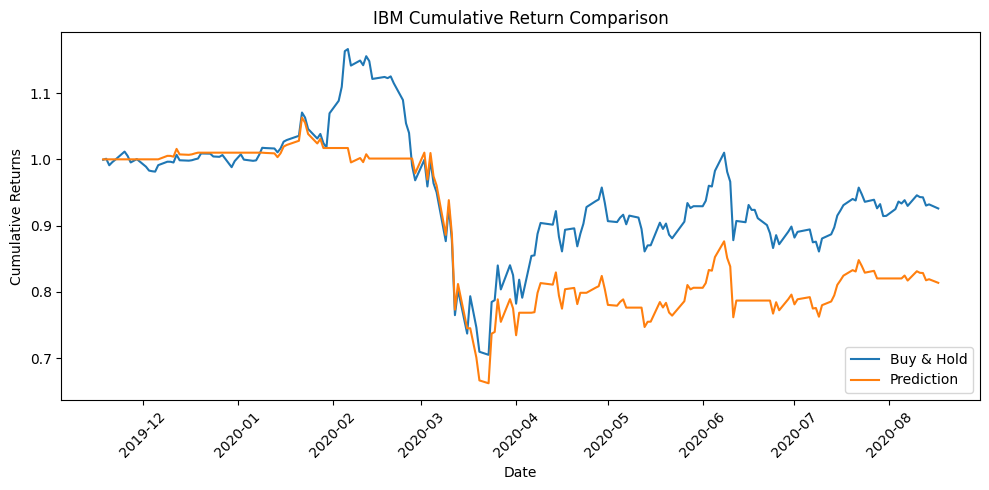

threshold = 0.5
Accuracy: 0.5106
Precision: 0.5120
Recall: 0.6737
F1 Score: 0.5818
AUC Score: 0.4893
Confusion Matrix:
[[32 61]
 [31 64]]
round 7
Epoch [10/15], Loss: 0.6716, minimum Loss: 0.6716, accuracy: 0.5027 maxaccuracy: 0.5187  Validation Loss: 0.6966, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.010553946402662478


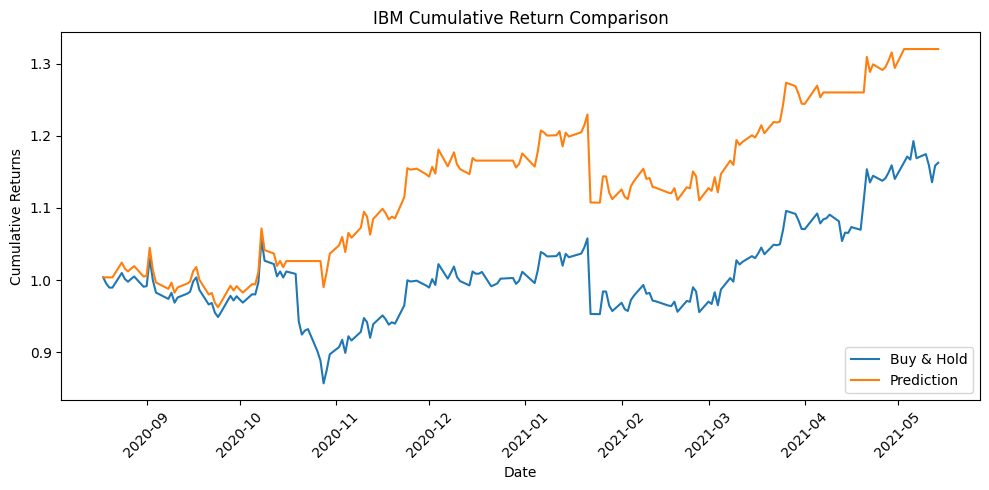

threshold = 0.5
Accuracy: 0.5080
Precision: 0.5163
Recall: 0.8144
F1 Score: 0.6320
AUC Score: 0.4922
Confusion Matrix:
[[16 74]
 [18 79]]
round 8
Epoch [10/15], Loss: 0.6778, minimum Loss: 0.6768, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6907, Minimum Validation Loss: 0.6907
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.0041333621399092775


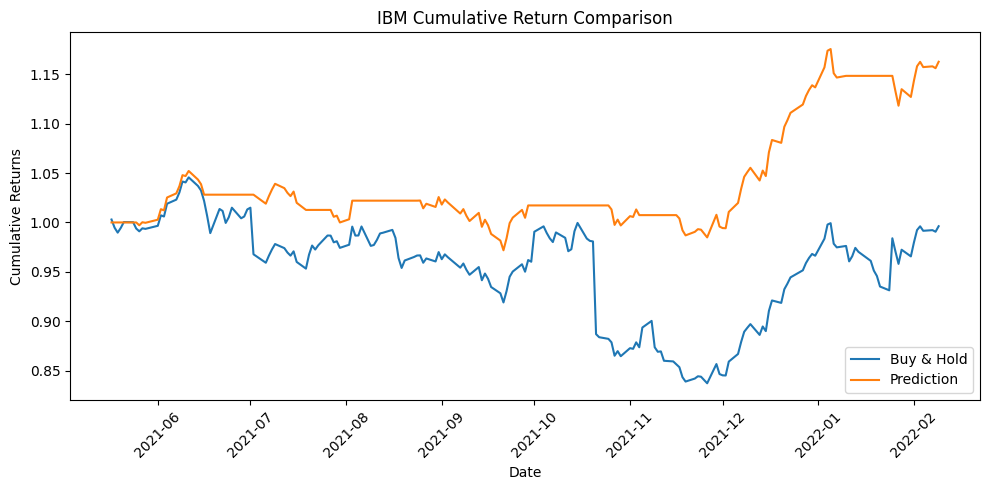

threshold = 0.5
Accuracy: 0.5348
Precision: 0.5315
Recall: 0.6277
F1 Score: 0.5756
AUC Score: 0.5365
Confusion Matrix:
[[41 52]
 [35 59]]
round 9
Epoch [10/15], Loss: 0.6758, minimum Loss: 0.6758, accuracy: 0.4973 maxaccuracy: 0.5134  Validation Loss: 0.6932, Minimum Validation Loss: 0.6930
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.008282966721794271


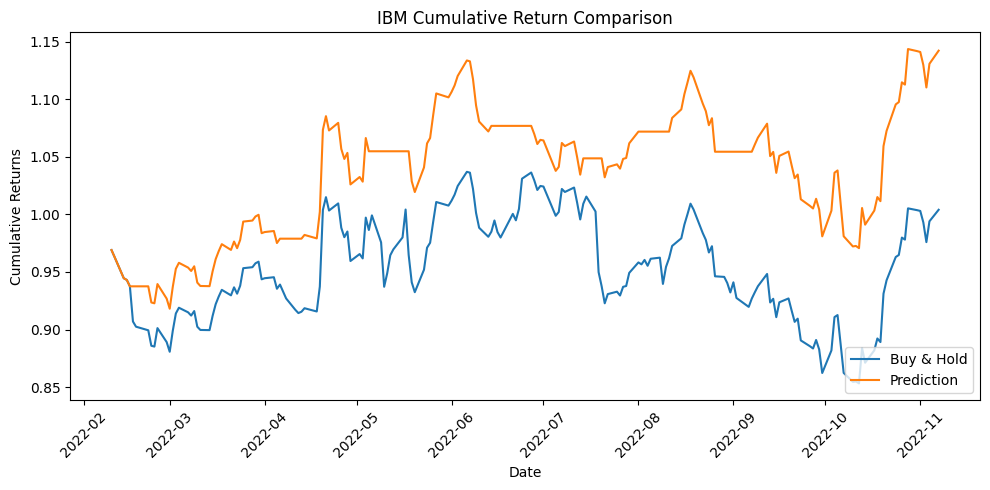

threshold = 0.5
Accuracy: 0.5348
Precision: 0.5315
Recall: 0.7917
F1 Score: 0.6360
AUC Score: 0.5374
Confusion Matrix:
[[24 67]
 [20 76]]
round 10
Epoch [10/15], Loss: 0.6873, minimum Loss: 0.6868, accuracy: 0.4866 maxaccuracy: 0.5508  Validation Loss: 0.6934, Minimum Validation Loss: 0.6899
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.00343995429997699


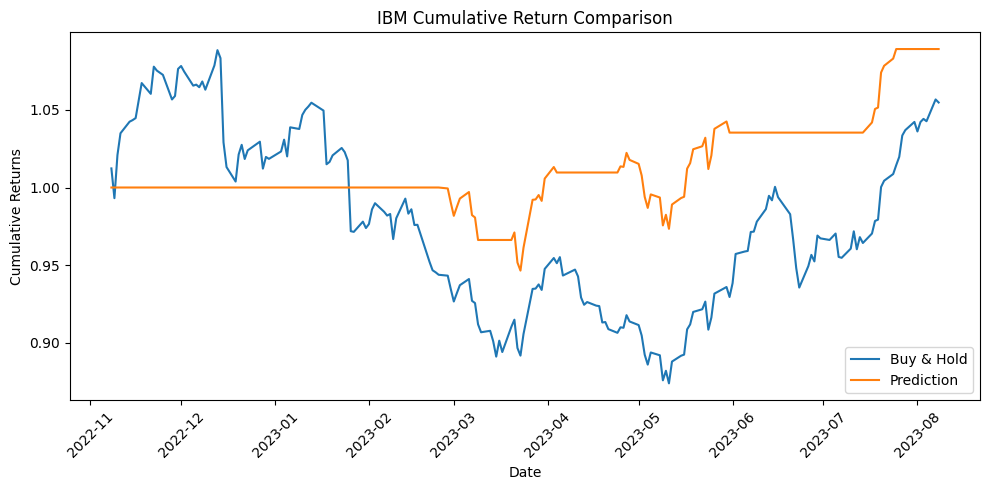

threshold = 0.5
Accuracy: 0.5080
Precision: 0.6038
Recall: 0.3107
F1 Score: 0.4103
AUC Score: 0.5267
Confusion Matrix:
[[63 21]
 [71 32]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009086220853382038


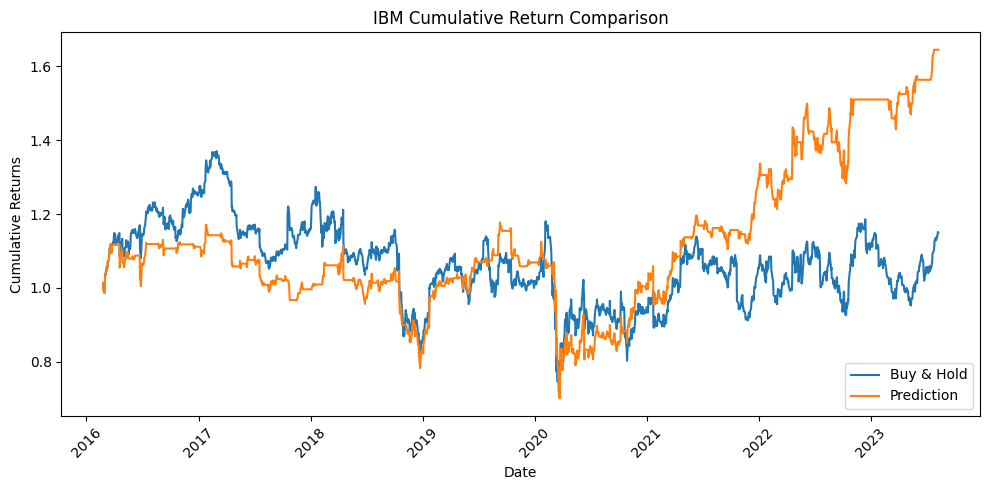

overall results:
Accuracy: 0.5144
Precision: 0.5331
Recall: 0.5900
F1 Score: 0.5601
AUC Score: 0.5057
Confusion Matrix:
[[385 508]
 [403 580]]
0.004125989241545117
Downside deviation list: [0.0071304046671440266, 0.005823470338626345, 0.006658886243005134, 0.010017126649800893, 0.0062226154693691554, 0.018651472794587468, 0.010553946402662478, 0.0041333621399092775, 0.008282966721794271, 0.00343995429997699]
Cumulative return list: [1.1178936063955924, 0.8893105348441428, 1.0337692293025507, 0.9776786041999348, 1.0535039788652305, 0.8137370743182533, 1.3201116589545747, 1.162581923359142, 1.1421594634199586, 1.0891177594589534]
Overall downside deviation: 0.009086220853382038
Overall cumulative return: 1.6444842548275973


Training with 500 hidden units, 3 layers, 10 epochs
round 1
Epoch [10/10], Loss: 0.6679, minimum Loss: 0.6679, accuracy: 0.5319 maxaccuracy: 0.5585  Validation Loss: 0.6935, Minimum Validation Loss: 0.6896
Buy & Hold Downside Deviation: 0.008282071291187252
Predictio

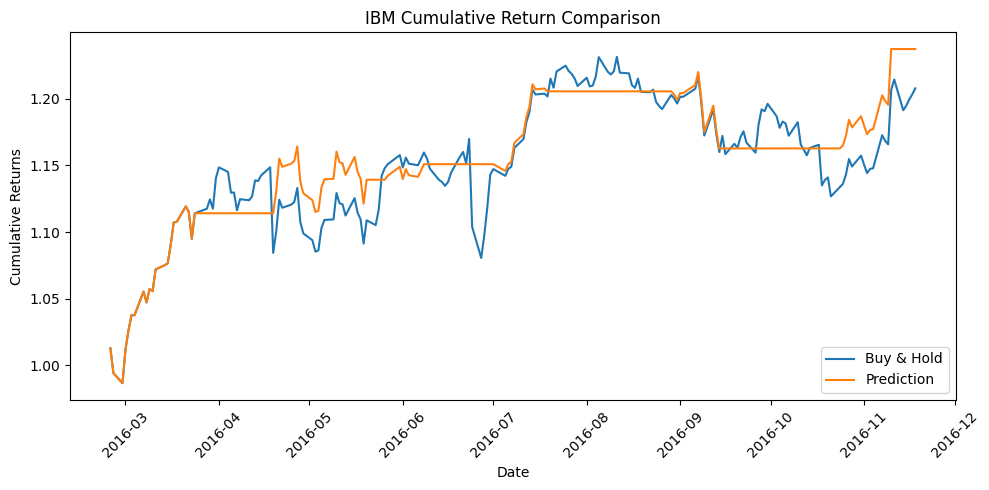

threshold = 0.5
Accuracy: 0.5319
Precision: 0.5977
Recall: 0.4952
F1 Score: 0.5417
AUC Score: 0.5312
Confusion Matrix:
[[48 35]
 [53 52]]
round 2
Epoch [10/10], Loss: 0.6631, minimum Loss: 0.6631, accuracy: 0.4468 maxaccuracy: 0.4468  Validation Loss: 0.7018, Minimum Validation Loss: 0.6943
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.006111642196671793


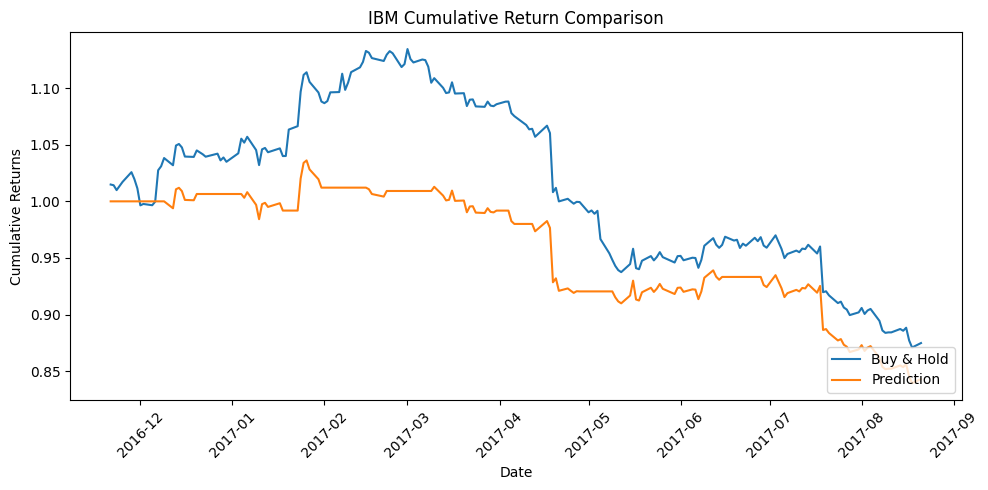

threshold = 0.5
Accuracy: 0.4468
Precision: 0.4407
Recall: 0.5778
F1 Score: 0.5000
AUC Score: 0.4494
Confusion Matrix:
[[32 66]
 [38 52]]
round 3
Epoch [10/10], Loss: 0.6817, minimum Loss: 0.6808, accuracy: 0.4894 maxaccuracy: 0.5213  Validation Loss: 0.6928, Minimum Validation Loss: 0.6924
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.00575754074127369


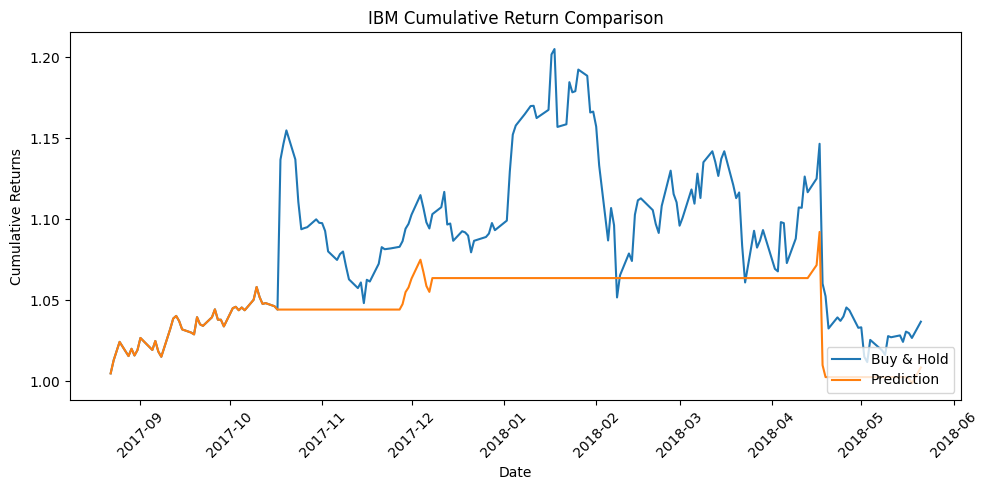

threshold = 0.5
Accuracy: 0.4894
Precision: 0.5179
Recall: 0.2959
F1 Score: 0.3766
AUC Score: 0.5287
Confusion Matrix:
[[63 27]
 [69 29]]
round 4
Epoch [10/10], Loss: 0.6647, minimum Loss: 0.6647, accuracy: 0.5160 maxaccuracy: 0.5479  Validation Loss: 0.6913, Minimum Validation Loss: 0.6899
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.01072364355928707


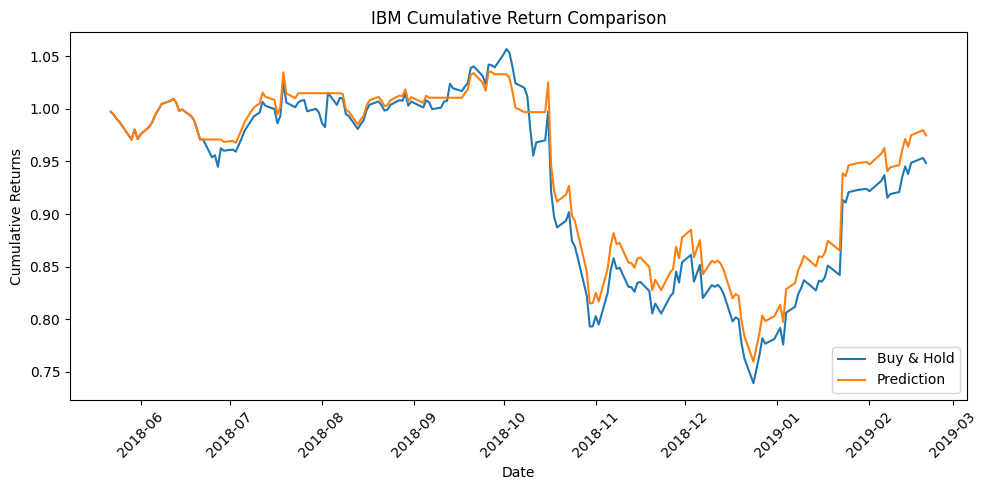

threshold = 0.5
Accuracy: 0.5160
Precision: 0.5283
Recall: 0.8400
F1 Score: 0.6486
AUC Score: 0.5043
Confusion Matrix:
[[13 75]
 [16 84]]
round 5
Epoch [10/10], Loss: 0.6752, minimum Loss: 0.6752, accuracy: 0.5160 maxaccuracy: 0.5585  Validation Loss: 0.6922, Minimum Validation Loss: 0.6905
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.007509275001981589


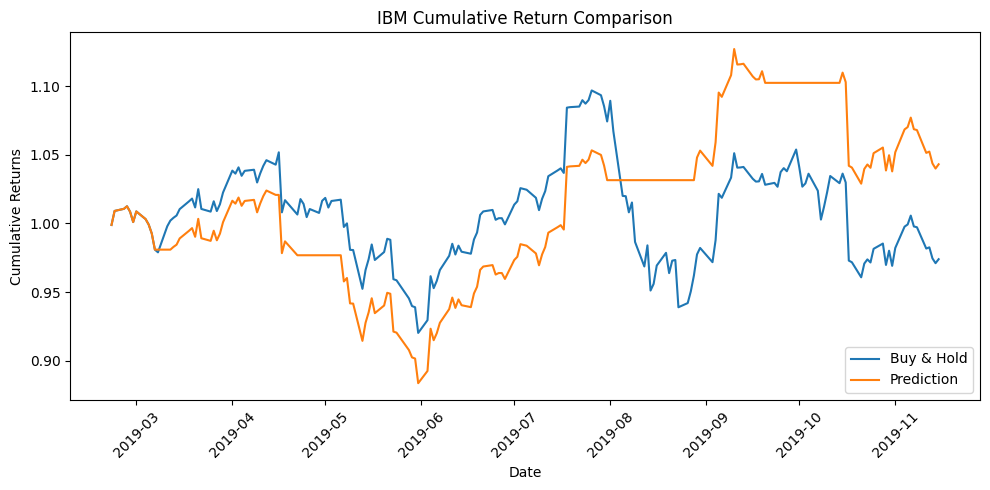

threshold = 0.5
Accuracy: 0.5160
Precision: 0.5507
Recall: 0.7238
F1 Score: 0.6255
AUC Score: 0.4857
Confusion Matrix:
[[21 62]
 [29 76]]
round 6
Epoch [10/10], Loss: 0.6651, minimum Loss: 0.6651, accuracy: 0.4894 maxaccuracy: 0.5213  Validation Loss: 0.6947, Minimum Validation Loss: 0.6912
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018962666860439025


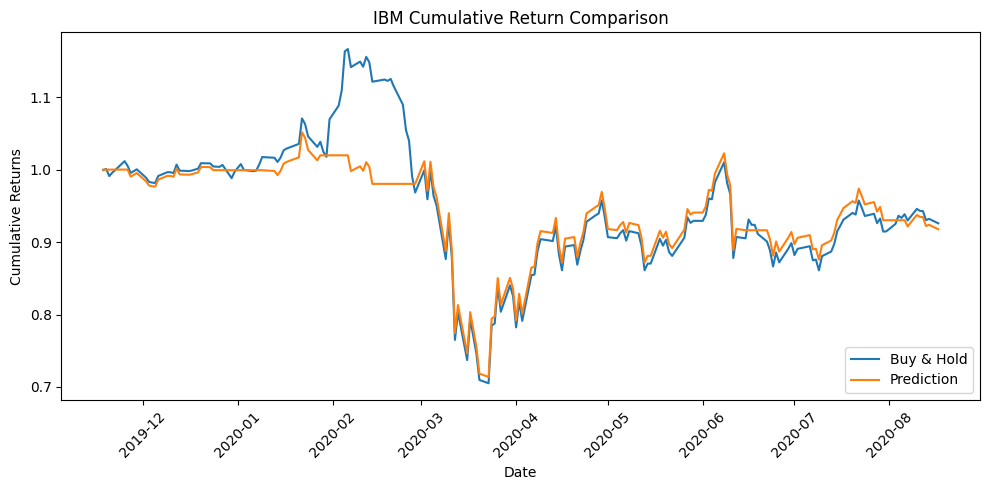

threshold = 0.5
Accuracy: 0.4894
Precision: 0.4966
Recall: 0.7579
F1 Score: 0.6000
AUC Score: 0.5124
Confusion Matrix:
[[20 73]
 [23 72]]
round 7
Epoch [10/10], Loss: 0.6784, minimum Loss: 0.6738, accuracy: 0.5241 maxaccuracy: 0.5187  Validation Loss: 0.6950, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.012219912090566326


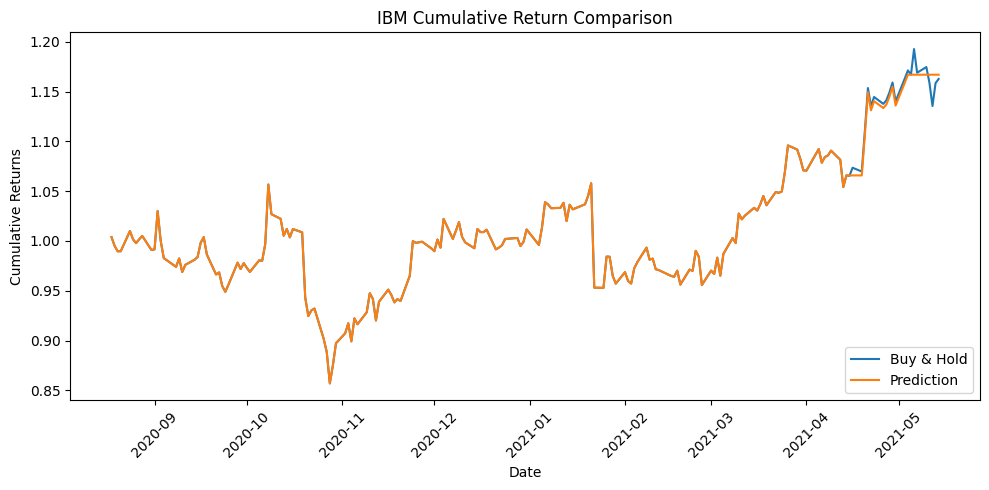

threshold = 0.5
Accuracy: 0.5241
Precision: 0.5227
Recall: 0.9485
F1 Score: 0.6740
AUC Score: 0.4676
Confusion Matrix:
[[ 6 84]
 [ 5 92]]
round 8
Epoch [10/10], Loss: 0.6765, minimum Loss: 0.6765, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6917, Minimum Validation Loss: 0.6916
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.006405009478027434


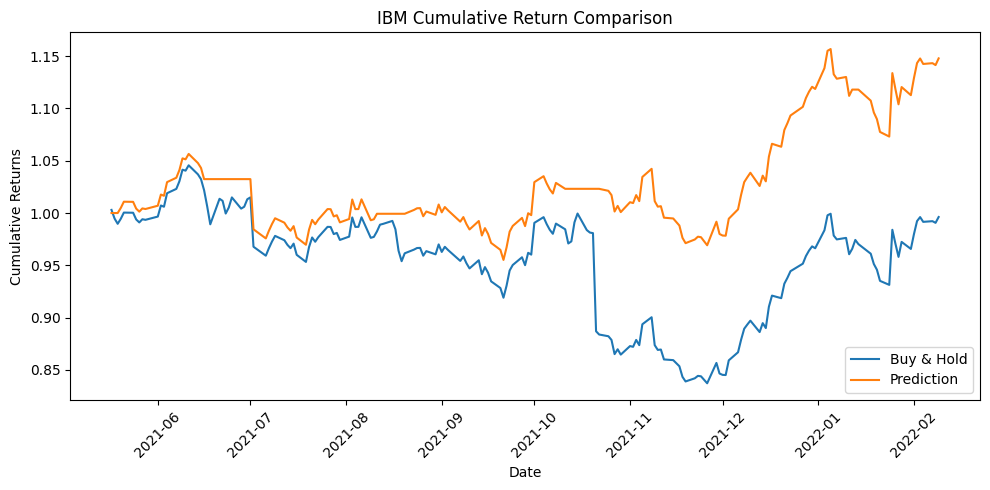

threshold = 0.5
Accuracy: 0.5134
Precision: 0.5097
Recall: 0.8404
F1 Score: 0.6345
AUC Score: 0.5490
Confusion Matrix:
[[17 76]
 [15 79]]
round 9
Epoch [10/10], Loss: 0.6725, minimum Loss: 0.6725, accuracy: 0.4920 maxaccuracy: 0.5134  Validation Loss: 0.6936, Minimum Validation Loss: 0.6929
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.008297694782562027


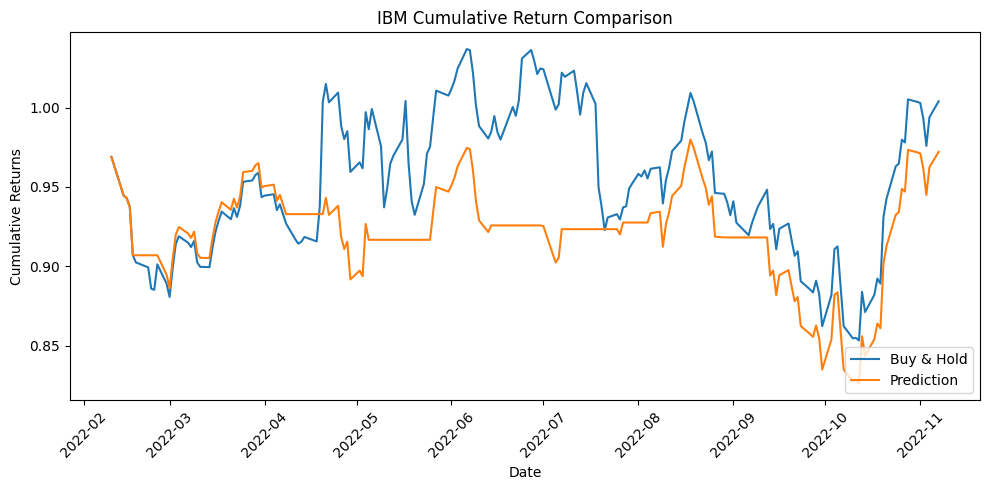

threshold = 0.5
Accuracy: 0.4920
Precision: 0.5041
Recall: 0.6458
F1 Score: 0.5662
AUC Score: 0.5002
Confusion Matrix:
[[30 61]
 [34 62]]
round 10
Epoch [10/10], Loss: 0.6872, minimum Loss: 0.6872, accuracy: 0.4973 maxaccuracy: 0.5508  Validation Loss: 0.6930, Minimum Validation Loss: 0.6900
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.0038833089449595752


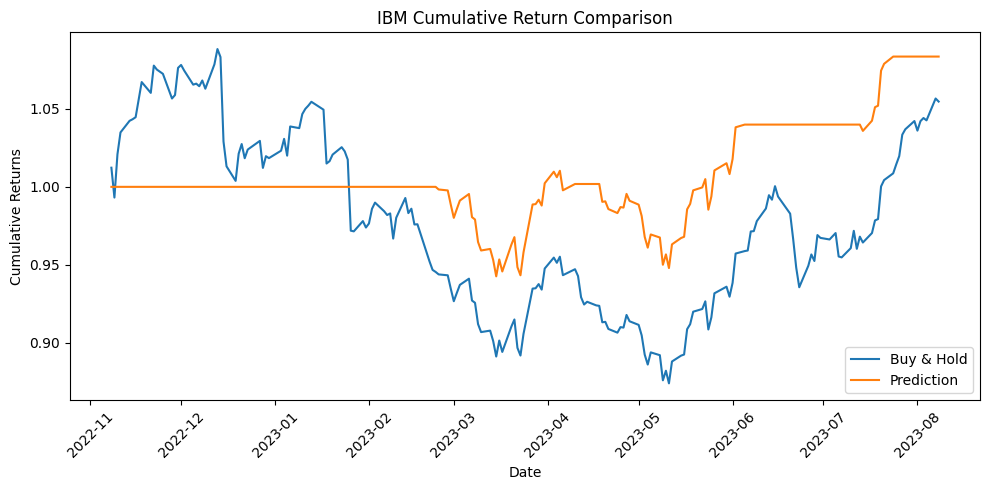

threshold = 0.5
Accuracy: 0.4973
Precision: 0.5634
Recall: 0.3883
F1 Score: 0.4598
AUC Score: 0.5193
Confusion Matrix:
[[53 31]
 [63 40]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.009453129231416932


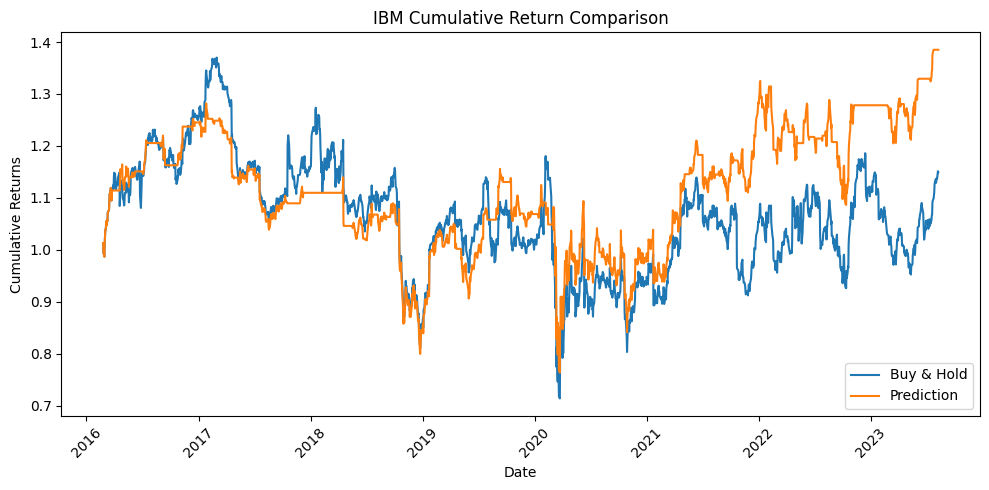

overall results:
Accuracy: 0.5016
Precision: 0.5195
Recall: 0.6490
F1 Score: 0.5771
AUC Score: 0.4958
Confusion Matrix:
[[303 590]
 [345 638]]
0.004322310011086153
Downside deviation list: [0.0041739683159604905, 0.006111642196671793, 0.00575754074127369, 0.01072364355928707, 0.007509275001981589, 0.018962666860439025, 0.012219912090566326, 0.006405009478027434, 0.008297694782562027, 0.0038833089449595752]
Cumulative return list: [1.2372233717715493, 0.8432107419361117, 1.0085019202023444, 0.9747507469856469, 1.0430359144463721, 0.9177361180663336, 1.1669359362115606, 1.1478104378610459, 0.9721785796490375, 1.0835803332679892]
Overall downside deviation: 0.009453129231416932
Overall cumulative return: 1.3851473793667923


Training with 500 hidden units, 3 layers, 15 epochs
round 1
Epoch [10/15], Loss: 0.6713, minimum Loss: 0.6713, accuracy: 0.5160 maxaccuracy: 0.5585  Validation Loss: 0.6941, Minimum Validation Loss: 0.6896
Buy & Hold Downside Deviation: 0.008282071291187252
Prediction

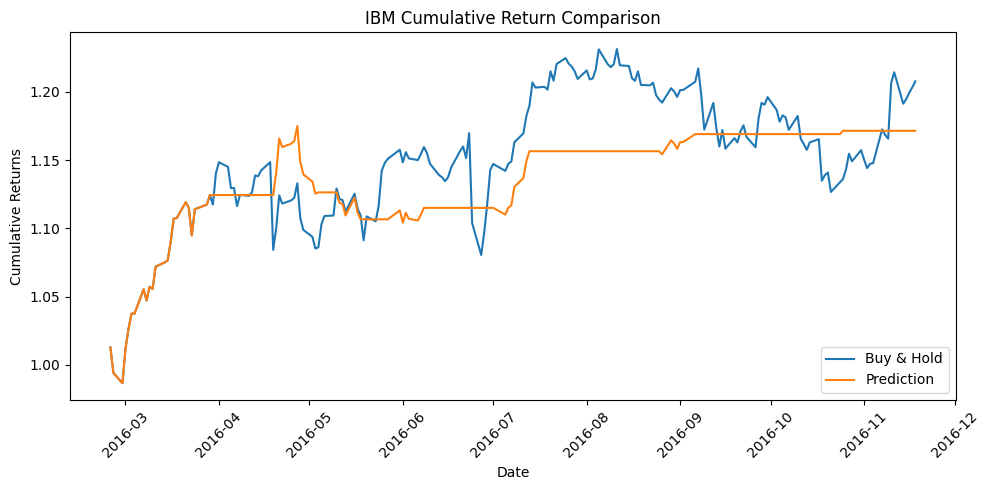

threshold = 0.5
Accuracy: 0.5160
Precision: 0.6129
Recall: 0.3619
F1 Score: 0.4551
AUC Score: 0.5455
Confusion Matrix:
[[59 24]
 [67 38]]
round 2
Epoch [10/15], Loss: 0.6621, minimum Loss: 0.6621, accuracy: 0.4468 maxaccuracy: 0.4468  Validation Loss: 0.7011, Minimum Validation Loss: 0.6944
Buy & Hold Downside Deviation: 0.0069237039933765215
Prediction Downside Deviation: 0.004899882957138459


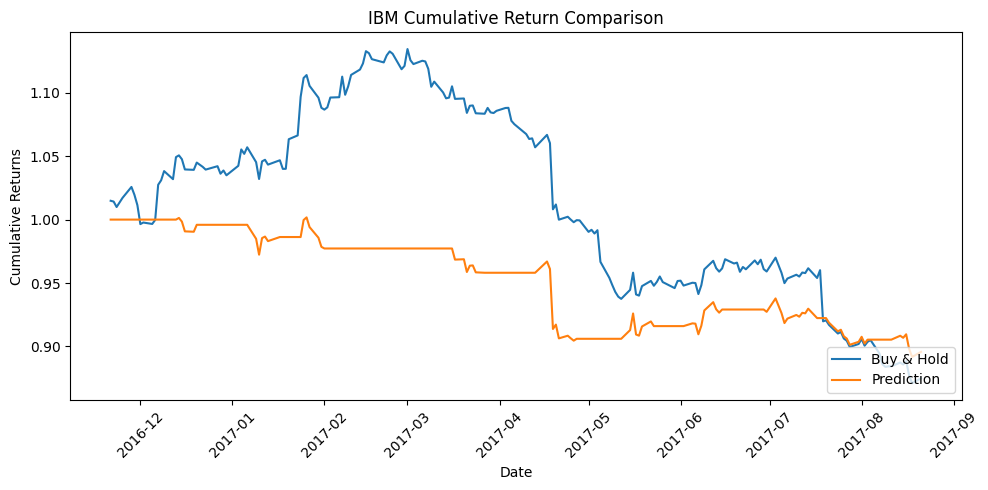

threshold = 0.5
Accuracy: 0.4894
Precision: 0.4605
Recall: 0.3889
F1 Score: 0.4217
AUC Score: 0.4613
Confusion Matrix:
[[57 41]
 [55 35]]
round 3
Epoch [10/15], Loss: 0.6822, minimum Loss: 0.6808, accuracy: 0.4894 maxaccuracy: 0.5213  Validation Loss: 0.6930, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.009975239711291939
Prediction Downside Deviation: 0.007684277164637338


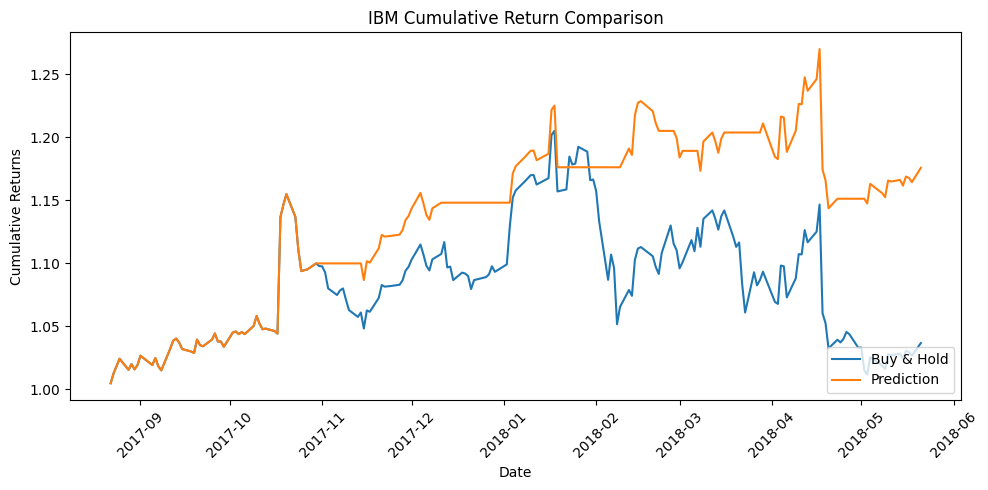

threshold = 0.5
Accuracy: 0.5426
Precision: 0.5476
Recall: 0.7041
F1 Score: 0.6161
AUC Score: 0.5489
Confusion Matrix:
[[33 57]
 [29 69]]
round 4
Epoch [10/15], Loss: 0.6647, minimum Loss: 0.6647, accuracy: 0.5372 maxaccuracy: 0.5372  Validation Loss: 0.6902, Minimum Validation Loss: 0.6898
Buy & Hold Downside Deviation: 0.011338960759082464
Prediction Downside Deviation: 0.010088787658264972


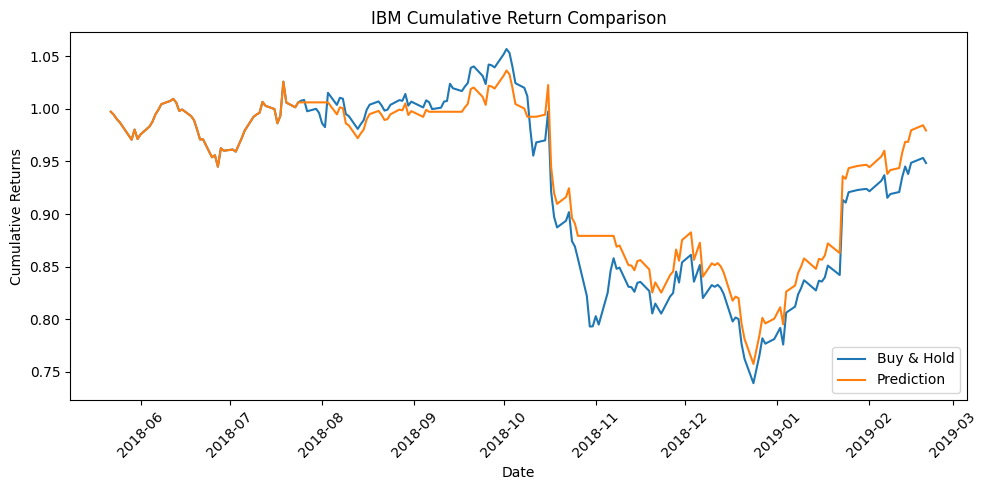

threshold = 0.5
Accuracy: 0.5266
Precision: 0.5342
Recall: 0.8600
F1 Score: 0.6590
AUC Score: 0.4610
Confusion Matrix:
[[13 75]
 [14 86]]
round 5
Epoch [10/15], Loss: 0.6666, minimum Loss: 0.6666, accuracy: 0.5691 maxaccuracy: 0.5691  Validation Loss: 0.6903, Minimum Validation Loss: 0.6903
Buy & Hold Downside Deviation: 0.009762233156716713
Prediction Downside Deviation: 0.006764572902398103


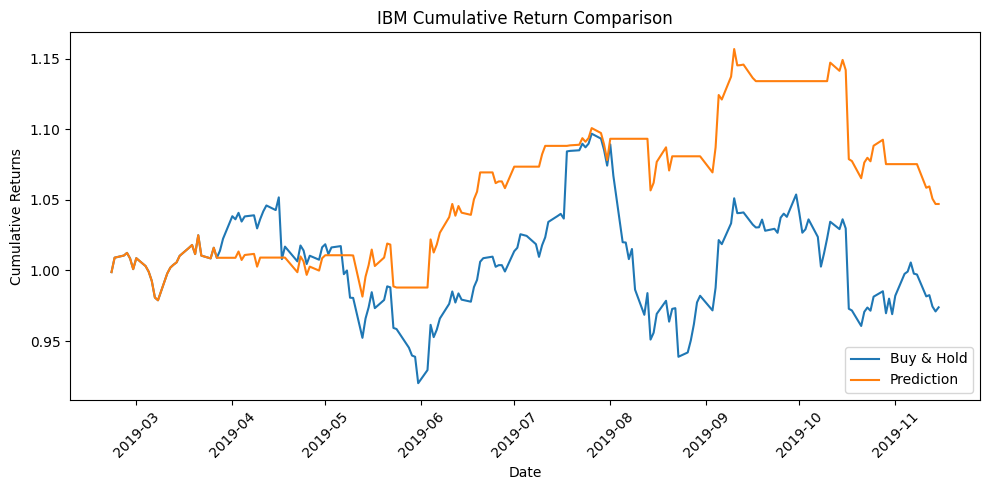

threshold = 0.5
Accuracy: 0.4947
Precision: 0.5439
Recall: 0.5905
F1 Score: 0.5662
AUC Score: 0.5142
Confusion Matrix:
[[31 52]
 [43 62]]
round 6
Epoch [10/15], Loss: 0.6685, minimum Loss: 0.6685, accuracy: 0.5053 maxaccuracy: 0.5266  Validation Loss: 0.6958, Minimum Validation Loss: 0.6911
Buy & Hold Downside Deviation: 0.01975053308136556
Prediction Downside Deviation: 0.018512868080918676


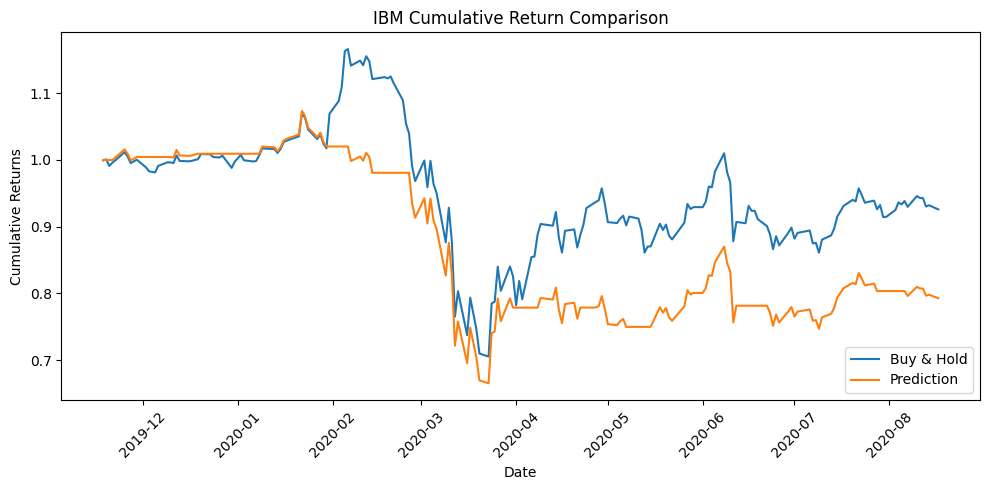

threshold = 0.5
Accuracy: 0.4787
Precision: 0.4882
Recall: 0.6526
F1 Score: 0.5586
AUC Score: 0.4630
Confusion Matrix:
[[28 65]
 [33 62]]
round 7
Epoch [10/15], Loss: 0.6779, minimum Loss: 0.6696, accuracy: 0.5187 maxaccuracy: 0.5187  Validation Loss: 0.6962, Minimum Validation Loss: 0.6925
Buy & Hold Downside Deviation: 0.012439242314571114
Prediction Downside Deviation: 0.01073106536689578


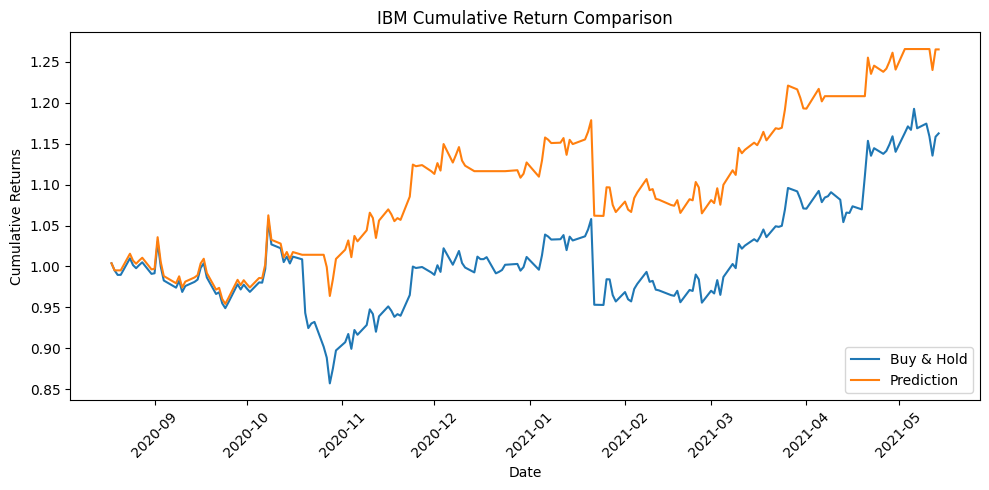

threshold = 0.5
Accuracy: 0.5027
Precision: 0.5128
Recall: 0.8247
F1 Score: 0.6324
AUC Score: 0.5073
Confusion Matrix:
[[14 76]
 [17 80]]
round 8
Epoch [10/15], Loss: 0.6694, minimum Loss: 0.6694, accuracy: 0.4920 maxaccuracy: 0.4920  Validation Loss: 0.6910, Minimum Validation Loss: 0.6910
Buy & Hold Downside Deviation: 0.010017305956602695
Prediction Downside Deviation: 0.0041050556734236856


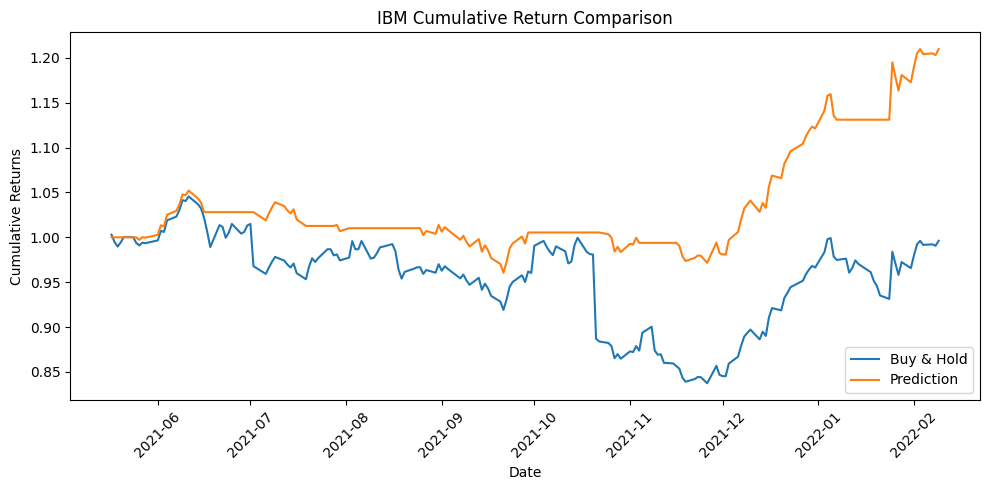

threshold = 0.5
Accuracy: 0.5294
Precision: 0.5273
Recall: 0.6170
F1 Score: 0.5686
AUC Score: 0.5287
Confusion Matrix:
[[41 52]
 [36 58]]
round 9
Epoch [10/15], Loss: 0.6660, minimum Loss: 0.6660, accuracy: 0.5134 maxaccuracy: 0.5134  Validation Loss: 0.6931, Minimum Validation Loss: 0.6928
Buy & Hold Downside Deviation: 0.010848062318847494
Prediction Downside Deviation: 0.008747712576540473


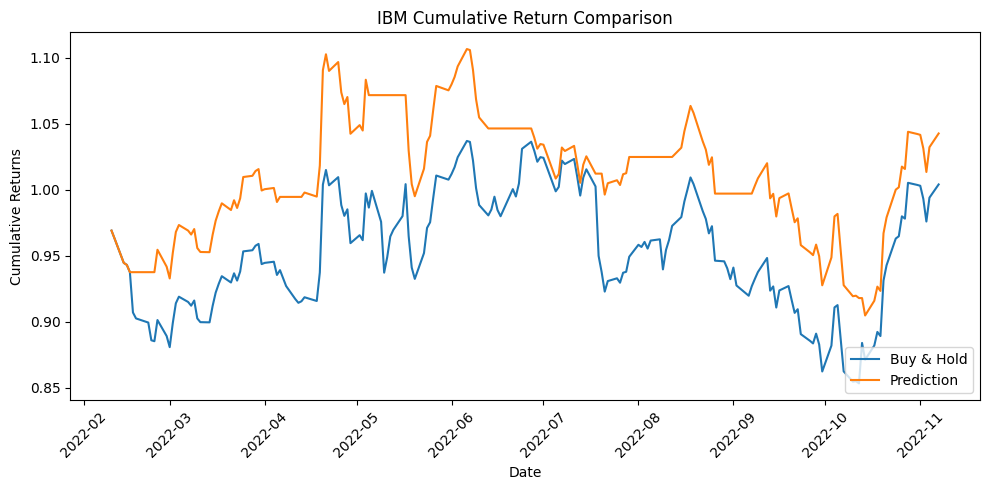

threshold = 0.5
Accuracy: 0.5187
Precision: 0.5214
Recall: 0.7604
F1 Score: 0.6186
AUC Score: 0.5350
Confusion Matrix:
[[24 67]
 [23 73]]
round 10
Epoch [10/15], Loss: 0.6862, minimum Loss: 0.6862, accuracy: 0.4973 maxaccuracy: 0.5508  Validation Loss: 0.6923, Minimum Validation Loss: 0.6899
Buy & Hold Downside Deviation: 0.008300774073829115
Prediction Downside Deviation: 0.003985210493010702


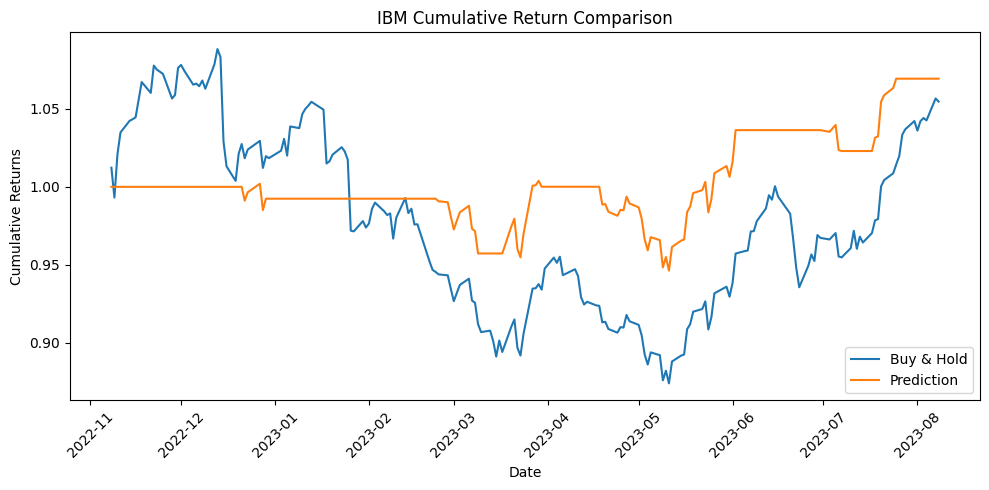

threshold = 0.5
Accuracy: 0.4920
Precision: 0.5606
Recall: 0.3592
F1 Score: 0.4379
AUC Score: 0.5225
Confusion Matrix:
[[55 29]
 [66 37]]
Buy & Hold Downside Deviation: 0.011278360615707847
Prediction Downside Deviation: 0.008988570291456738


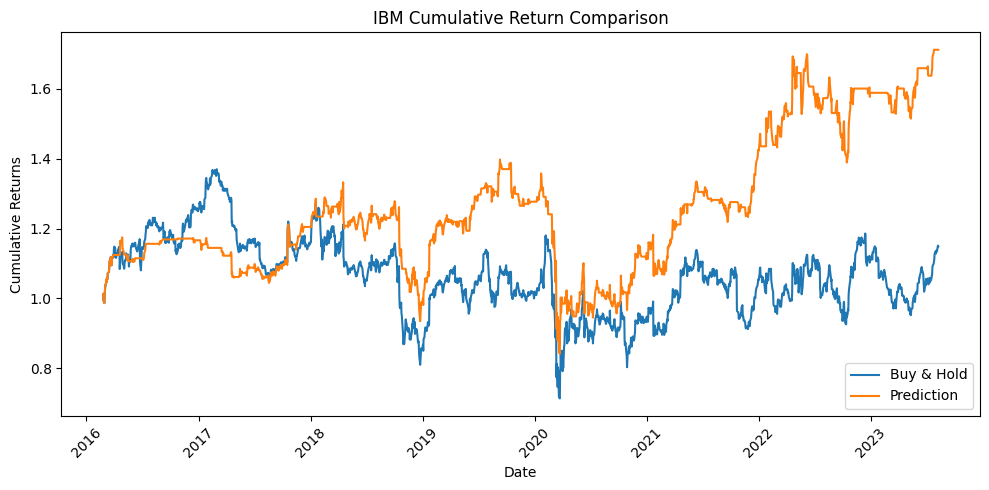

overall results:
Accuracy: 0.5091
Precision: 0.5272
Recall: 0.6104
F1 Score: 0.5658
AUC Score: 0.5041
Confusion Matrix:
[[355 538]
 [383 600]]
0.004349002525320211
Downside deviation list: [0.0031113739612110896, 0.004899882957138459, 0.007684277164637338, 0.010088787658264972, 0.006764572902398103, 0.018512868080918676, 0.01073106536689578, 0.0041050556734236856, 0.008747712576540473, 0.003985210493010702]
Cumulative return list: [1.171517522385473, 0.8957503866036144, 1.175845110891551, 0.9794104935537874, 1.0470623959800904, 0.7927078117506419, 1.265344808694571, 1.209951370983061, 1.0426102311817407, 1.069393775494974]
Overall downside deviation: 0.008988570291456738
Overall cumulative return: 1.7122721861415455




In [47]:
from itertools import product

# Other necessary imports and setup here...

# Define your hyperparameter space
hidden_units_options = [250, 500]
num_layers_options = [ 2, 3]
num_epochs_options = [ 10, 15]

# Iterate over all combinations

results = []
for hidden_units, num_layers, num_epochs in product(hidden_units_options, num_layers_options, num_epochs_options):
    print(f'Training with {hidden_units} hidden units, {num_layers} layers, {num_epochs} epochs')
    # Call your hyperParameterTuning function or equivalent training procedure
    downside_deviation_list, cumulative_return_list, overall_dd, overall_cr = hyperParameterTuning(hidden_units, num_layers, num_epochs, X_train_folds, y_train_folds, X_val_folds, y_val_folds)
    std_downside_deviation = np.std(downside_deviation_list)
    # Here you might want to save the results, or print them out
    # For example:
    print(f'Downside deviation list: {downside_deviation_list}')
    print(f'Cumulative return list: {cumulative_return_list}')
    print(f'Overall downside deviation: {overall_dd}')
    print(f'Overall cumulative return: {overall_cr}')

    print('\n')


    result = {
        'hidden_units': hidden_units,
        'num_layers': num_layers,
        'num_epochs': num_epochs,
        'downside_dev_list': downside_deviation_list,
        'cum_ret_list': cumulative_return_list,
        'std_downside_deviation': std_downside_deviation,
        'overall_downside_deviation': overall_dd,
        'overall_cumulative_return': overall_cr
    }
    results.append(result)



In [41]:
downside_deviation_list = np.array(downside_deviation_list)
np.std(downside_deviation_list)

0.004179410836562488

In [42]:
downside_deviation_list

array([0.00380581, 0.00497605, 0.0056936 , 0.01047073, 0.00674777,
       0.01767476, 0.01169505, 0.00466166, 0.00818419, 0.00387635])

In [48]:
results

[{'hidden_units': 250,
  'num_layers': 2,
  'num_epochs': 10,
  'downside_dev_list': [0.003382559038164228,
   0.001998323695547951,
   0.0057720812884859566,
   0.00766741653542668,
   0.0066752284586285736,
   0.01880747147480435,
   0.012350813557270877,
   0.009240830697256407,
   0.009832039129227284,
   0.004157684694235896],
  'cum_ret_list': [1.2075992518195993,
   0.9795721143613639,
   1.0054428044701178,
   1.1774442350024399,
   1.0970999921053028,
   1.0285474662493426,
   1.158952032500096,
   1.048819980455131,
   0.9529191099823285,
   1.1030272929083276],
  'std_downside_deviation': 0.0046857147891972125,
  'overall_downside_deviation': 0.00926101939252259,
  'overall_cumulative_return': 2.0189995687087126},
 {'hidden_units': 250,
  'num_layers': 2,
  'num_epochs': 15,
  'downside_dev_list': [0.007290832236499144,
   0.005596317314365079,
   0.005718399407754194,
   0.010177775666322598,
   0.006204927463590122,
   0.018852617190262,
   0.011898590151338503,
   0.00473

In [49]:
results_df = pd.DataFrame(results)

In [50]:
results_df

hidden_units  num_layers  num_epochs  \
0           250           2          10   
1           250           2          15   
2           250           3          10   
3           250           3          15   
4           500           2          10   
5           500           2          15   
6           500           3          10   
7           500           3          15   

                                   downside_dev_list  \
0  [0.003382559038164228, 0.001998323695547951, 0...   
1  [0.007290832236499144, 0.005596317314365079, 0...   
2  [0.003287309477502291, 0.005478766324248048, 0...   
3  [0.004091551256180524, 0.00551793399026462, 0....   
4  [0.004149623017933129, 0.0061233792726948155, ...   
5  [0.0071304046671440266, 0.005823470338626345, ...   
6  [0.0041739683159604905, 0.006111642196671793, ...   
7  [0.0031113739612110896, 0.004899882957138459, ...   

                                        cum_ret_list  std_downside_deviation  \
0  [1.2075992518195993, 0.9795721143613639, 1.005...                0.004686   
1  [1.1030261325292283, 0.8260400434625201, 0.983...                0.004248   
2  [1.1114482988983818, 0.8576747507229668, 1.081...                0.004372   
3  [1.176688887625526, 0.8601214322882115, 0.9772...                0.004357   
4  [1.1367046106966279, 0.8612278047725025, 0.935...                0.004315   
5  [1.1178936063955924, 0.8893105348441428, 1.033...                0.004126   
6  [1.2372233717715493, 0.8432107419361117, 1.008...                0.004322   
7  [1.171517522385473, 0.8957503866036144, 1.1758...                0.004349   

   overall_downside_deviation  overall_cumulative_return  
0                    0.009261                   2.019000  
1                    0.009251                   1.484513  
2                    0.009567                   1.694462  
3                    0.009069                   1.373593  
4                    0.009032                   1.374520  
5                    0.009086                   1.644484  
6                    0.009453                   1.385147  
7                    0.008989                   1.712272